In [5]:
import numpy as np
import scipy.io as sio
import sys
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from matplotlib import pyplot as plt

from pathlib import Path
import os
import random
import math
import innvestigate
import numpy as np
import matplotlib.ticker as mticker

import h5py


In [15]:
tf.compat.v1.disable_eager_execution()
path_to_folder = 'C:/Users/dominika/vpnet/tensorflow'
path_to_model = 'C:/Users/dominika/vpnet/trained_models/model.h5'
sys.path.insert(0, path_to_folder)
from VPLayer import VPLayer

model = tf.keras.models.load_model(path_to_model, custom_objects={'VPLayer': VPLayer})

c:\Users\dominika\anaconda3\envs\innvestigate\Lib\site-packages\keras\src\backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [6]:
with h5py.File('C:/Users/dominika/vpnet/tensorflow/test_data.h5', 'r') as hf:
    test_x = hf['test_x'][:]
    test_y = hf['test_y'][:]

In [10]:
predictions = model.predict(test_x, verbose = 2)
model_wo_softmax = innvestigate.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer(
    "lrp.epsilon", model, disable_model_checks=True,neuron_selection_mode="max_activation", **{"epsilon": 1}
)

a = analyzer.analyze(test_x)
print(a.shape)
print(test_x.shape)
print(predictions)

(6000, 40)
(6000, 40)
[[0.33341318 0.33481345 0.33177343]
 [0.33129504 0.3407024  0.32800257]
 [0.3120933  0.35839412 0.3295126 ]
 ...
 [0.33401853 0.33387193 0.33210957]
 [0.3302628  0.3406394  0.32909778]
 [0.3206795  0.34933147 0.3299891 ]]


In [11]:
#Create anaylzers:
#we always analyzed the output of the neuron with the highest activation
integrated_gradient_analyzer = innvestigate.create_analyzer("integrated_gradients", model_wo_softmax, neuron_selection_mode="max_activation",reference_inputs=0, steps = 64)

lrp_analyzer = innvestigate.create_analyzer("lrp.z", model, disable_model_checks=True)

lrp_epsilon_analyzer = innvestigate.create_analyzer(
    "lrp.epsilon", model, disable_model_checks=True,neuron_selection_mode="max_activation", **{"epsilon": 1e-07}
)

lrp_w_square_analyzer = innvestigate.create_analyzer(
    "lrp.w_square", model, disable_model_checks=True,neuron_selection_mode="max_activation"
)

lrp_alpha1_beta0_analyzer = innvestigate.create_analyzer(
    "lrp.alpha_1_beta_0", model, disable_model_checks=True,neuron_selection_mode="max_activation"
)

lrp_alpha2_beta1_analyzer = innvestigate.create_analyzer(
    "lrp.alpha_2_beta_1", model, disable_model_checks=True,neuron_selection_mode="max_activation"
)

lrp_alpha1_beta0_IB_analyzer = innvestigate.create_analyzer(
    "lrp.alpha_1_beta_0_IB", model, disable_model_checks=True,neuron_selection_mode="max_activation"
)

#with neuron indexing

analyzers = {
    "integrated_gradients" :integrated_gradient_analyzer,
    "lrp.z": lrp_analyzer,
    "lrp.epsilon" : lrp_epsilon_analyzer,
    "lrp.alpha_1_beta_0": lrp_alpha1_beta0_analyzer,
    "lrp.alpha_2_beta_1": lrp_alpha2_beta1_analyzer,
    }

[1, 2.4, 3.8, 5.2, 6.6, 8, 8.4, 8.8, 9.2, 9.6, 10, 11.8, 13.6, 15.4, 17.2, 19]
get_correct_prediction_indices
[   4   12   13 ... 5996 5997 5998]
-----------------------
get_incorrect_prediction_indices
[   0    1    2 ... 5994 5995 5999]
-----------------------
get_class_indices
[   4   12   13 ... 5995 5996 5998]
-----------------------
get_false_negative_indices
[  31   42   46   52   87   92  106  118  135  139  145  146  177  191
  201  215  239  245  249  281  286  314  324  329  337  341  356  358
  371  388  389  394  434  440  442  444  448  450  451  452  453  477
  492  506  514  519  520  532  550  573  585  587  599  604  625  646
  648  650  651  665  672  674  684  696  701  704  744  749  753  759
  789  794  799  800  803  808  811  838  853  864  875  884  902  903
  930  933  951  957 1007 1012 1019 1047 1051 1071 1075 1099 1113 1167
 1169 1170 1184 1188 1193 1194 1207 1214 1219 1236 1241 1249 1254 1288
 1294 1297 1303 1306 1337 1339 1340 1344 1365 1366 1368 1375 138

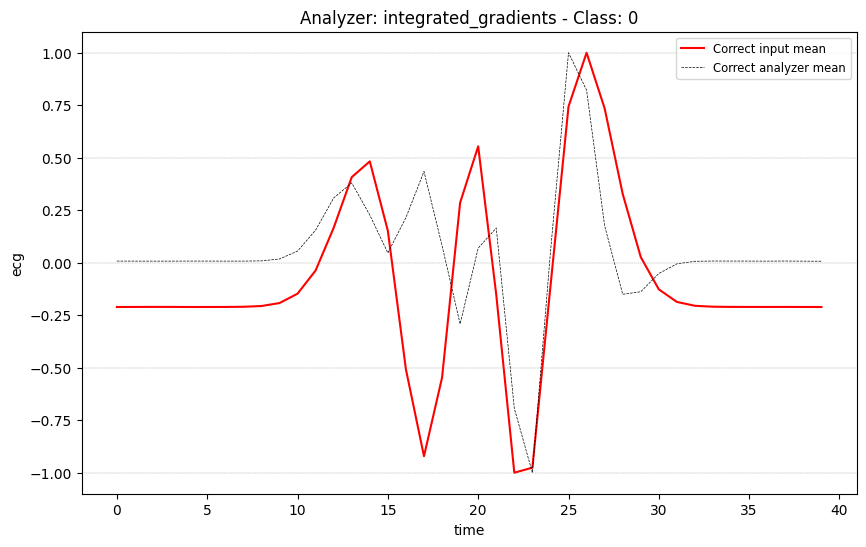

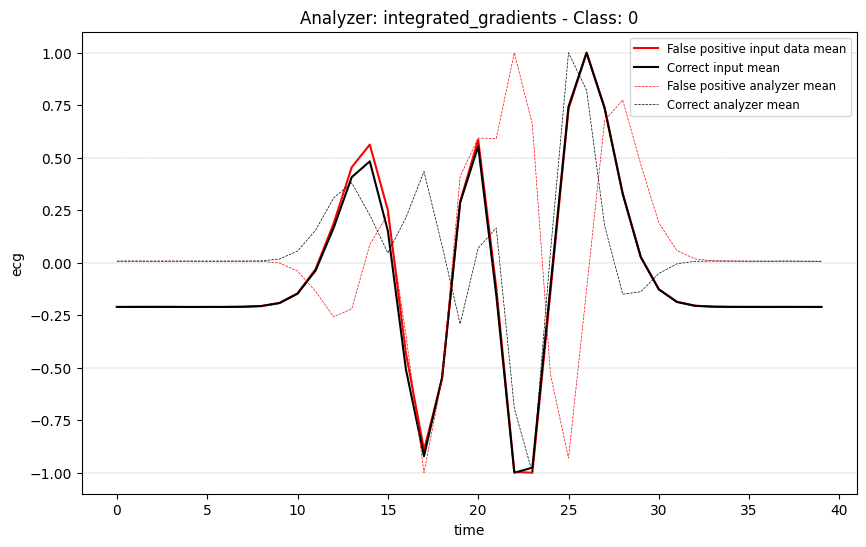

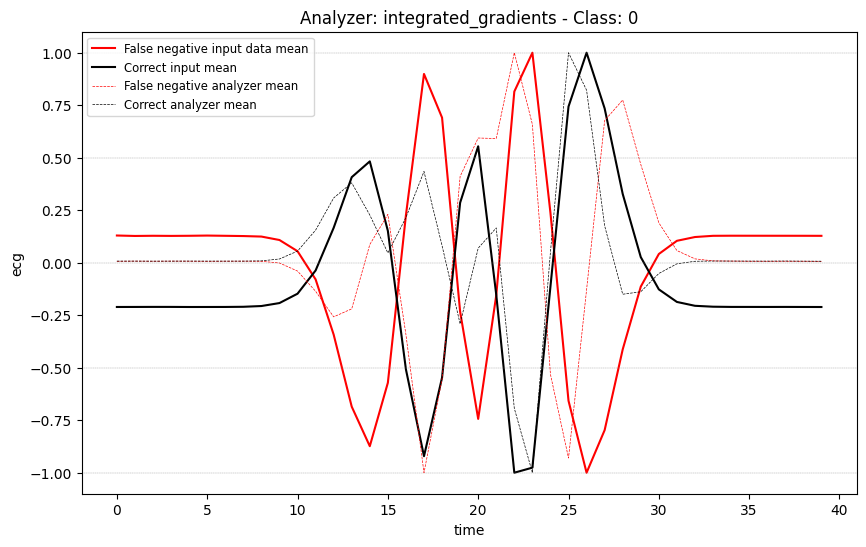

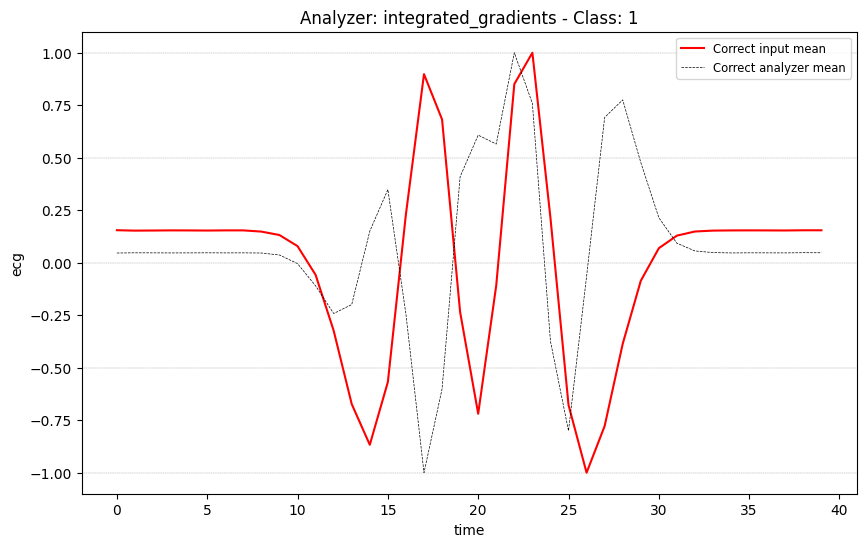

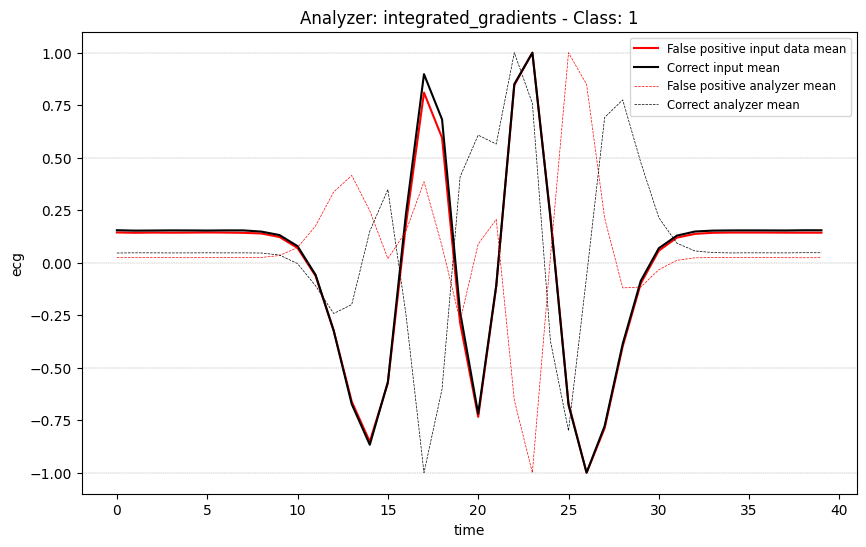

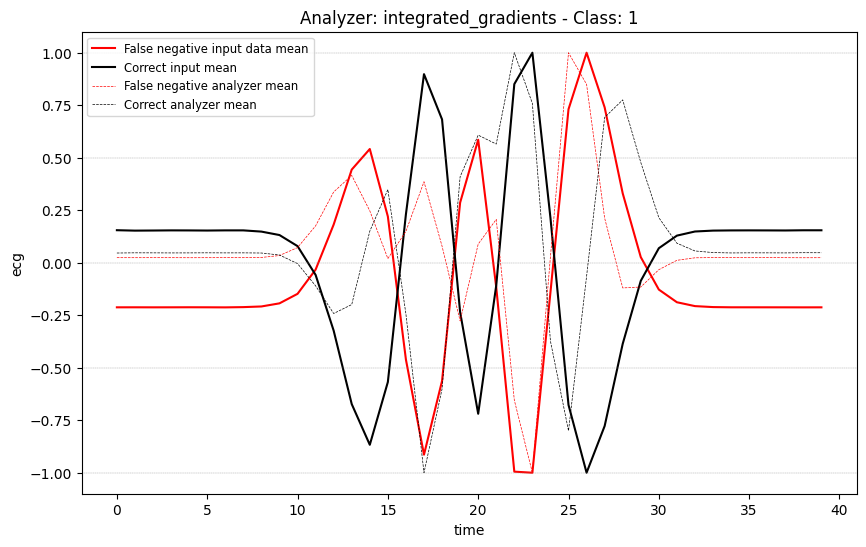

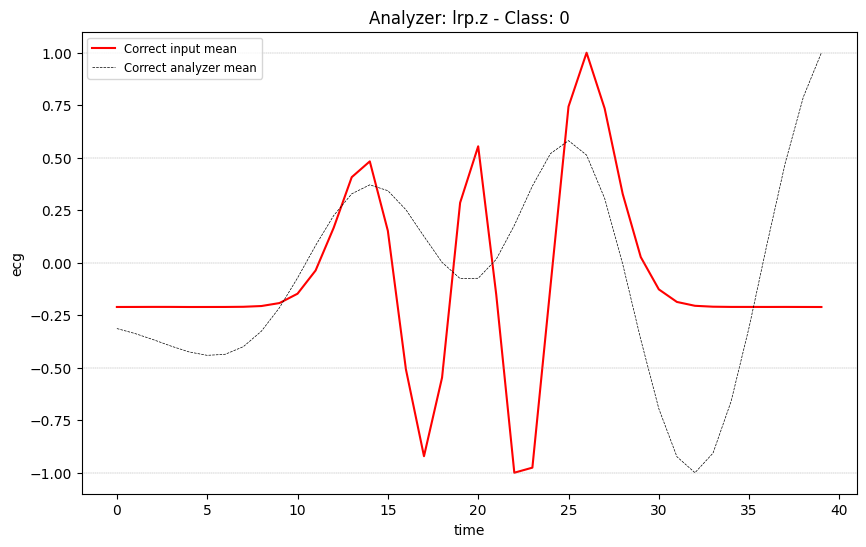

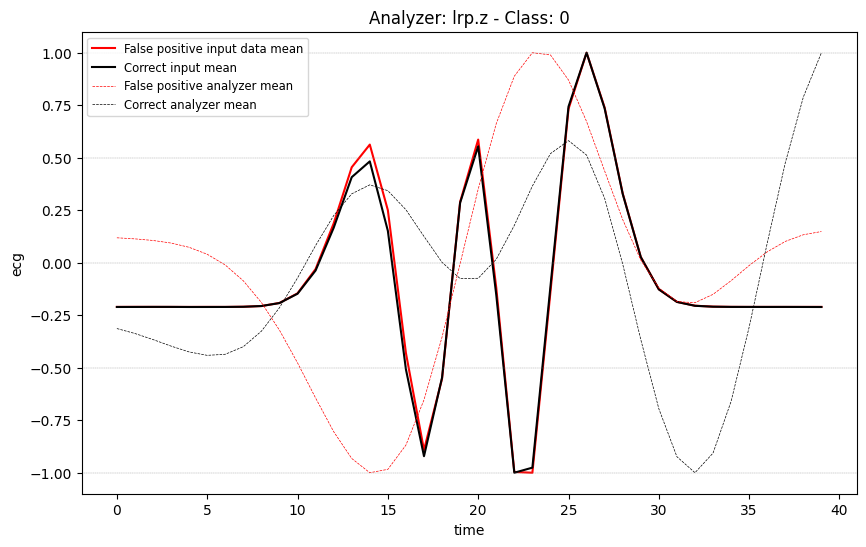

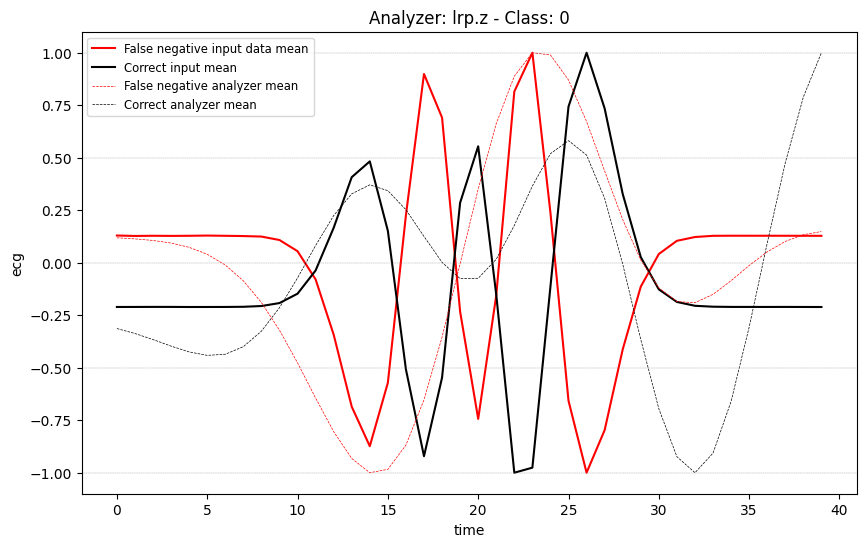

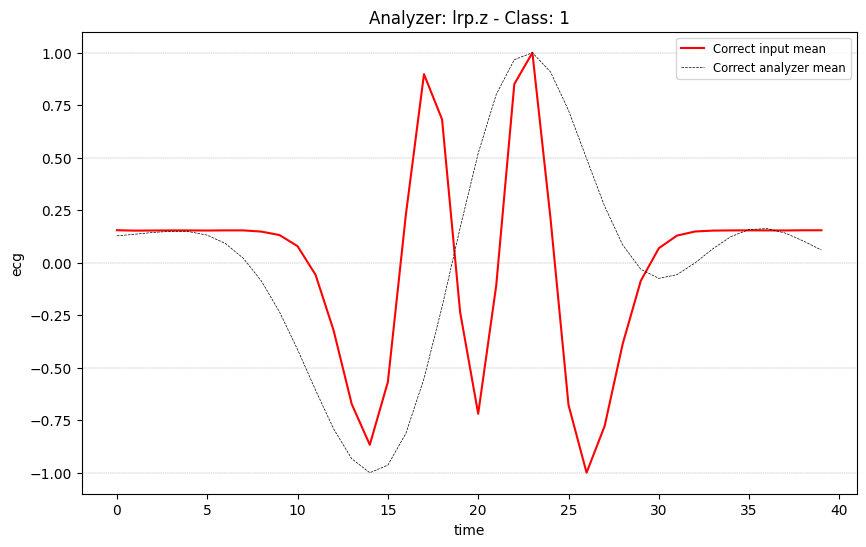

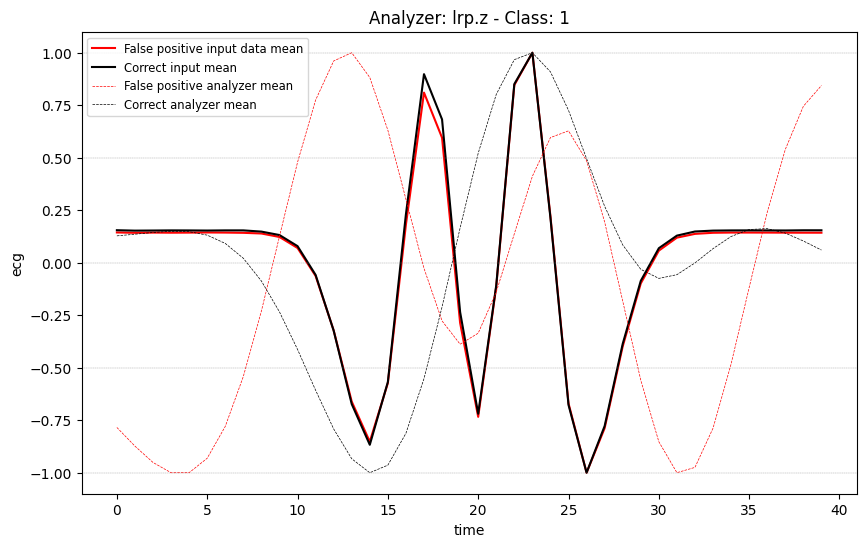

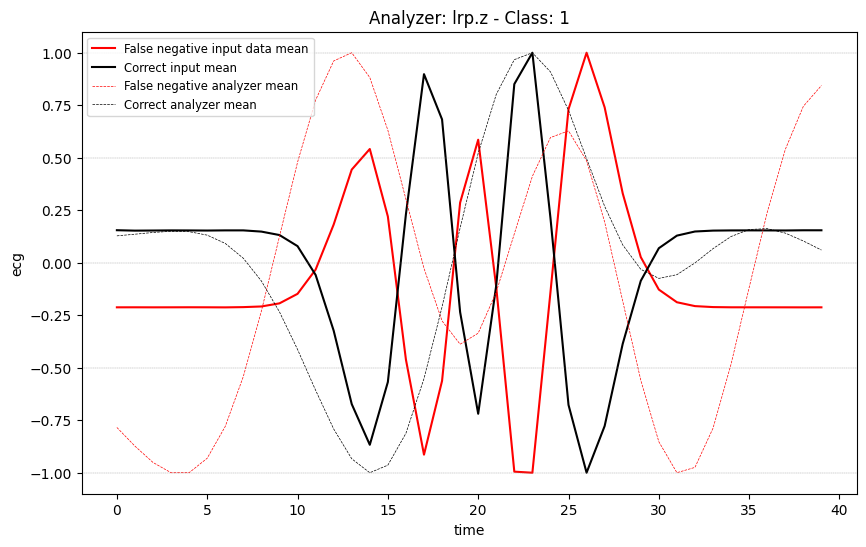

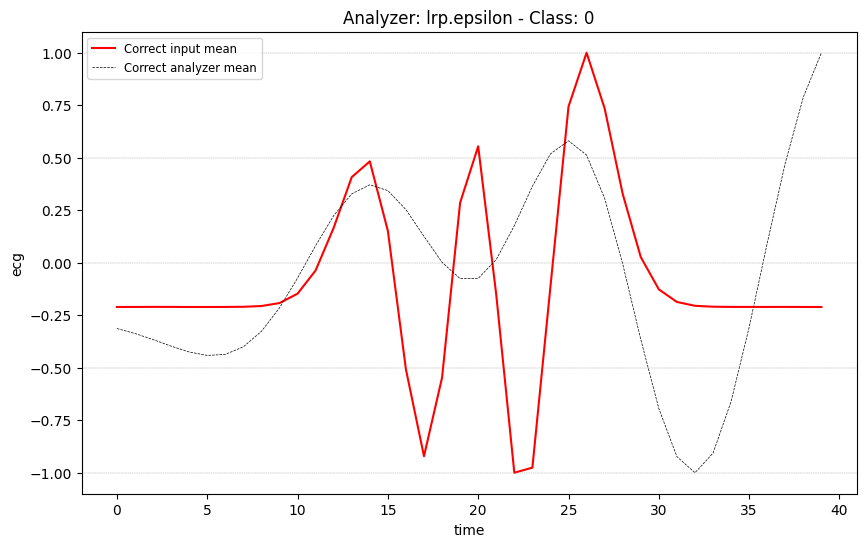

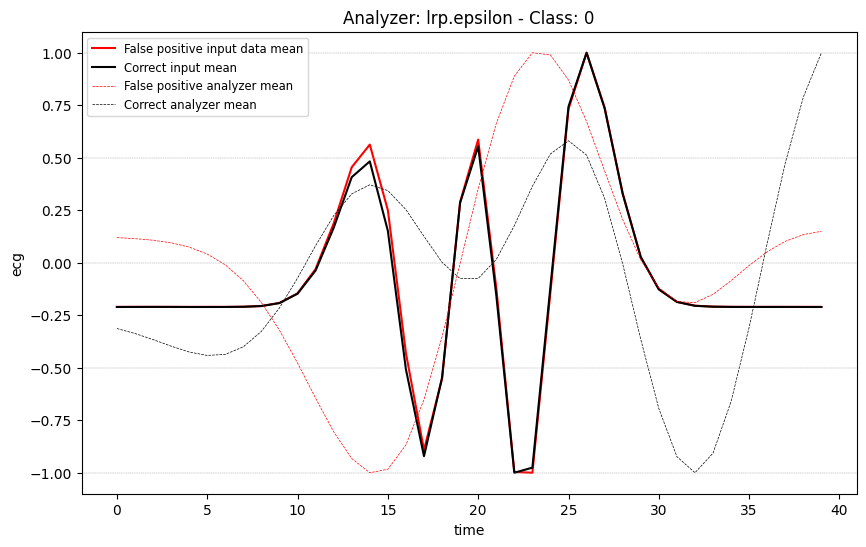

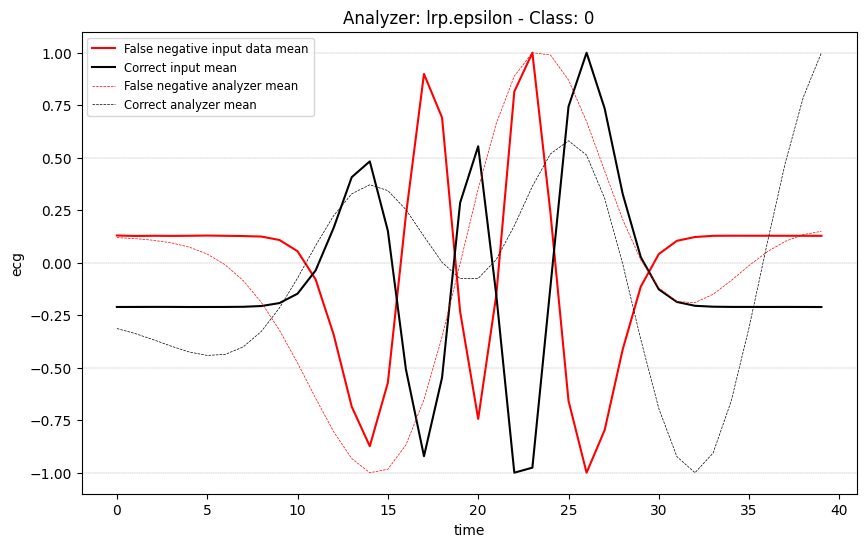

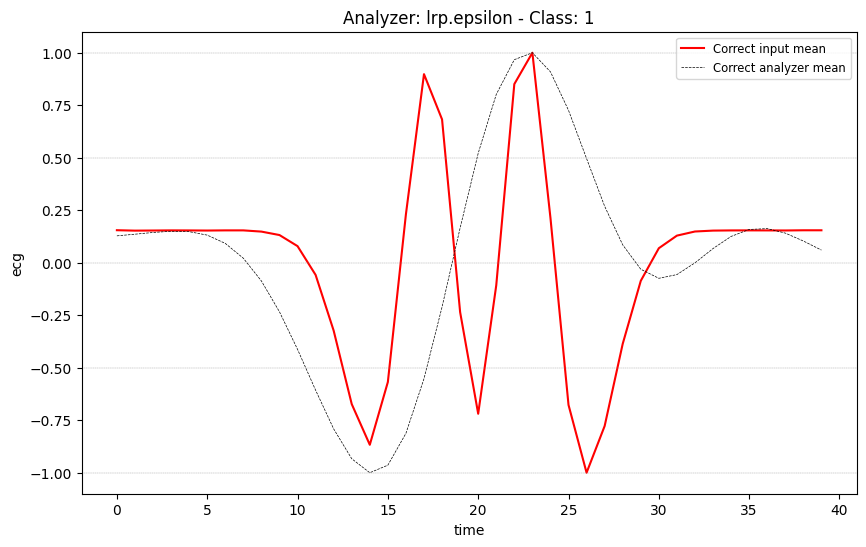

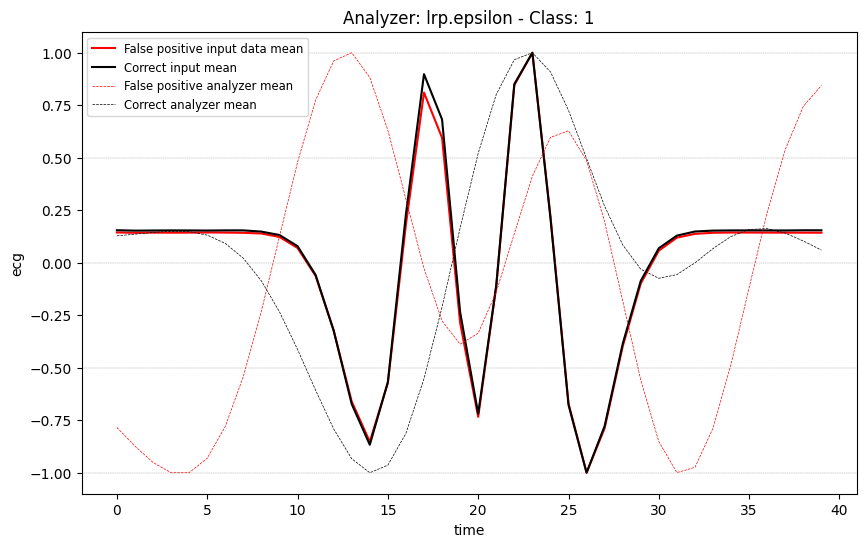

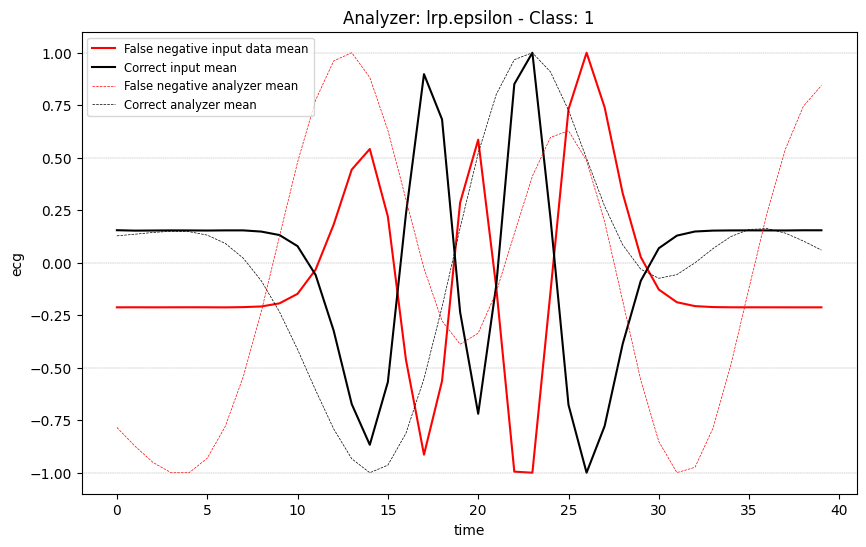

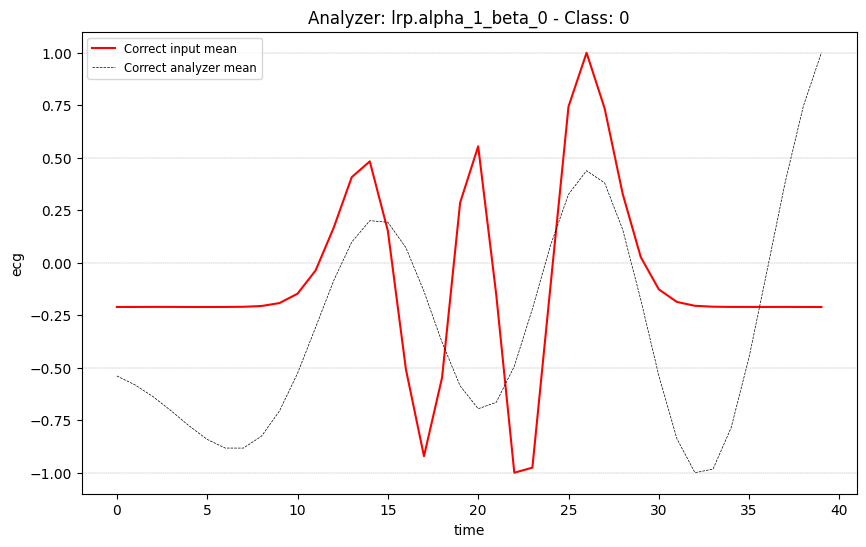

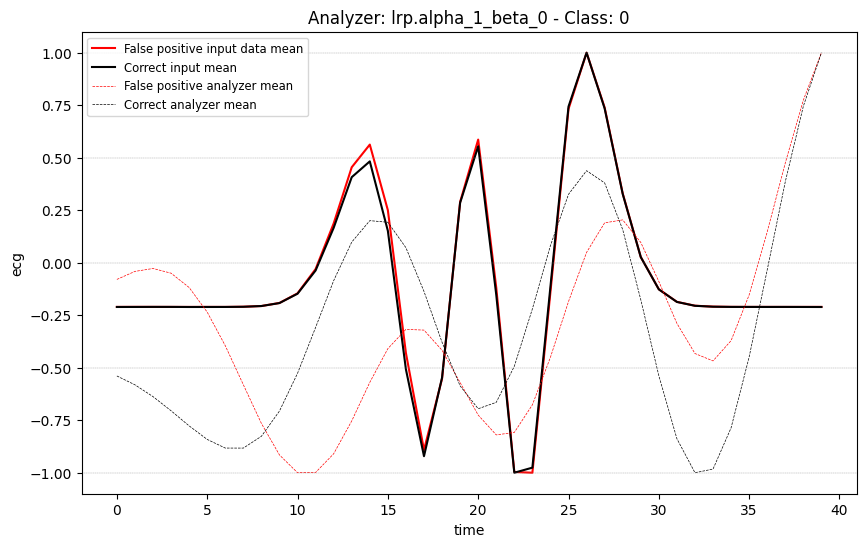

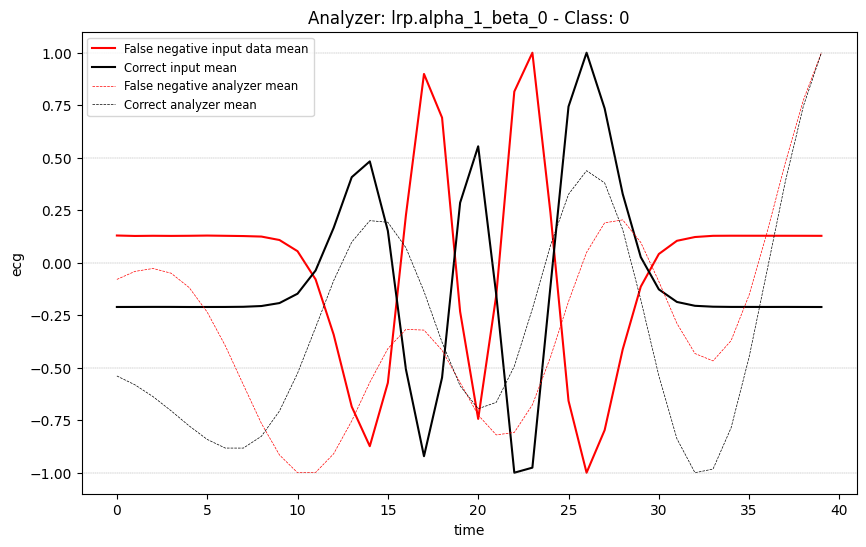

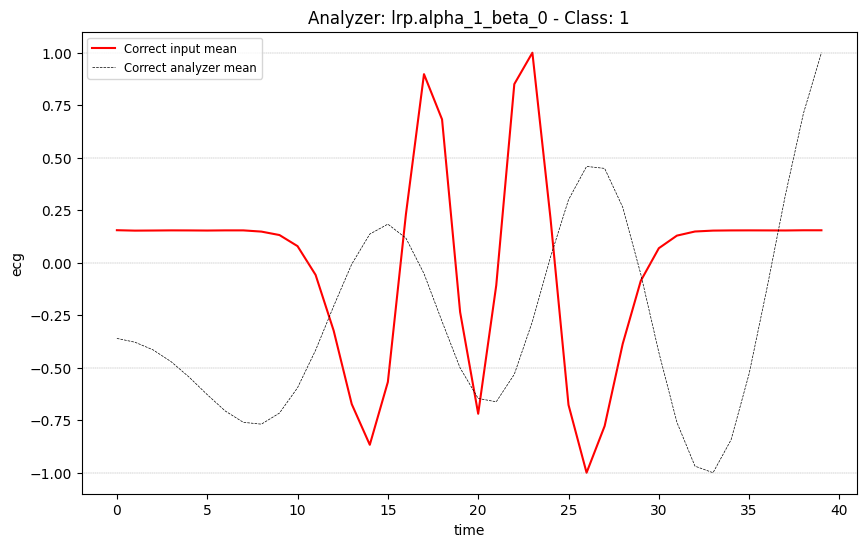

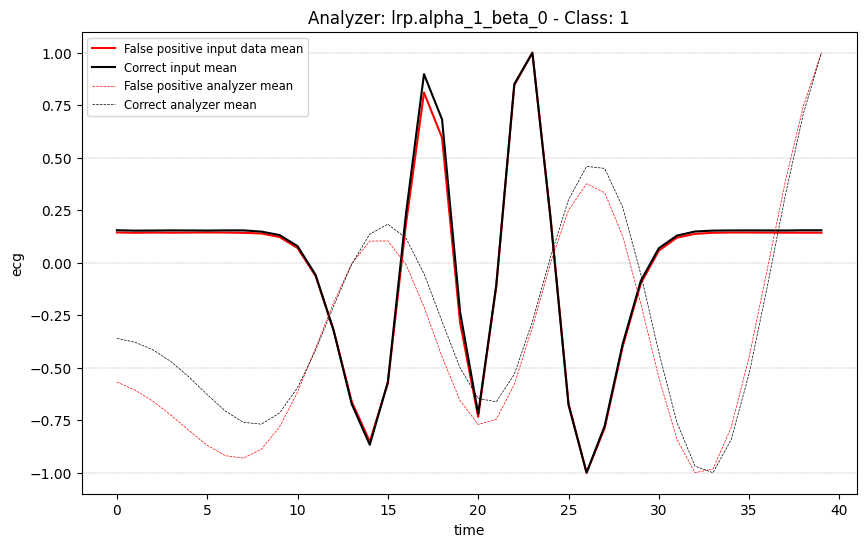

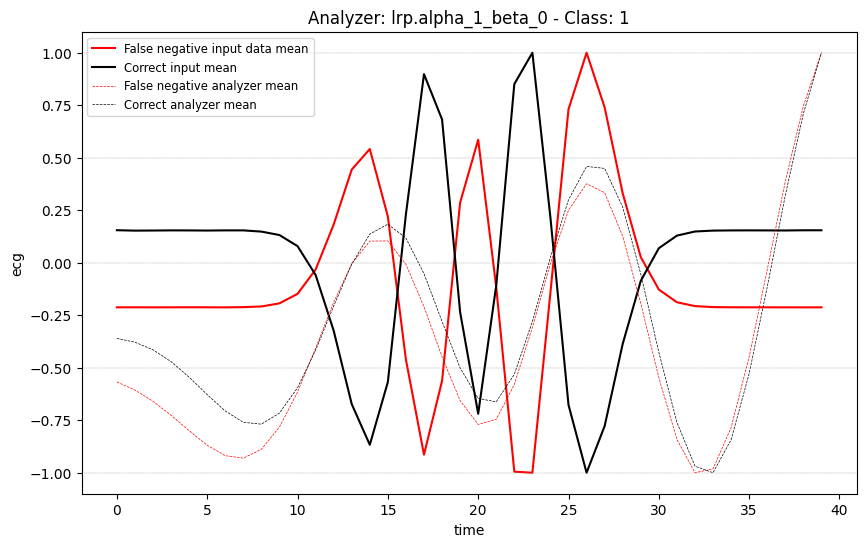

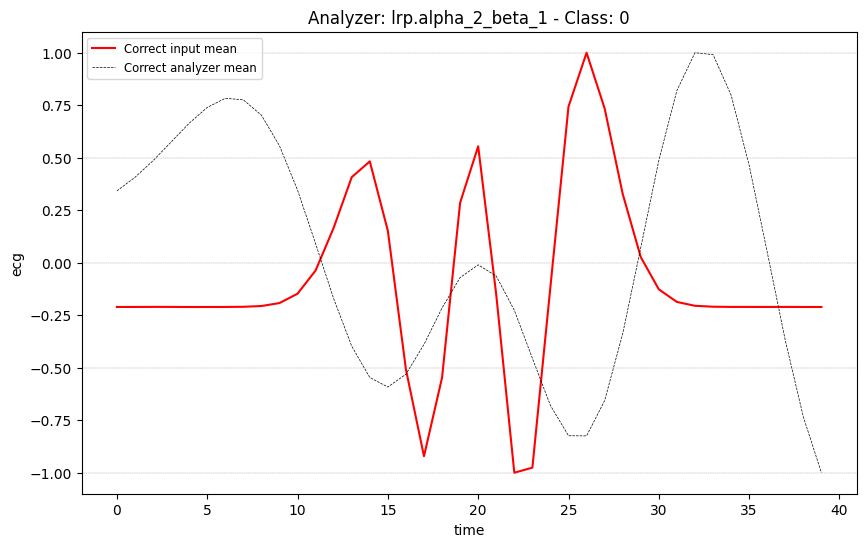

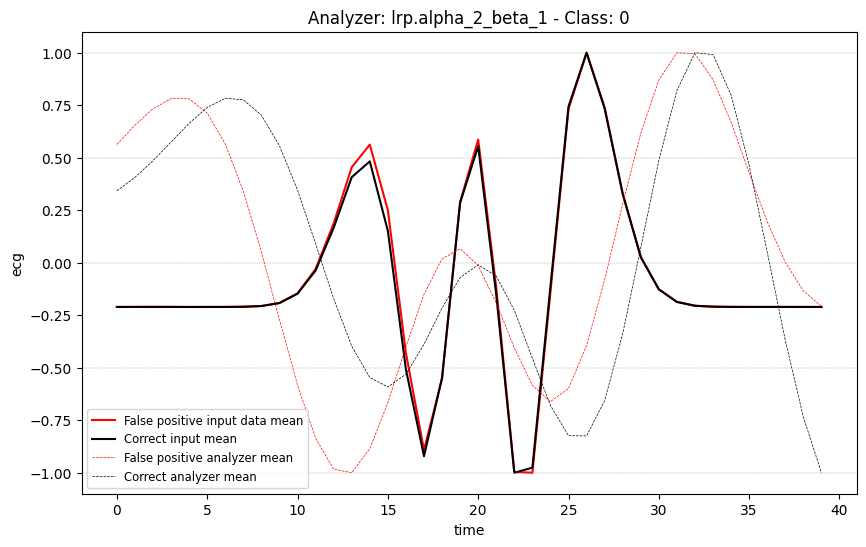

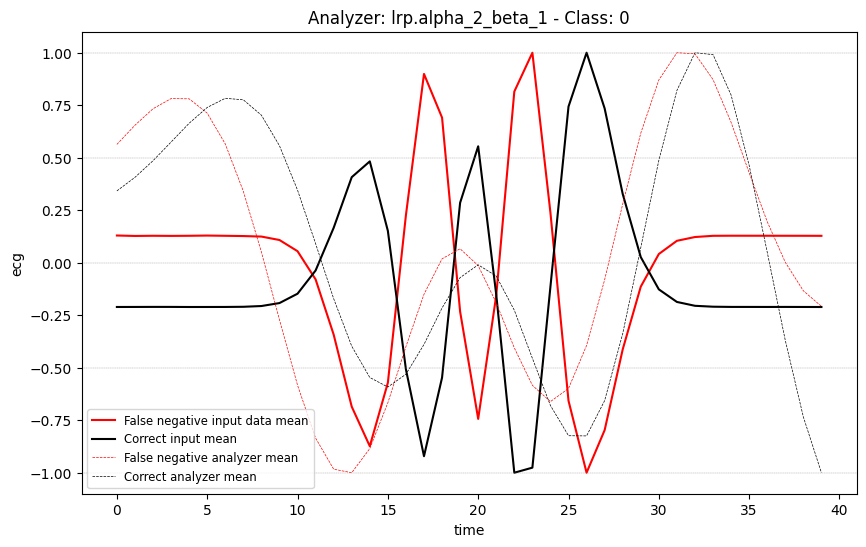

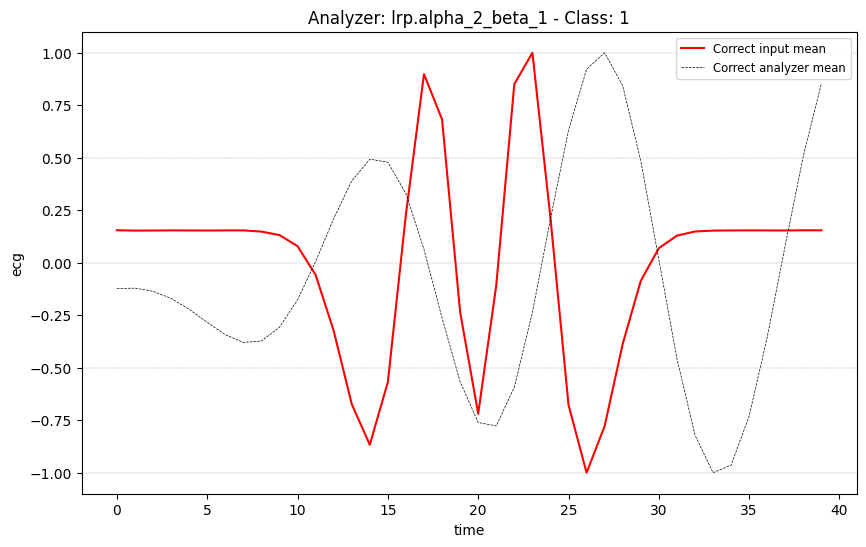

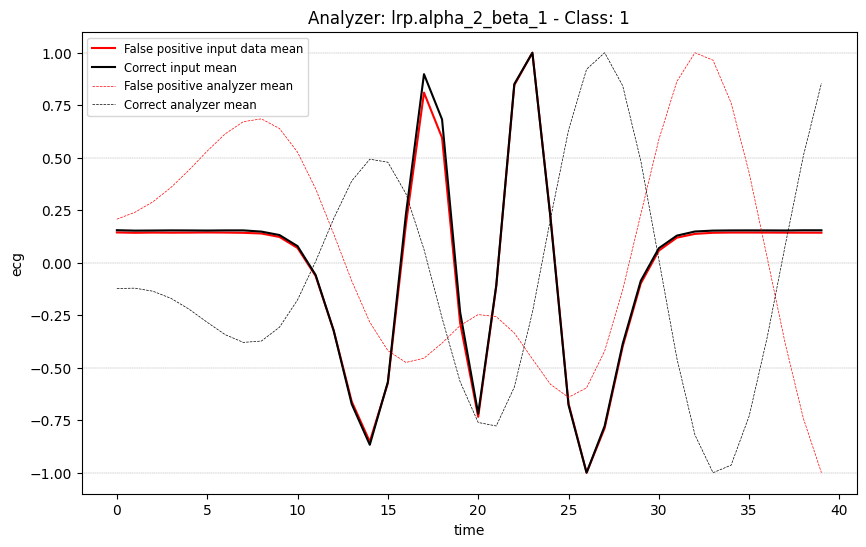

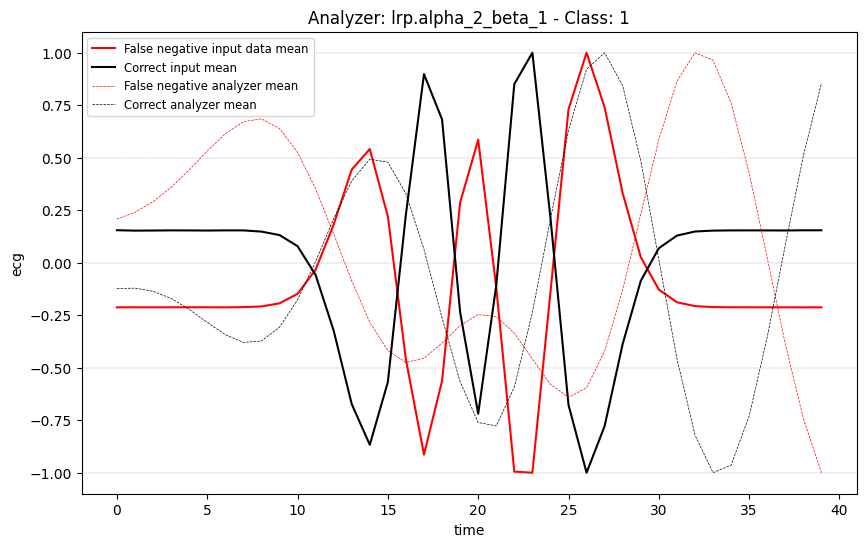

In [12]:

def normalize(data, min_val, max_val):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (max_val - min_val) + min_val

def get_predicted_classes(preds):
    return np.argmax(preds, axis=1)

def get_truth_classes(labels):
    return np.argmax(labels, axis=1)

def get_truth_class_indices(class_num, labels): # GOOD NOW
    # gives the indices of a certain class based on the ground truth label
    return np.where(get_truth_classes(labels) == class_num)[0]

def get_pred_class_indices(class_num, preds):
    return np.where(get_predicted_classes(preds) == class_num)[0]

def get_correct_prediction_indices(preds, labels): ##GOOD
    predicted_labels = np.argmax(preds, axis=1)
    return np.where(predicted_labels == np.argmax(labels, axis=1))[0]

def get_incorrect_prediction_indices(preds, labels): ##GOOD
    predicted_labels = np.argmax(preds, axis=1)
    return np.where(predicted_labels != np.argmax(labels, axis=1))[0]


def get_correct_prediction_indices_for_class(preds, labels, class_num): ##GOOD 
    correct_pred_indices = get_correct_prediction_indices(preds, labels)
    class_indices = get_truth_class_indices(class_num, labels)
    return np.intersect1d(correct_pred_indices, class_indices)

def get_incorrect_prediction_indices_for_class(preds, labels, class_num): #GOOD NOW
    false_pos_indices = get_false_positive_indices(preds, labels, class_num)
    false_neg_indices = get_false_negative_indices(preds, labels, class_num)
    return np.union1d(false_pos_indices, false_neg_indices)

def get_false_positive_indices(preds, labels, class_num): ##GOOD NOW
    truth_class_indices = get_truth_class_indices(class_num, labels)
    truth_not_class_indices = np.setdiff1d(np.arange(0, preds.shape[0]), truth_class_indices)
    pred_class_indices = get_pred_class_indices(class_num, preds)
    return np.intersect1d(truth_not_class_indices, pred_class_indices)


def get_false_negative_indices(preds, labels, class_num):  ##GOOD NOW
    incorrect_pred_indices = get_incorrect_prediction_indices(preds, labels)
    class_indices = get_truth_class_indices(class_num, labels)
    return np.intersect1d(incorrect_pred_indices, class_indices)



def upsample(data, factor):
# Determine the number of new points to be inserted between each original point
    new_points = factor - 1

    # Initialize an empty list to store the new interpolated data
    interpolated_data = []

    for i in range(len(data) - 1):
        interpolated_data.append(data[i])  # Include the original point

        # Calculate the values to be interpolated between the current and next point
        for n in range(1, new_points + 1):
            interpolated_value = data[i] + (data[i + 1] - data[i]) * n / factor
            interpolated_data.append(interpolated_value)

    interpolated_data.append(data[-1])  # Include the last original point

    return interpolated_data

def set_dynamic_ylim(data, k=1.5):
    """
    Set the y-axis limits dynamically based on the interquartile range (IQR) of the data.
    
    Parameters:
    - data: The array of data points to consider.
    - k: The factor to multiply the IQR by to define the fence for outliers. Default is 1.5.
    """
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - (k * iqr)
    upper_fence = q3 + (k * iqr)

    # Exclude data points that are outside the fences
    filtered_data = data[(data >= lower_fence) & (data <= upper_fence)]

    # Set some buffer around the min and max of the filtered data
    buffer = iqr * 0.1
    return np.min(filtered_data) - buffer, np.max(filtered_data) + buffer

def plot_binned_over_classes_distribution(input, labels, analyzer, analyzer_title):
    """
    Avarage relevance scores over class

    Creates a histogram for the analyzer given as parameter.
    The plot visualize all the classes' analyzer outcomes' distribution
    Classes seperated by the gorund truth labels
    """
    analyzer_output = analyzer.analyze(input)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = [(1, 0, 0, 0.5),(0, 0, 1, 0.5),(0, 1, 0, 0.5)]
    for class_num in [0,1,2]:
        class_indices = get_truth_class_indices(class_num, labels)
        class_values = input[class_indices]
        analyzer_class = analyzer_output[class_indices]
        if class_values.shape[0] == 0:
            continue
        ax.hist(analyzer_class.flatten(), bins=50, color=colors[class_num], histtype='step', linewidth=1, label=f"class {class_num}")
    ax.set_title(f"Distribution of analyzer {analyzer_title}")
    ax.set_yscale("log")
    ax.legend(fontsize = 'small')
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/hist_plot_distribution/{analyzer_title}.png")
    plt.show()

def plot_grouped_boxplot(predictions, class_num, analyzer, input, analyzer_title):
    analyzer_output = analyzer.analyze(input)
    class_probabilities = predictions[:, class_num]
    bin_edges = np.arange(0, 1.01, 0.01)
    columns = []

    for start, end in zip(bin_edges[:-1], bin_edges[1:]):
        indices = np.where((class_probabilities >= start) & (class_probabilities < end))
        rel_bin = analyzer_output[indices].flatten()
        #print(f"start: {start}, end: {end}, len: {len(rel_bin)}")
        columns.append(rel_bin)

    # Plotting
    plt.figure(figsize=(20, 12))
    flierprops = dict(marker='o', markersize=3, linestyle='none', markeredgecolor='red')
    for i, rel_bin in enumerate(columns):
        bin_mid_point = (bin_edges[i] + bin_edges[i+1]) / 2
        if rel_bin.size > 0:
            plt.boxplot(rel_bin, positions=[bin_mid_point], widths=0.005, flierprops=flierprops, patch_artist=True, boxprops = dict(facecolor = "gray"), showmeans=True, meanprops = dict(color = "red", linewidth = 5), medianprops = dict(color = "black", linewidth = 5))
            #plt.boxplot(rel_bin, positions=[bin_mid_point], widths=0.005, flierprops=flierprops, showmeans=True, meanprops = dict(color = "green", linewidth = 5))

    plt.title(f"{analyzer_title} vs. Probability of Class {class_num} Presence")
    plt.xlabel(f"Probability of Class {class_num} Presence")
    plt.ylabel("Relevance Scores")
    plt.xlim(bin_edges[0], bin_edges[-1])
    ylim_lower, ylim_upper = set_dynamic_ylim(analyzer_output)
    plt.ylim(ylim_lower, ylim_upper)
    tick_step = 0.1  # Define the step for the x-ticks
    positions = np.arange(bin_edges[0], bin_edges[-1], tick_step)
    plt.xticks(positions, [f"{pos:.2f}" for pos in positions], fontsize=8)
    #plt.xticks(np.arange(0, 1, 0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/box_plot_distribution/{analyzer_title}_class_{class_num}.png")
    plt.show()



def plot_avg_analyzer_vs_random_beat(input, labels, analyzer, class_num, num_to_analyze, title, predictions):
    analyzer_output = analyzer.analyze(input)
    #class indices based on the labels
    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, class_num)
    false_neg_indices_for_class = get_false_negative_indices(predictions, labels, class_num)
    false_pos_indices_for_class = get_false_positive_indices(predictions, labels, class_num)
    incorrect_indices_for_class = get_incorrect_prediction_indices_for_class(predictions, labels, class_num)

    #class values compared to the predictions
    correct_input_for_class = input[correct_indices_for_class]
    false_neg_input_for_class = input[false_neg_indices_for_class]
    false_pos_input_for_class = input[false_pos_indices_for_class]
    incorrect_input_for_class = input[incorrect_indices_for_class]

    #analyzer values for class based on the predictions
    correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
    false_neg_analyzer_for_class = analyzer_output[false_neg_indices_for_class]
    false_pos_analyzer_for_class = analyzer_output[false_pos_indices_for_class]
    incorrect_analyzer_for_class = analyzer_output[incorrect_indices_for_class]
    
    if correct_input_for_class.shape[0] == 0:
        print(f"There is no class {class_num}.")
        return

    correct_analyzer_class_mean = np.mean(correct_analyzer_for_class, axis=0, keepdims=True)
    false_neg_analyzer_class_mean = np.mean(false_neg_analyzer_for_class, axis=0, keepdims=True)
    false_pos_analyzer_class_mean = np.mean(false_neg_analyzer_for_class, axis=0, keepdims=True)
    incorrect_analyzer_class_mean = np.mean(incorrect_analyzer_for_class, axis=0, keepdims=True)

    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    incorrect_input_class_mean = np.mean(incorrect_input_for_class, axis=0, keepdims=True)



    random_correct_indices_to_plot = random.sample(range(correct_input_for_class.shape[0]), num_to_analyze)
    random_false_neg_indices_to_plot = random.sample(range(false_neg_input_for_class.shape[0]), num_to_analyze)
    random_false_pos_indices_to_plot = random.sample(range(false_neg_input_for_class.shape[0]), num_to_analyze)
    random_incorrect_indices_to_plot = random.sample(range(incorrect_input_for_class.shape[0]), num_to_analyze)

    #########################################################################################
    num_rows = (num_to_analyze + 1) // 2
    fig, axs = plt.subplots(num_rows+1, 2, figsize=(15, 8 * num_rows+1))
    plt.subplots_adjust(hspace=0.5)

    axs[0,0].hist(correct_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1)
    axs[0,0].set_title("Input distribution")
    axs[0,0].set_yscale("log")


    axs[0,1].hist(correct_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1)
    axs[0,1].set_title("Analyzer distribution")
    axs[0,1].set_yscale("log")
    
    for i, index in enumerate(random_correct_indices_to_plot):
        row, col = divmod(i, 2)
        ax = axs[row+1, col]
    
        #_, rpeaks = nk.ecg_peaks(train_x[i], sampling_rate=40)
        #_, waves_peak = nk.ecg_delineate(train_x[i], rpeaks, sampling_rate=sample_rate, method="peak")
        #ax.axvline(x = rpeaks['ECG_R_Peaks'][0], color = 'k', label = 'R peak')
        #input
        ax.plot(normalize(correct_input_for_class[index,:], -1, 1), color="r", linewidth = 1.5, label="Single correct input data")
        #output
        #ax.plot(normalize(analyzer_class[index, :], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5, label="Analyzer Output")
        #mean input
        #ax.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="b", label="Input mean")
        #mean output
        ax.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
        #ax.scatter(range(correct_analyzer_for_class.shape[1]), normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", label="Correct analyzer mean", s=2)
            
        
        for h_line in np.arange(-1,1.25,0.5):
            ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        
        ax.set_yticks(np.arange(-1, 1.25, 0.25))
        ax.legend(fontsize = 'small')
        ax.set_ylabel("ecg")
        ax.set_xlabel("time")
    fig.suptitle(f"Analyzer: {title} - Class: {class_num}")
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_single_beat/correct/{title}_class_{class_num}.png")
    plt.show()

    #########################################################################################
    if len(false_neg_input_for_class) > 0:
        num_rows = (num_to_analyze) // 2
        fig, axs = plt.subplots(num_rows+1, 2, figsize=(15, 8 * num_rows+1))
        plt.subplots_adjust(hspace=0.5)

        axs[0,0].hist(incorrect_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1)
        axs[0,0].set_title("Input distribution")
        axs[0,0].set_yscale("log")


        axs[0,1].hist(incorrect_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1)
        axs[0,1].set_title("Analyzer distribution")
        axs[0,1].set_yscale("log")
        
        for i, index in enumerate(random_false_neg_indices_to_plot):
            row, col = divmod(i, 2)
            ax = axs[row+1, col]
            ax.plot(normalize(false_neg_input_for_class[index,:], -1, 1), color="r", linewidth = 1.5,label="Single false negative input data")
            ax.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct input mean")
            ax.plot(normalize(false_neg_analyzer_class_mean[0,:], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5, label="False negative analyzer mean")
            ax.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
            
            for h_line in np.arange(-1,1.25,0.5):
                ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
            
            ax.set_yticks(np.arange(-1, 1.25, 0.25))
            ax.legend(fontsize = 'small')
            ax.set_ylabel("ecg")
            ax.set_xlabel("time")
        fig.suptitle(f"Analyzer: {title} - Class: {class_num}")
        #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_single_beat/incorrect/false_neg/{title}_class_{class_num}.png")
        plt.show()

    #########################################################################################
    if len(false_pos_input_for_class) > 0:
        num_rows = (num_to_analyze) // 2
        fig, axs = plt.subplots(num_rows+1, 2, figsize=(15, 8 * num_rows+1))
        plt.subplots_adjust(hspace=0.5)

        axs[0,0].hist(incorrect_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1)
        axs[0,0].set_title("Input distribution")
        axs[0,0].set_yscale("log")


        axs[0,1].hist(incorrect_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1)
        axs[0,1].set_title("Analyzer distribution")
        axs[0,1].set_yscale("log")

        fig.show()
        
        for i, index in enumerate(random_false_pos_indices_to_plot):
            row, col = divmod(i, 2)
            ax = axs[row+1, col]
            ax.plot(normalize(false_pos_input_for_class[index,:], -1, 1), color="r", linewidth = 1.5, label="Single false positive input data")
            ax.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct input mean")
            ax.plot(normalize(false_pos_analyzer_class_mean[0,:], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5, label="False positive analyzer mean")
            ax.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
            
            for h_line in np.arange(-1,1.25,0.5):
                ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
            
            ax.set_yticks(np.arange(-1, 1.25, 0.25))
            ax.legend(fontsize = 'small')
            ax.set_ylabel("ecg")
            ax.set_xlabel("time")
        fig.suptitle(f"Analyzer: {title} - Class: {class_num}")
        #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_single_beat/incorrect/false_pos/{title}_class_{class_num}.png")
        plt.show()

def plot_avarage_relevance_scores_over_class_and_beats(input, labels, analyzer, class_num, title, predictions):
    analyzer_output = analyzer.analyze(input)

    #class indices based on the labels
    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, class_num)
    false_neg_indices_for_class = get_false_negative_indices(predictions, labels, class_num)
    false_pos_indices_for_class = get_false_positive_indices(predictions, labels, class_num)
    incorrect_indices_for_class = get_incorrect_prediction_indices_for_class(predictions, labels, class_num)

    #class values compared to the predictions
    correct_input_for_class = input[correct_indices_for_class]
    false_neg_input_for_class = input[false_neg_indices_for_class]
    false_pos_input_for_class = input[false_pos_indices_for_class]
    incorrect_input_for_class = input[incorrect_indices_for_class]

    #analyzer values for class based on the predictions
    correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
    false_neg_analyzer_for_class = analyzer_output[false_neg_indices_for_class]
    false_pos_analyzer_for_class = analyzer_output[false_pos_indices_for_class]
    incorrect_analyzer_for_class = analyzer_output[incorrect_indices_for_class]
    
    if correct_input_for_class.shape[0] == 0:
        print(f"There is no class {class_num}.")
        return

    correct_analyzer_class_mean = np.mean(correct_analyzer_for_class, axis=0, keepdims=True)
    false_neg_analyzer_class_mean = np.mean(false_neg_analyzer_for_class, axis=0, keepdims=True)
    false_pos_analyzer_class_mean = np.mean(false_neg_analyzer_for_class, axis=0, keepdims=True)
    incorrect_analyzer_class_mean = np.mean(incorrect_analyzer_for_class, axis=0, keepdims=True)

    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    false_neg_input_class_mean = np.mean(false_neg_input_for_class, axis=0, keepdims=True)
    false_pos_input_class_mean = np.mean(false_pos_input_for_class, axis=0, keepdims=True)
    incorrect_input_class_mean = np.mean(incorrect_input_for_class, axis=0, keepdims=True)

    upsamled_correct_analyzer_for_class = upsample(correct_analyzer_class_mean[0,:], 5)
    upsamled_incorrect_analyzer_for_class = upsample(incorrect_analyzer_class_mean[0,:], 5)

    #########################################################################################

    plt.figure(figsize=(10,6))
    plt.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="r", label="Correct input mean")
    plt.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
    #mean output
    #plt.plot(normalize(correct_analyzer_for_class[0,:], -1, 1), color="k", label="Analyzer mean", linewidth=0.5)
    #plt.scatter(range(len(correct_analyzer_for_class[0,:])), normalize(correct_analyzer_for_class[0,:], -1, 1), color="k", label="Correct analyzer mean", s=2)
    

    for h_line in np.arange(-1,1.25,0.5):
        plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
    
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.legend(fontsize = 'small')
    plt.ylabel("ecg")
    plt.xlabel("time")
    plt.title(f"Analyzer: {title} - Class: {class_num}")
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_avg_beat/correct/{title}_class_{class_num}.png")
    plt.show()


    #########################################################################################
    if len(false_pos_input_for_class) > 0:
        plt.figure(figsize=(10,6))
        plt.plot(normalize(false_pos_input_class_mean[0,:], -1, 1), color="r", linewidth = 1.5, label="False positive input data mean")
        plt.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct input mean")
        plt.plot(normalize(false_pos_analyzer_class_mean[0,:], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5, label="False positive analyzer mean")
        plt.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
        for h_line in np.arange(-1,1.25,0.5):
            plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        plt.yticks(np.arange(-1, 1.25, 0.25))
        plt.legend(fontsize = 'small')
        plt.ylabel("ecg")
        plt.xlabel("time")
        plt.title(f"Analyzer: {title} - Class: {class_num}")
        #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_avg_beat/incorrect/false_pos/{title}_class_{class_num}.png")
        plt.show()

    #########################################################################################
    if len(false_neg_input_for_class) > 0:
        plt.figure(figsize=(10,6))
        plt.plot(normalize(false_neg_input_class_mean[0,:], -1, 1), color="r", linewidth = 1.5, label="False negative input data mean")
        plt.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct input mean")
        plt.plot(normalize(false_neg_analyzer_class_mean[0,:], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5, label="False negative analyzer mean")
        plt.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
        #plt.scatter(range(len(incorrect_analyzer_for_class[0,:])), normalize(correct_analyzer_for_class[0,:], -1, 1), color="k", label="Analyzer mean", s=2)
        for h_line in np.arange(-1,1.25,0.5):
            plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        plt.yticks(np.arange(-1, 1.25, 0.25))
        plt.legend(fontsize = 'small')
        plt.ylabel("ecg")
        plt.xlabel("time")
        plt.title(f"Analyzer: {title} - Class: {class_num}")
        #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_avg_beat/incorrect/false_neg/{title}_class_{class_num}.png")
        plt.show()


print(upsample([1,8,10,19],5))
print("get_correct_prediction_indices")
print(get_correct_prediction_indices(predictions, test_y))
print("-----------------------")
print("get_incorrect_prediction_indices")
print(get_incorrect_prediction_indices(predictions, test_y))
print("-----------------------")
print("get_class_indices")
print(get_truth_class_indices(1, test_y))
print("-----------------------")
print("get_false_negative_indices")
print(get_false_negative_indices(predictions, test_y, 1))
print("-----------------------")
print("get_false_positive_indices")
print(get_false_positive_indices(predictions, test_y, 0))


for key,value in analyzers.items():
    for class_num in [0,1]:
        #plot_avg_analyzer_vs_random_beat(test_x, test_y, value, class_num, 4, key, predictions)
        plot_avarage_relevance_scores_over_class_and_beats(test_x, test_y, value, class_num, key, predictions)
        #plot_grouped_boxplot(predictions, class_num, value, test_x, key)
for key,value in analyzers.items():
    #plot_binned_over_classes_distribution(test_x, test_y, value, key)
    pass
    



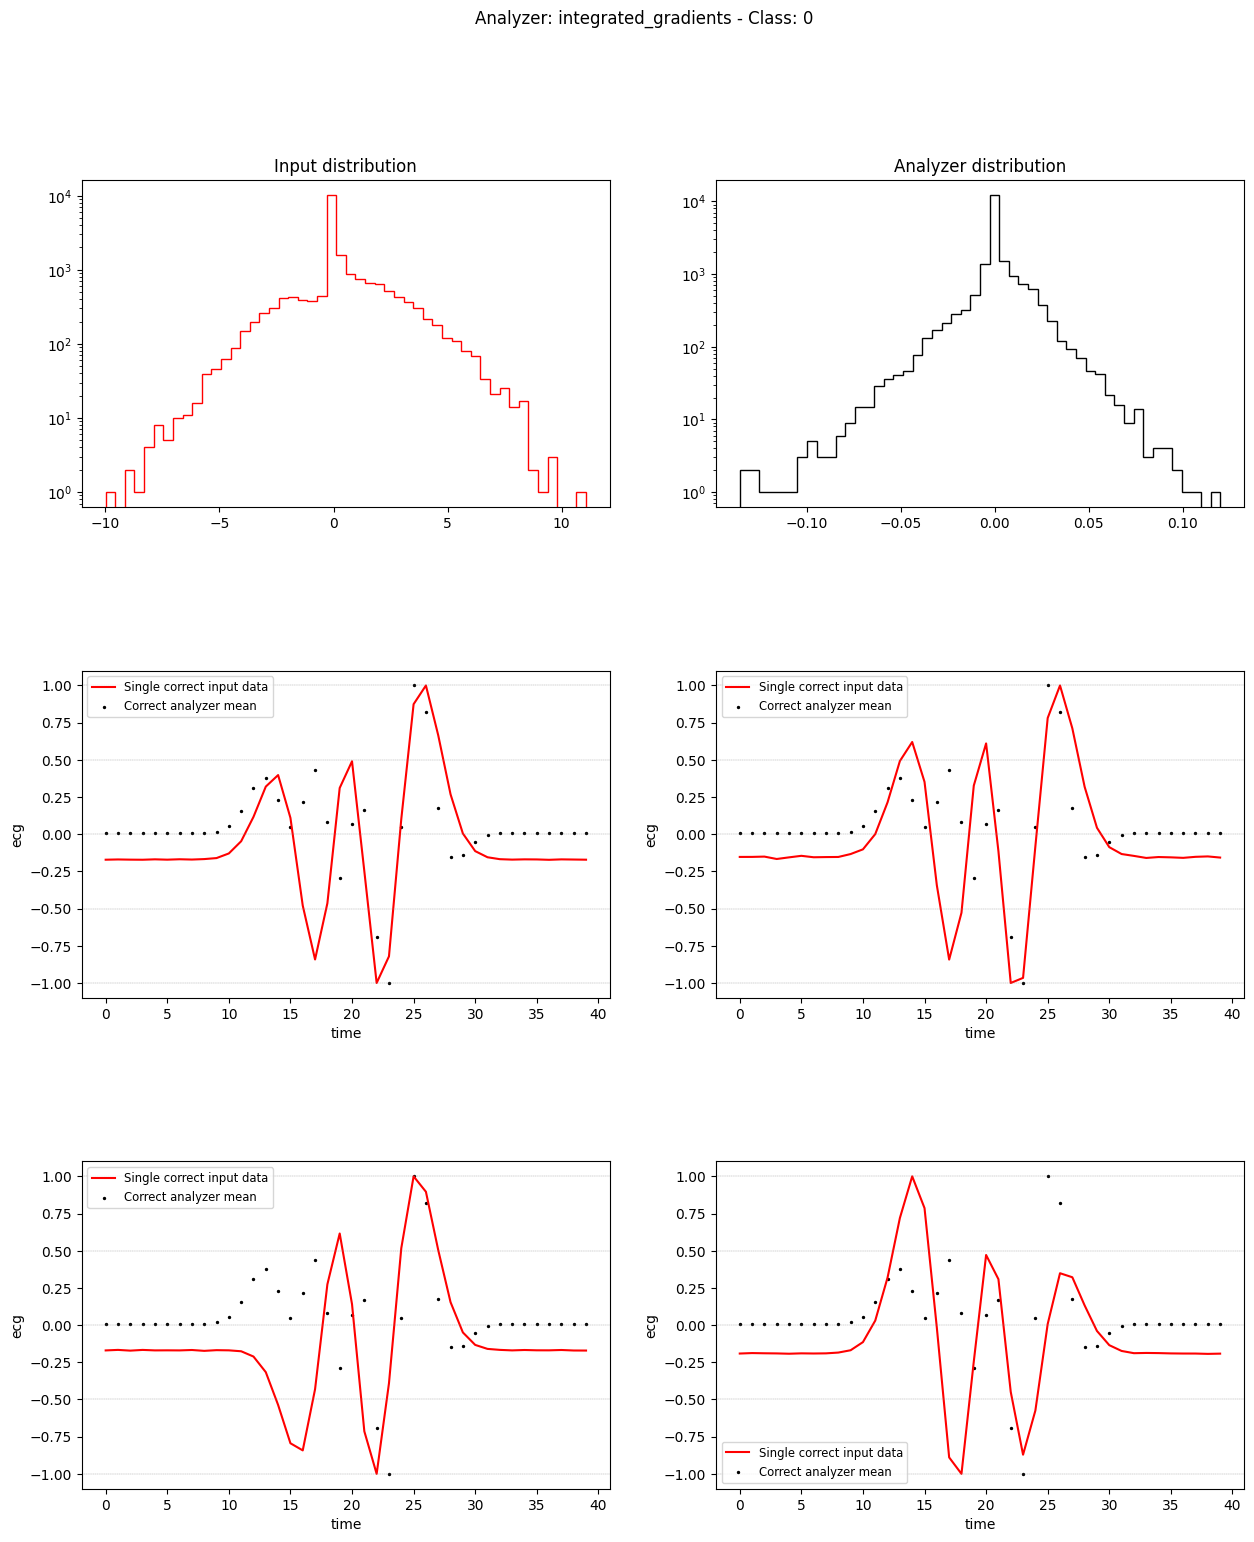

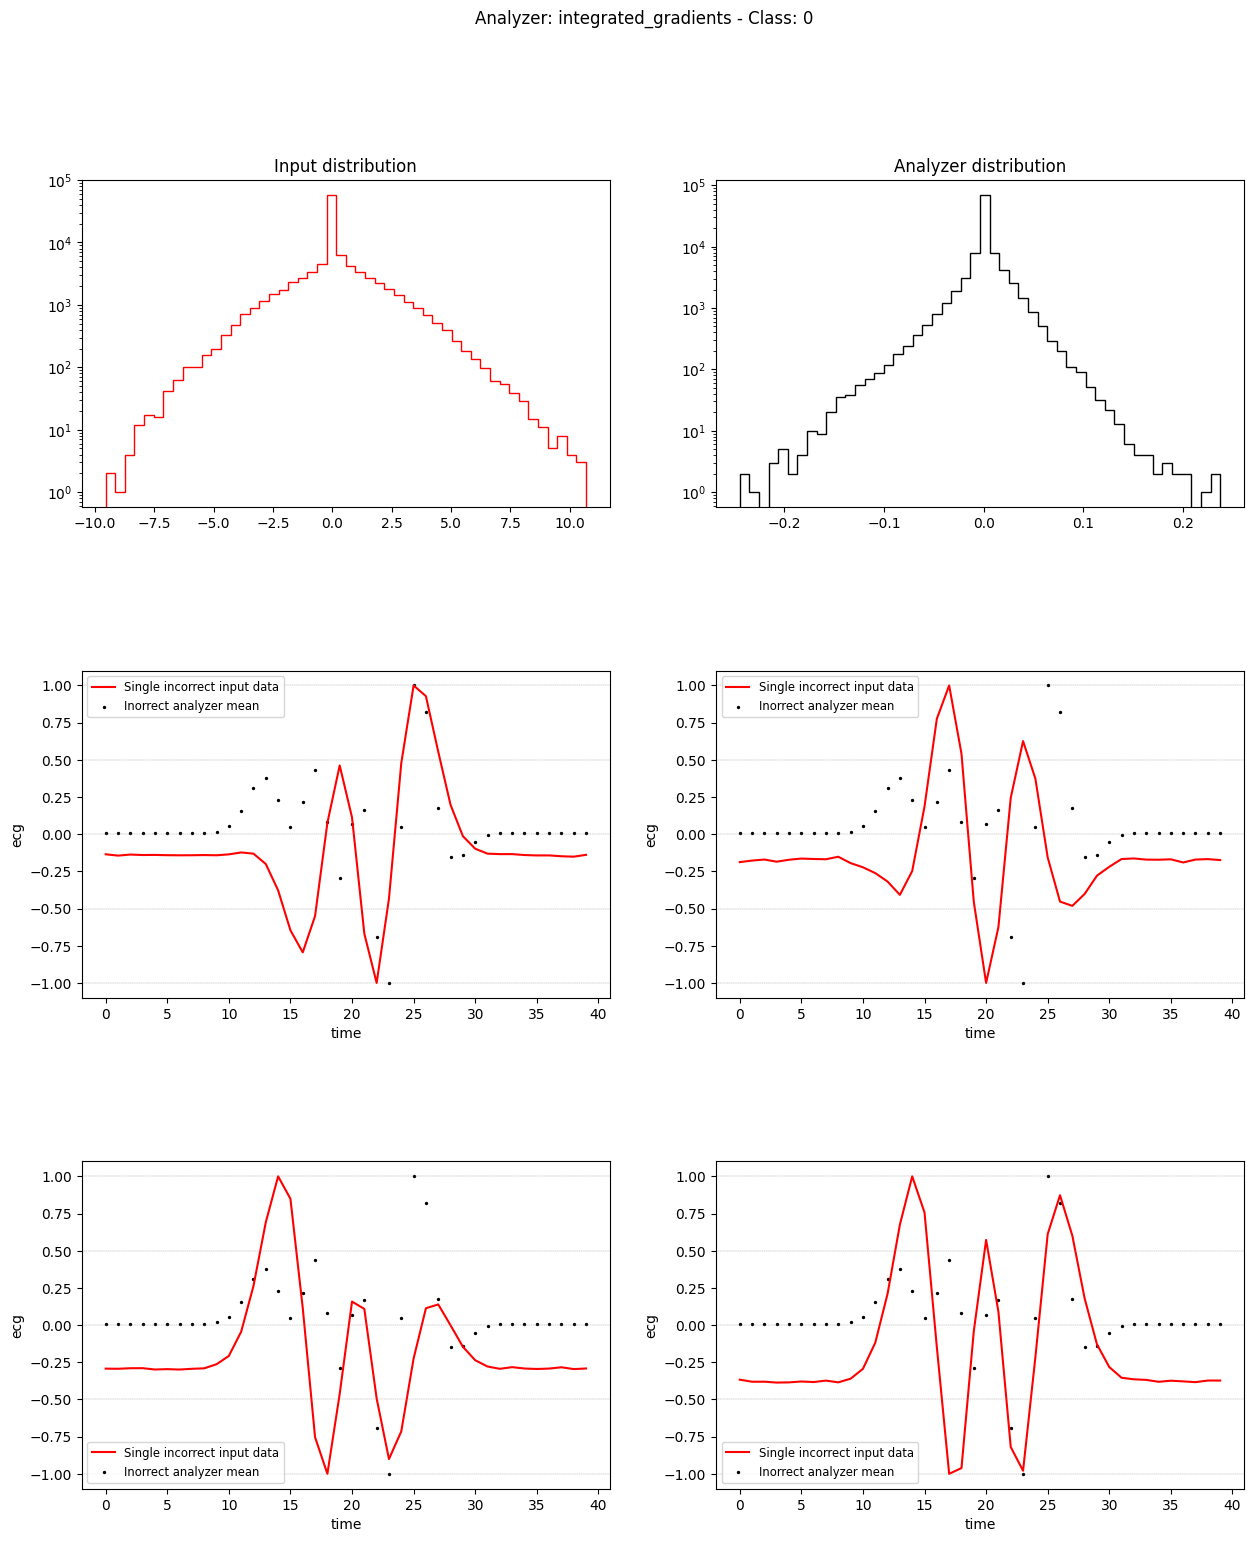

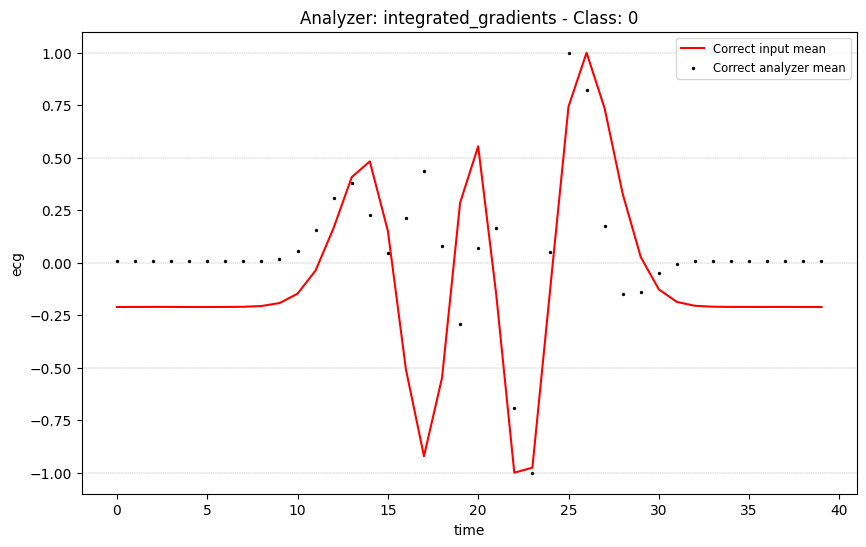

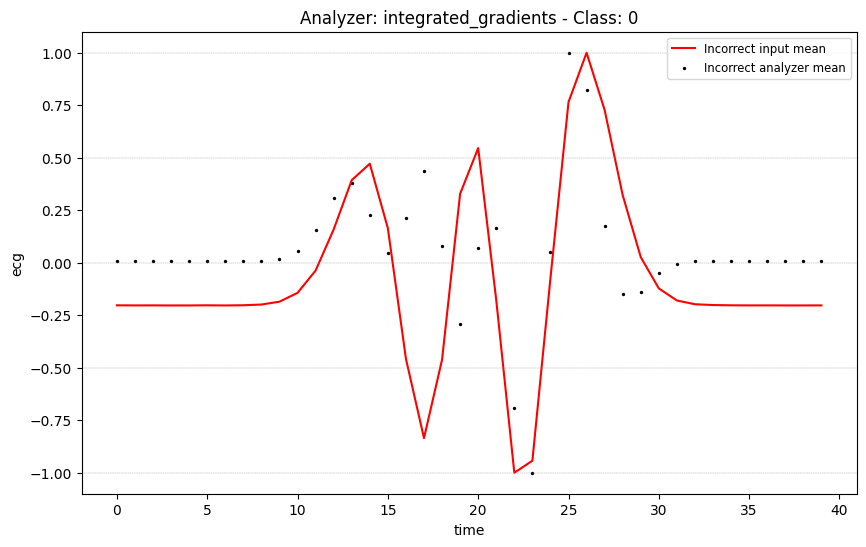

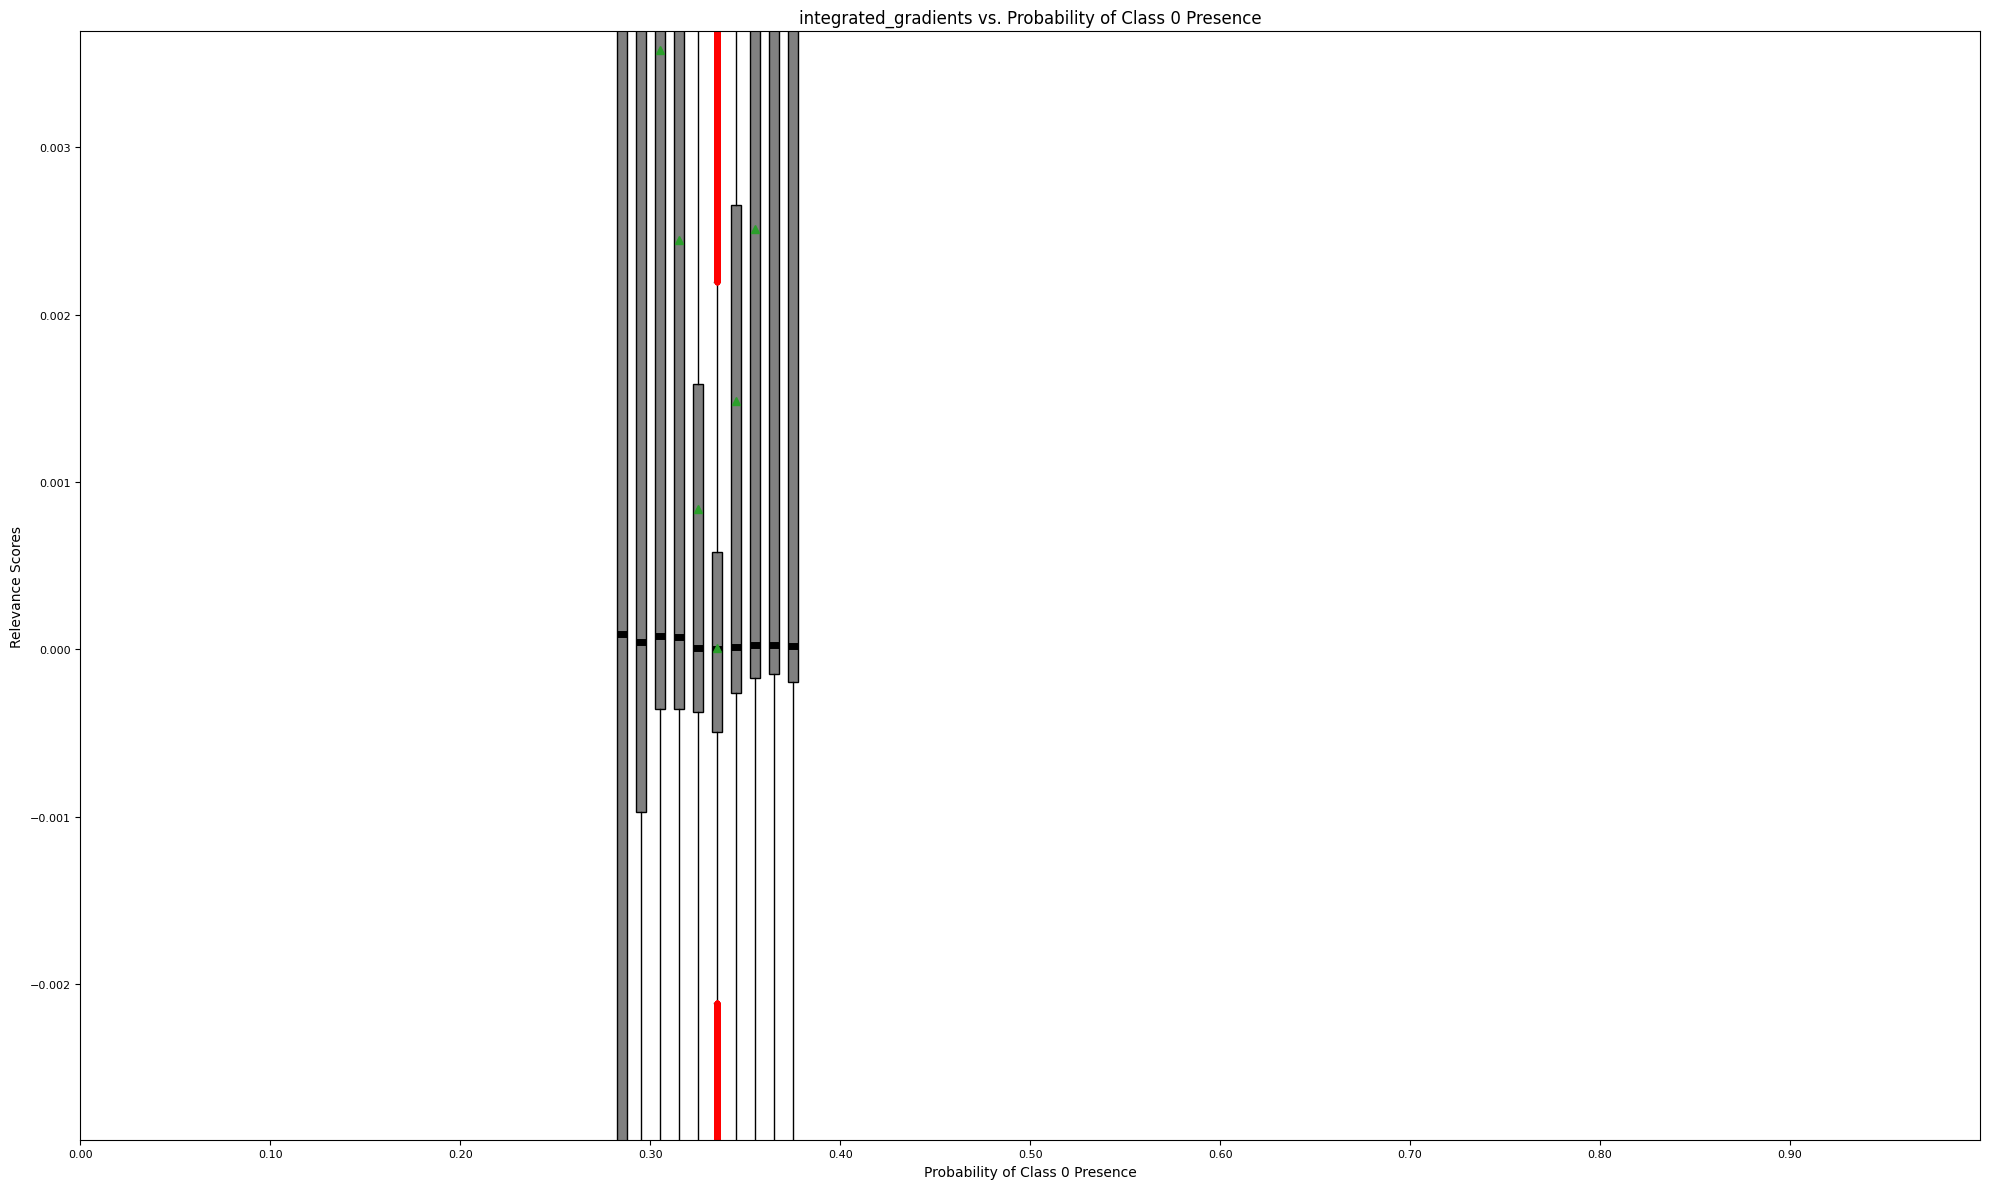

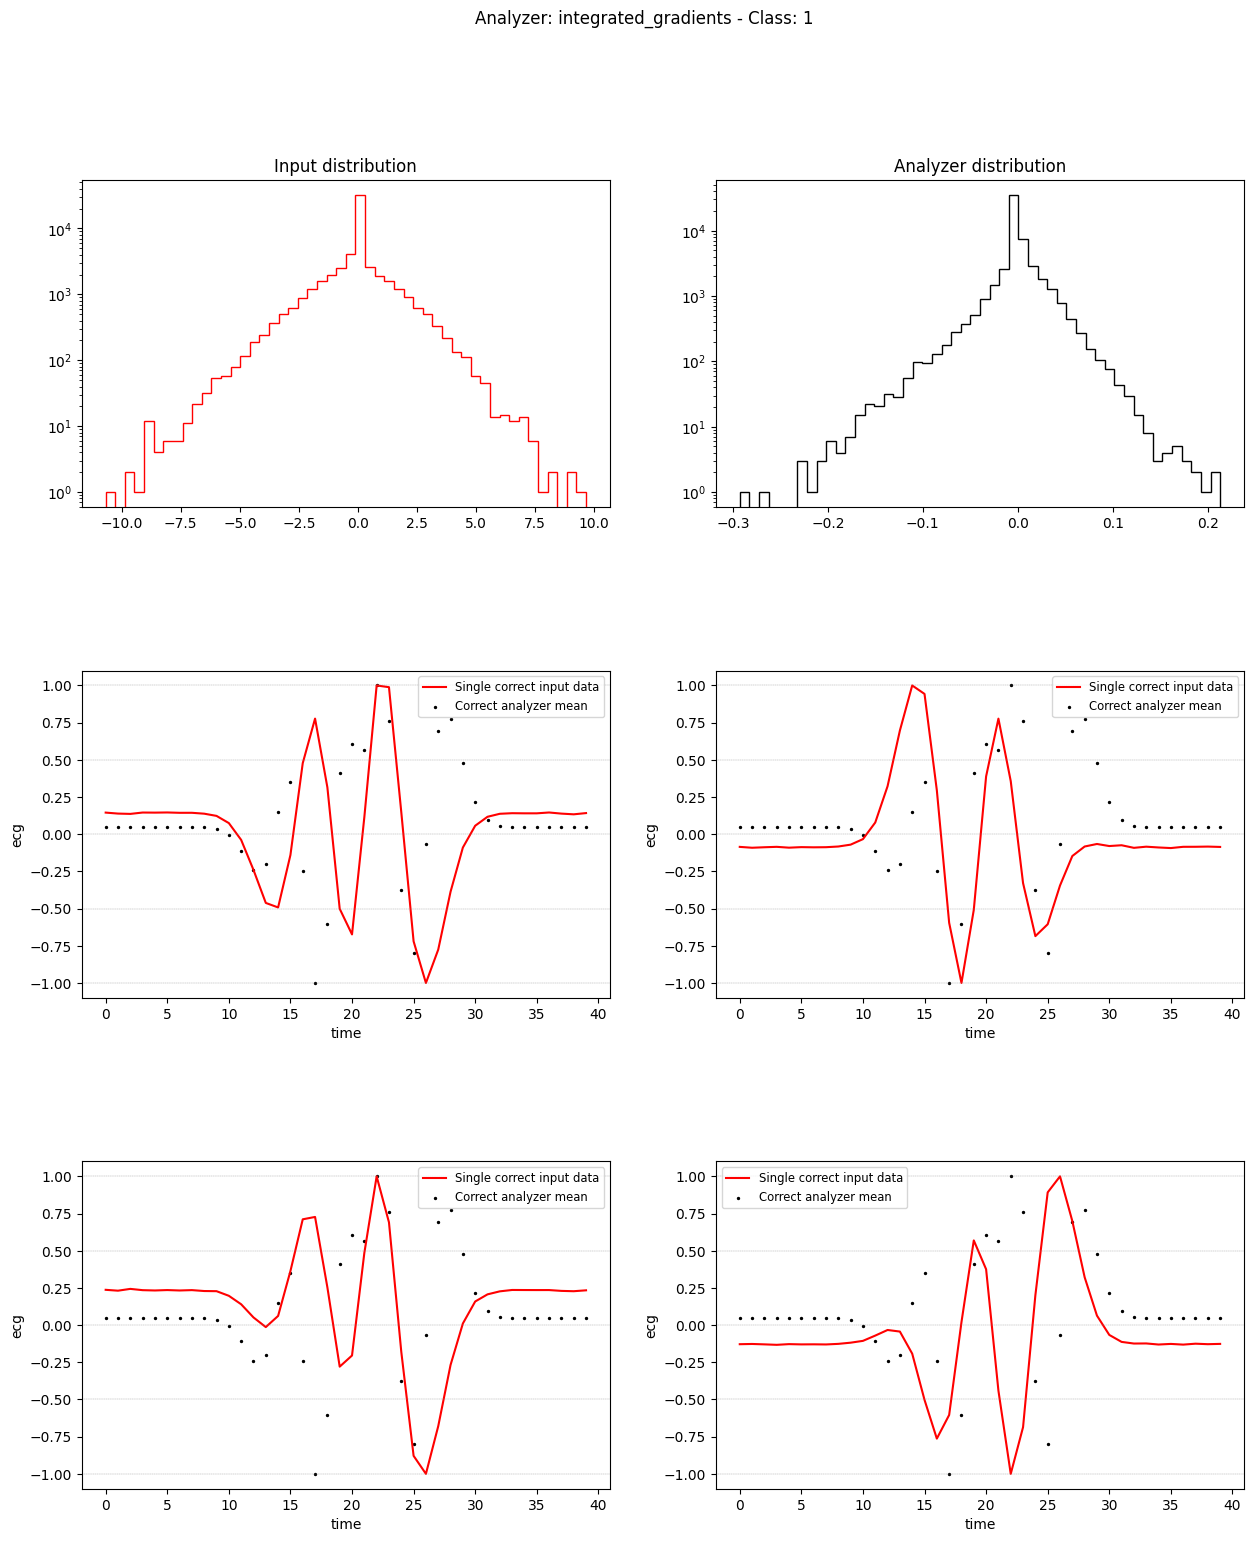

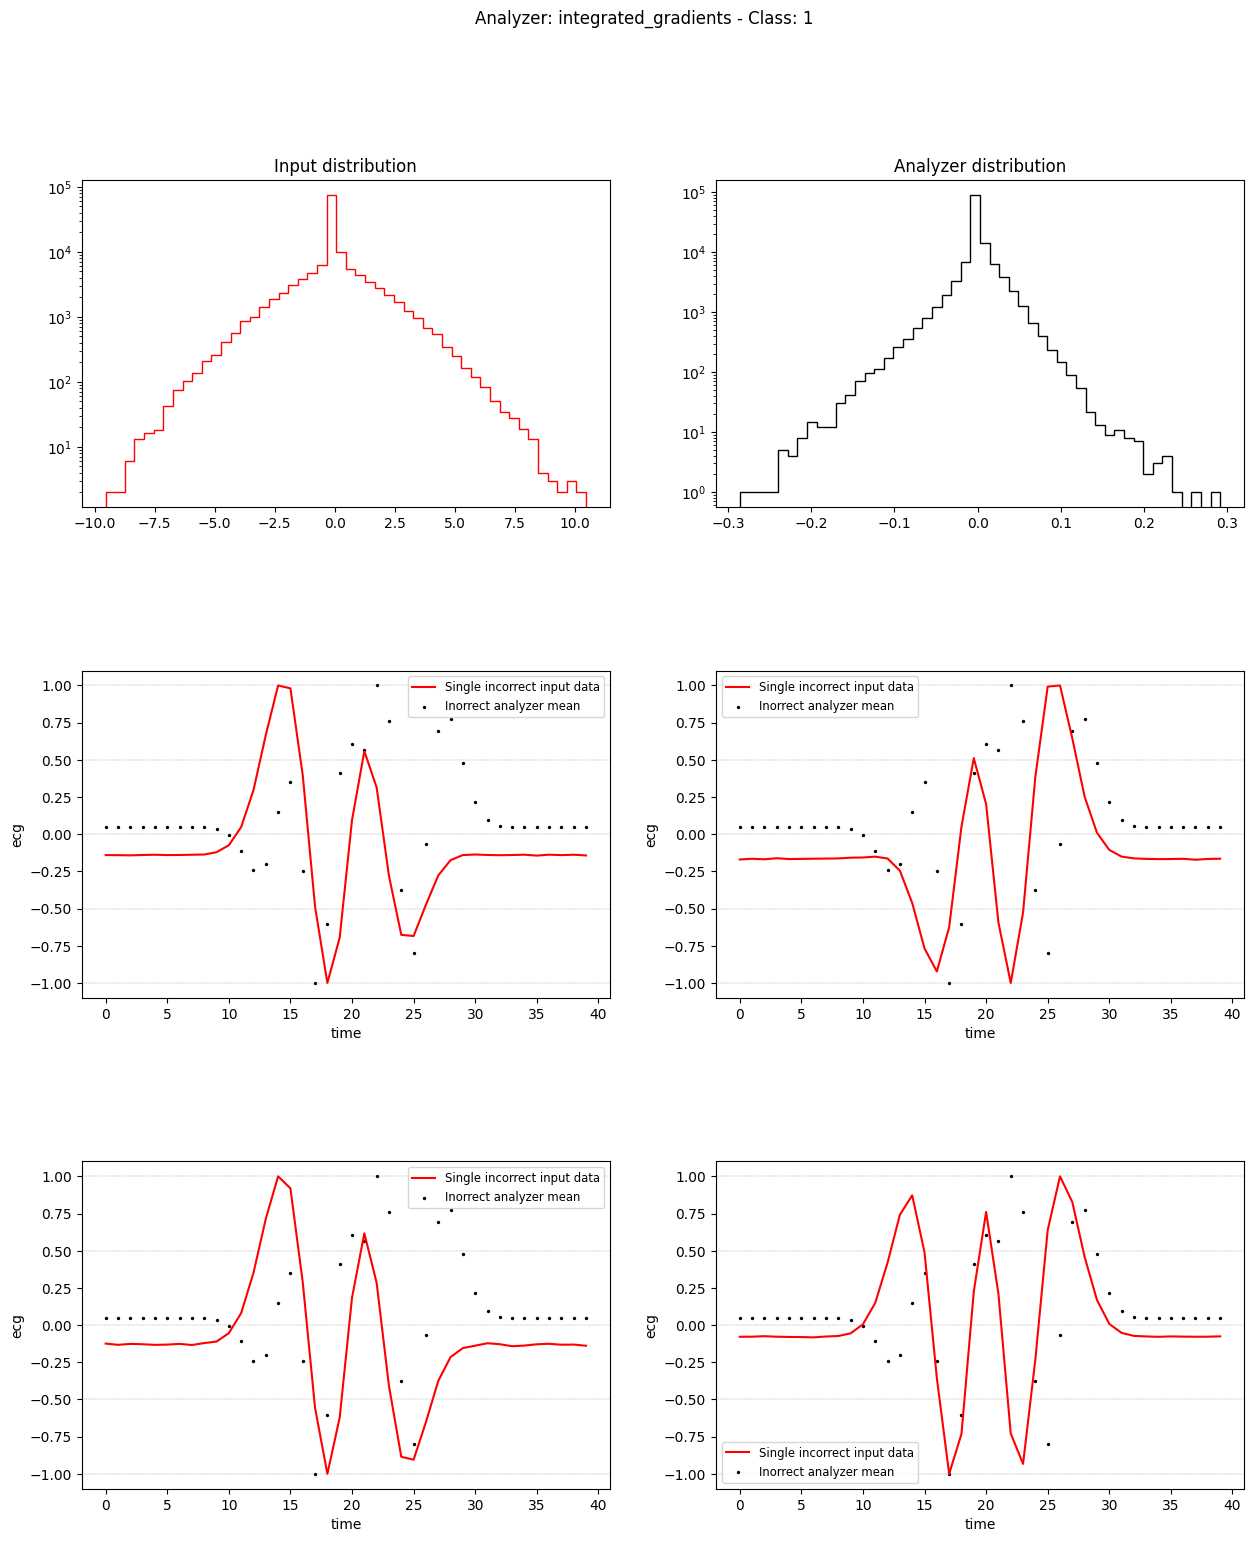

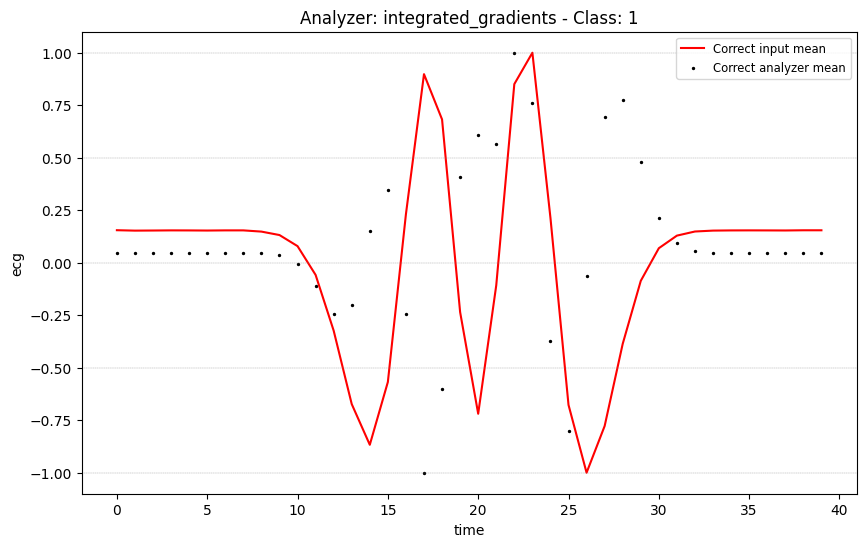

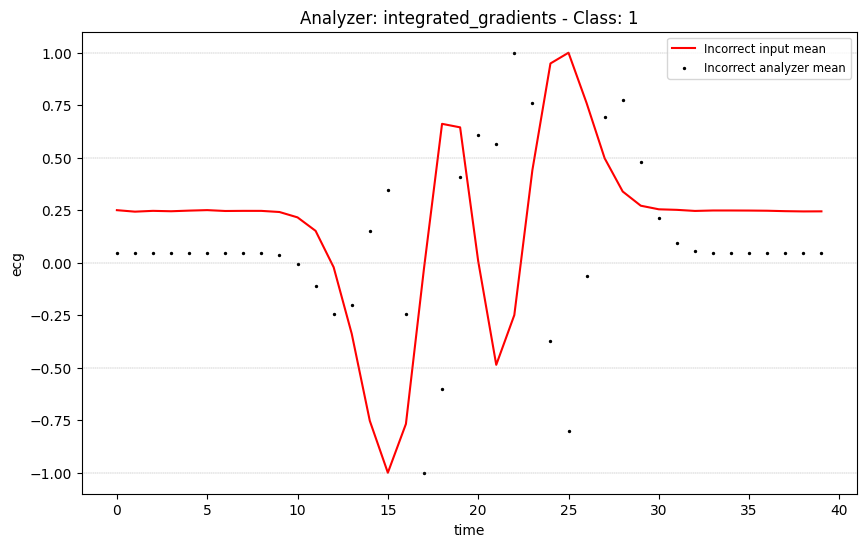

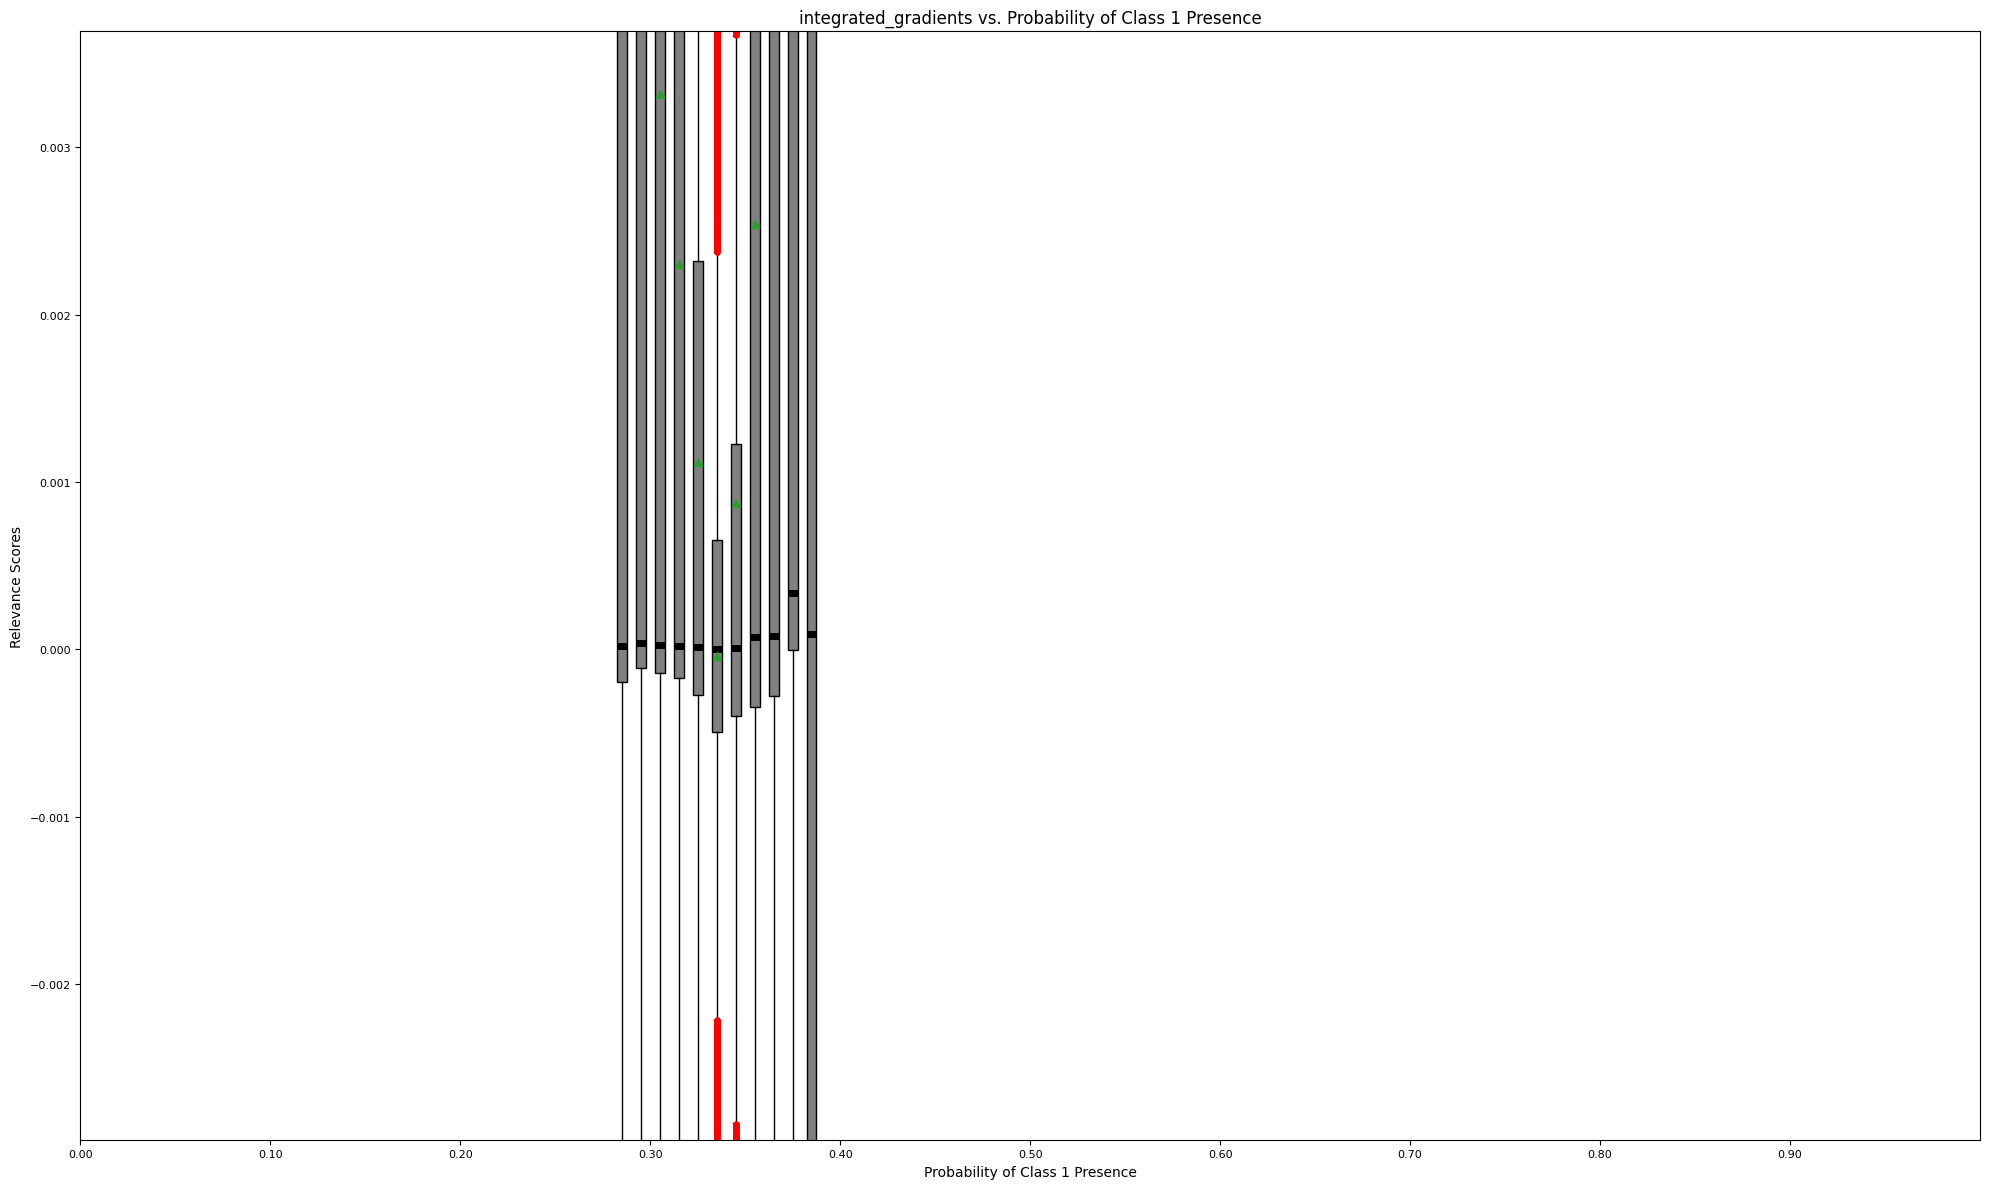

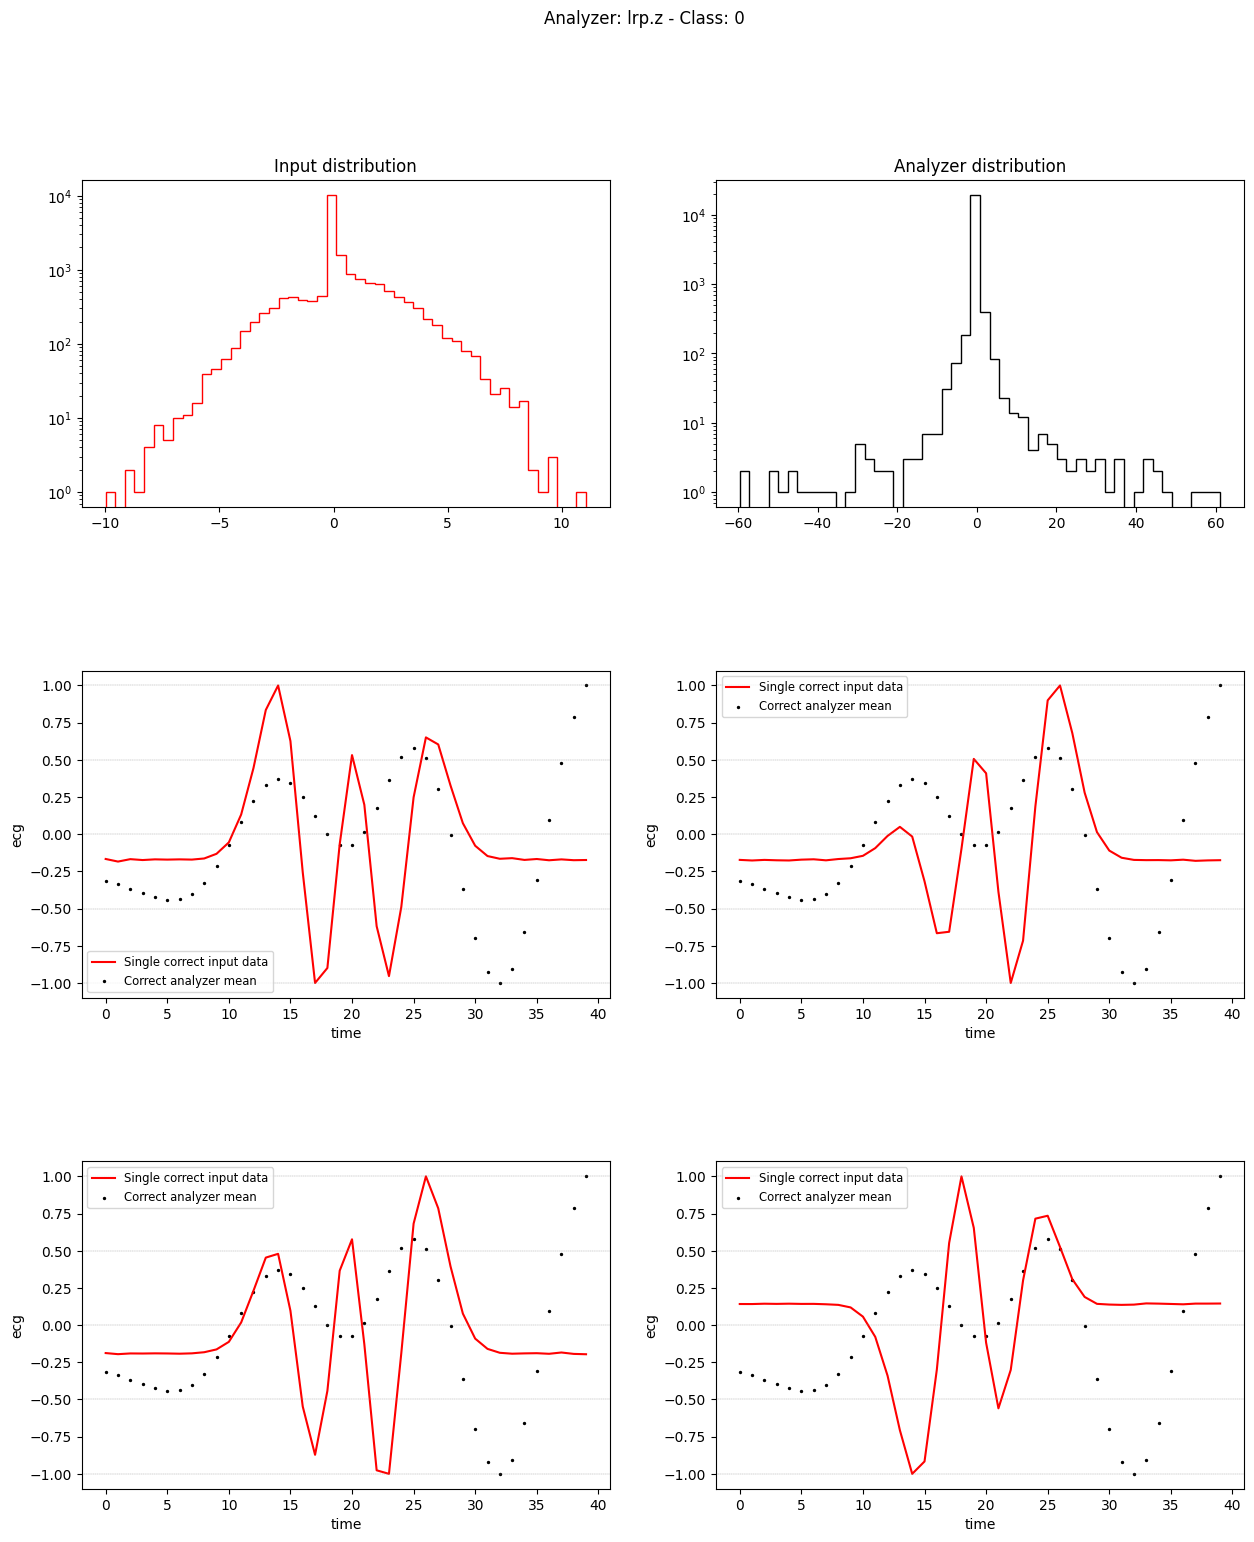

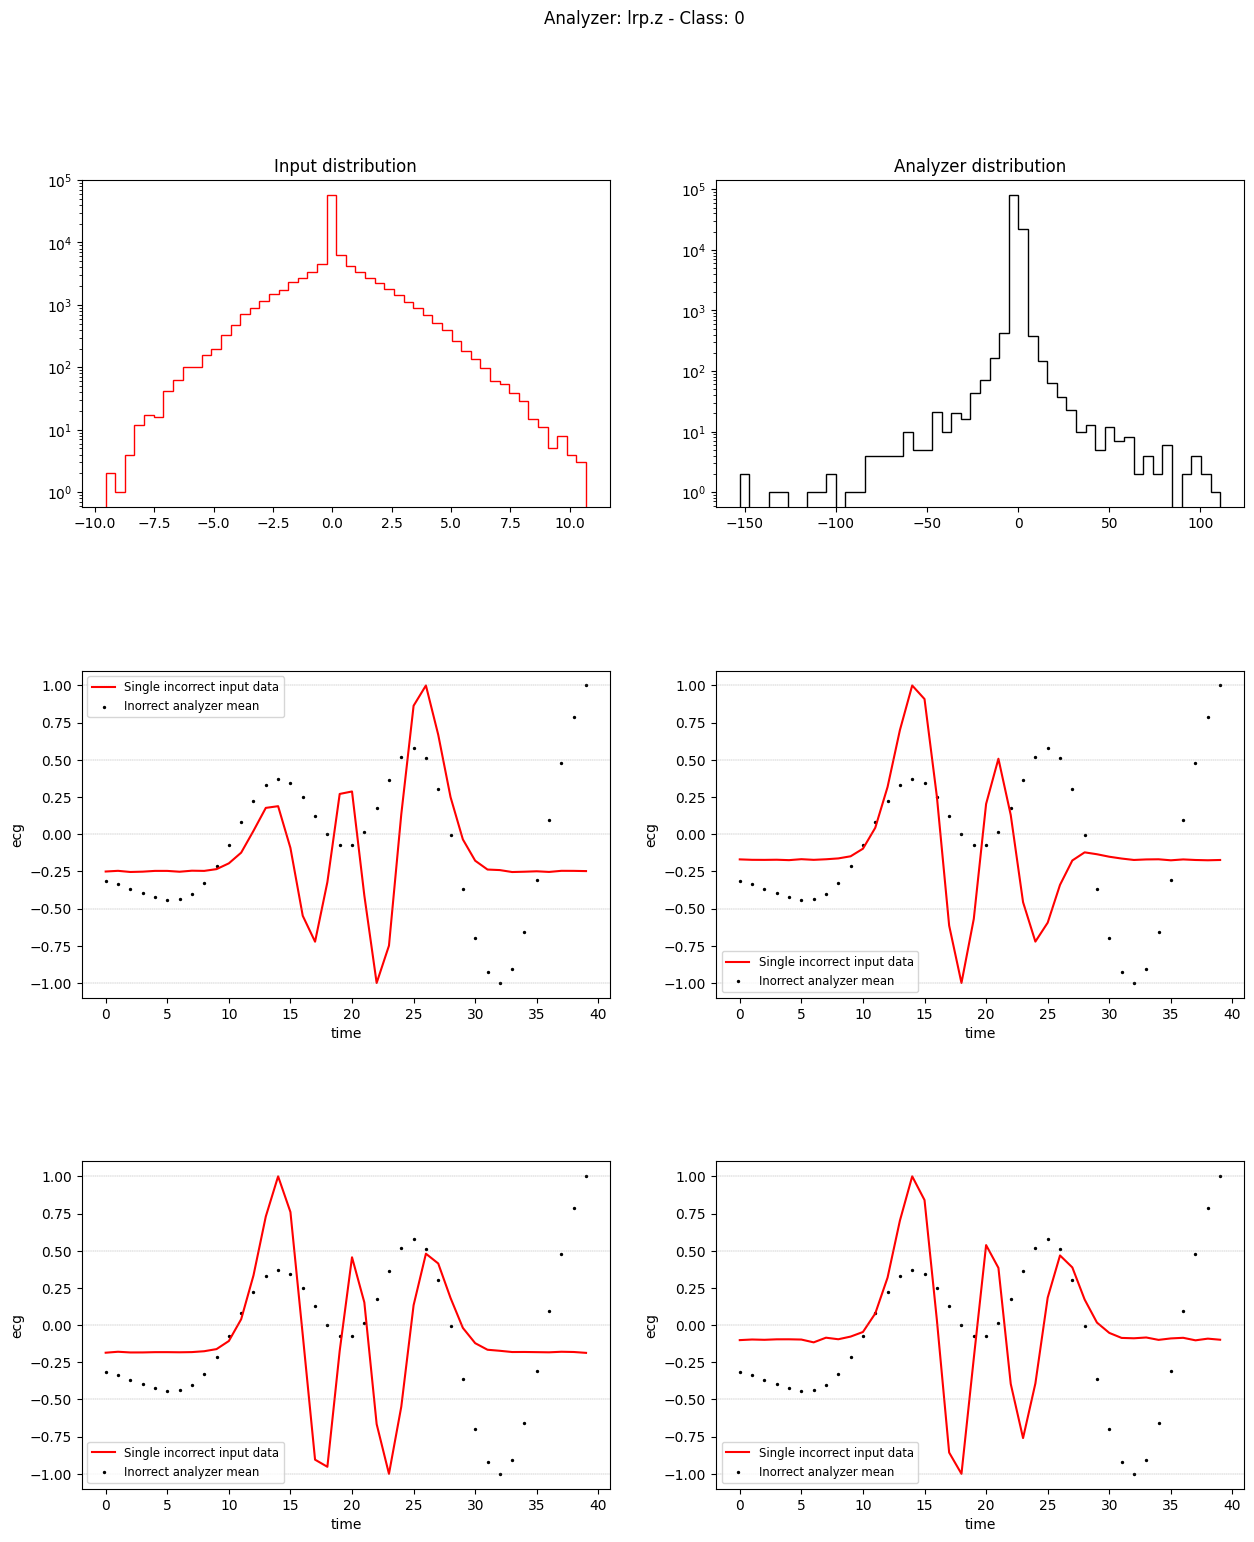

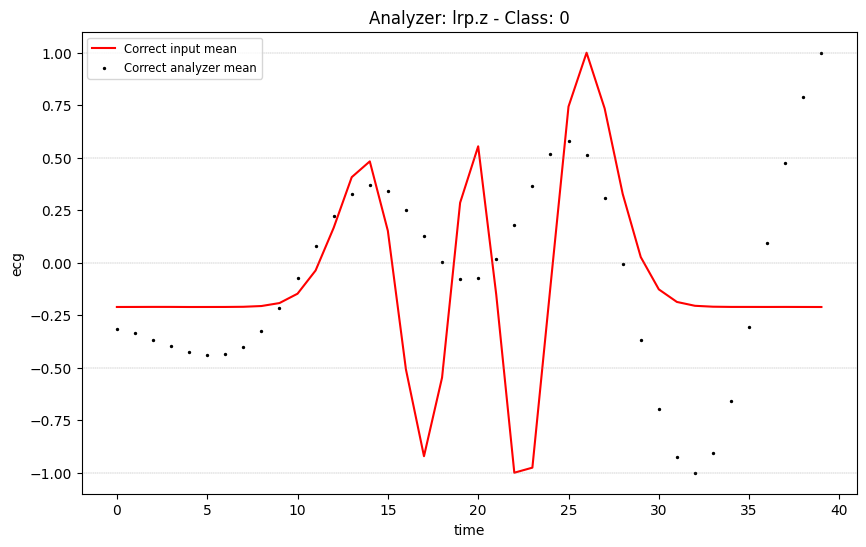

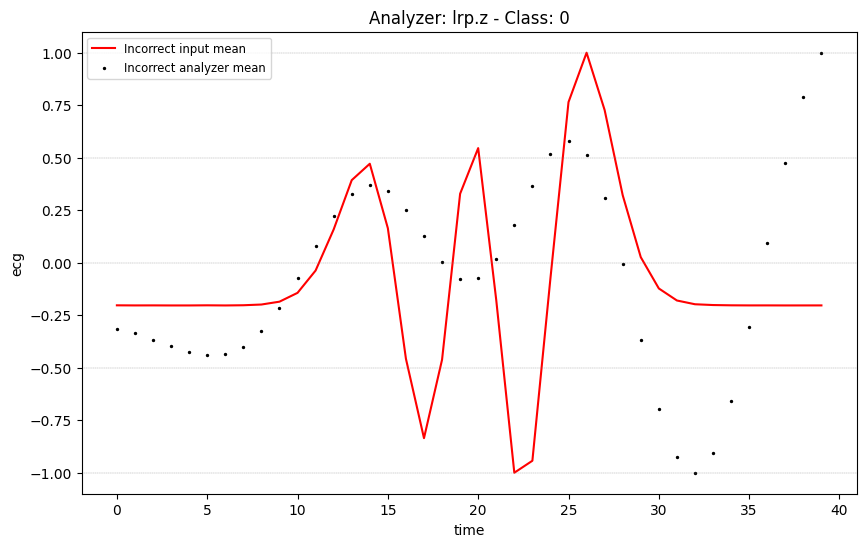

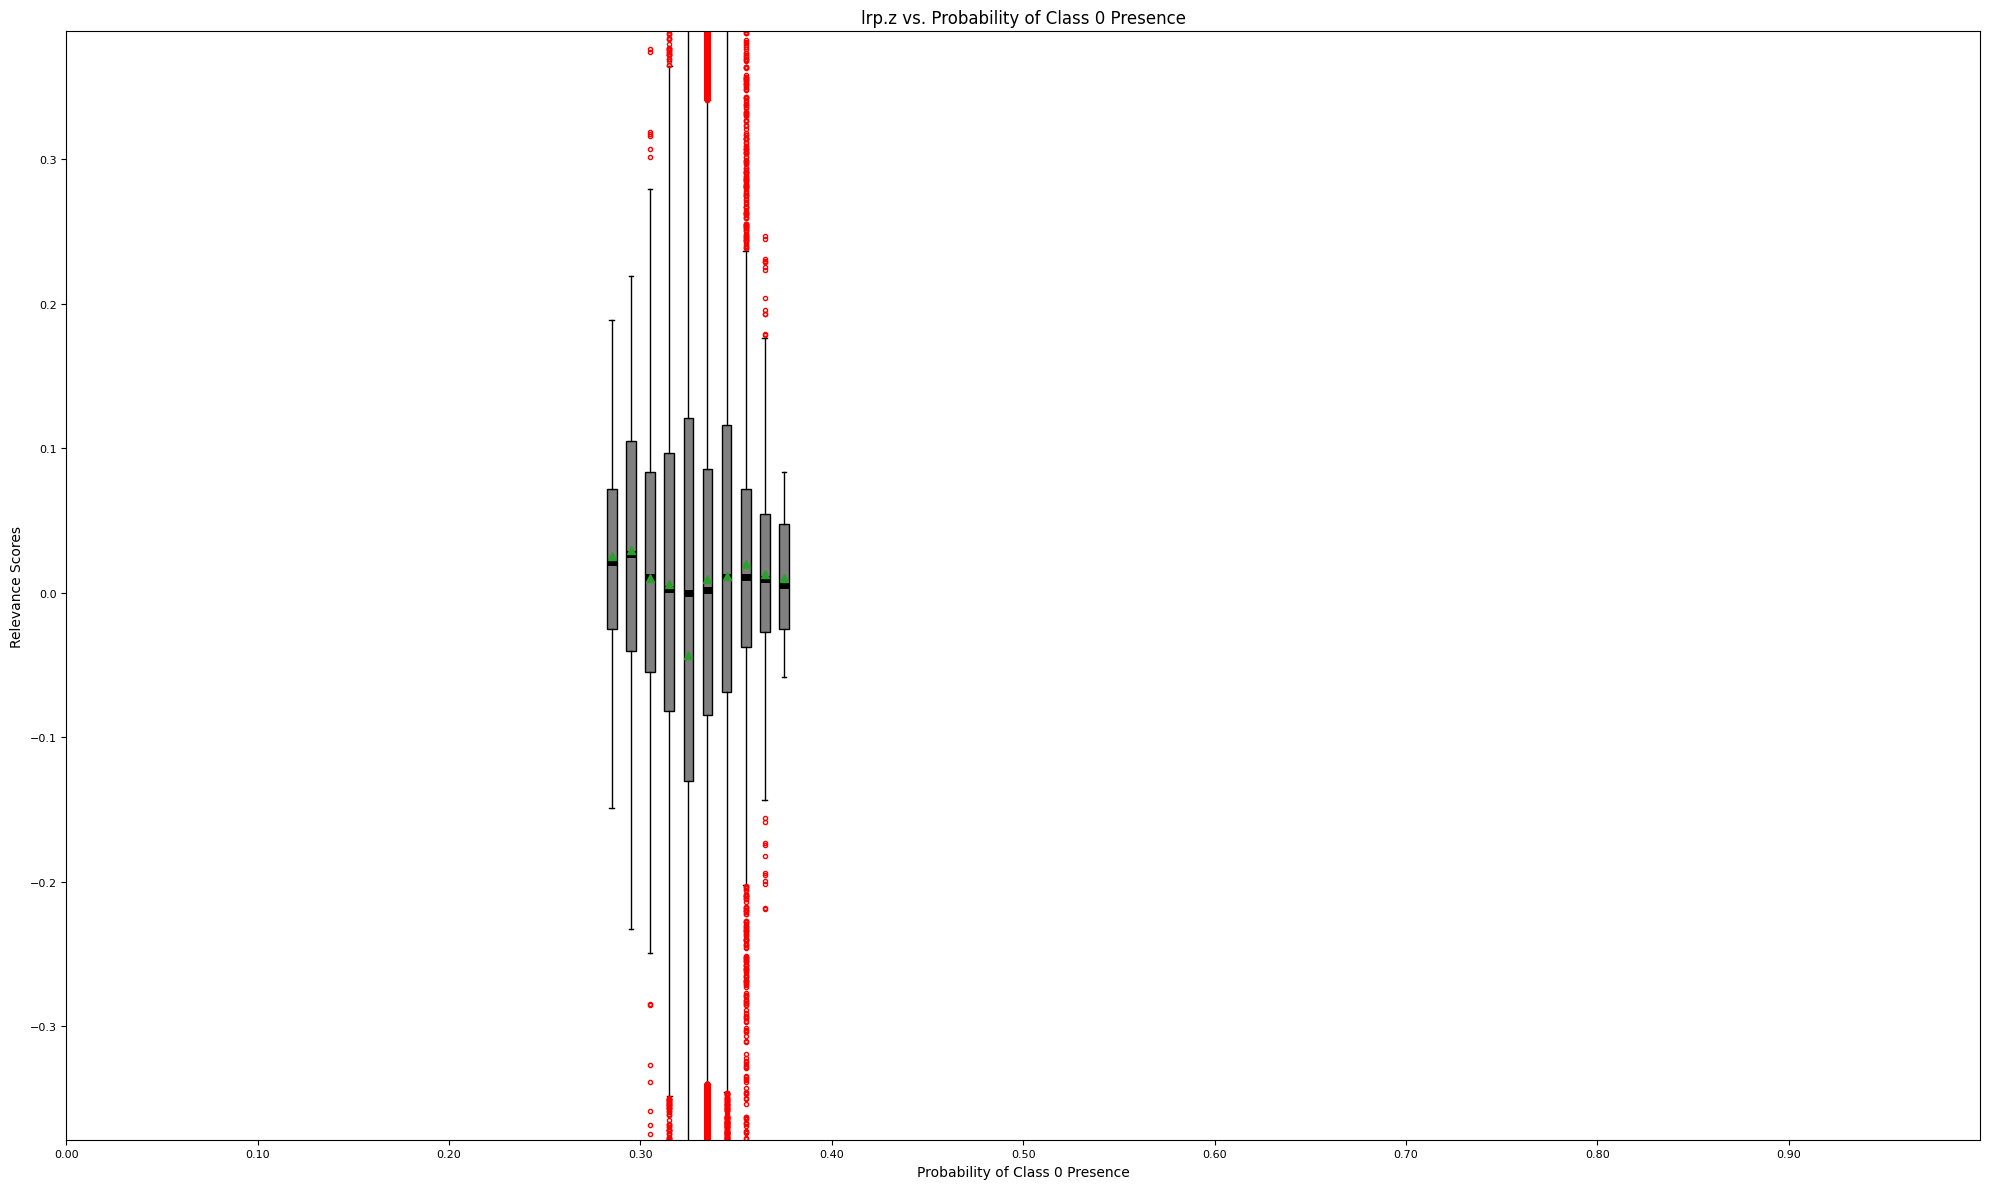

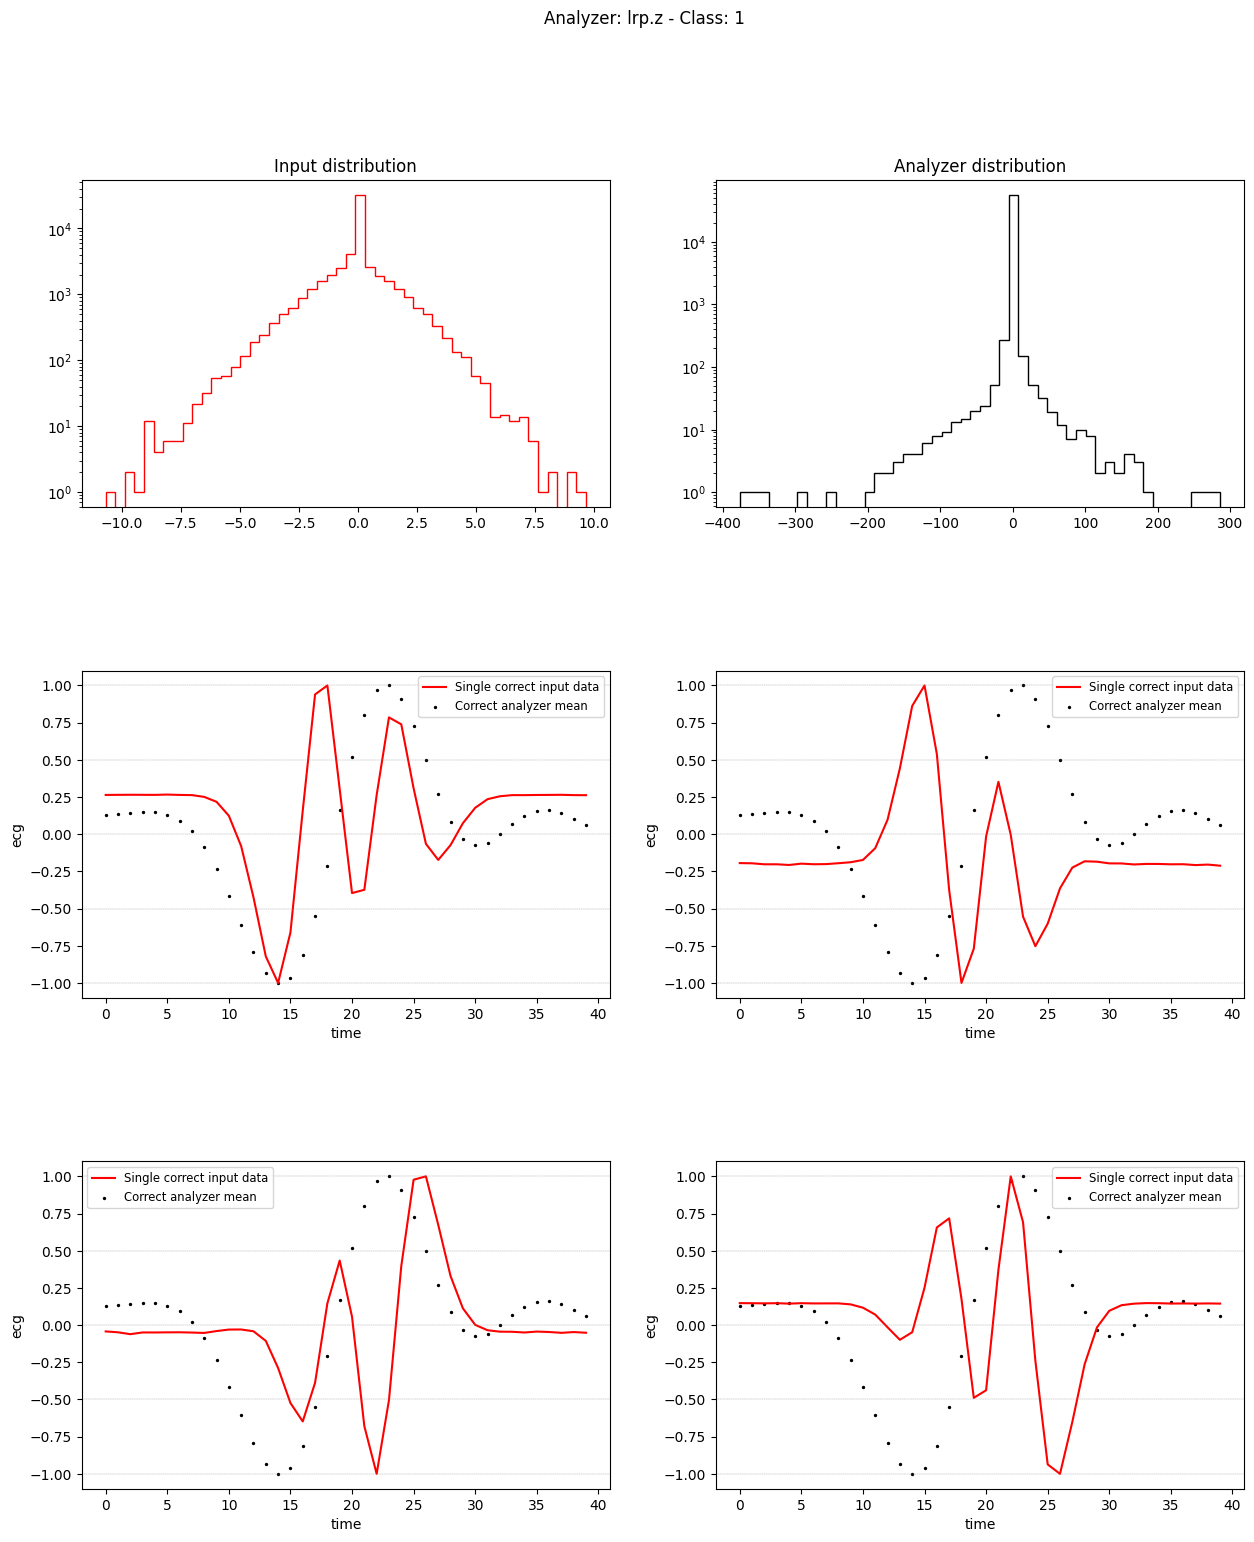

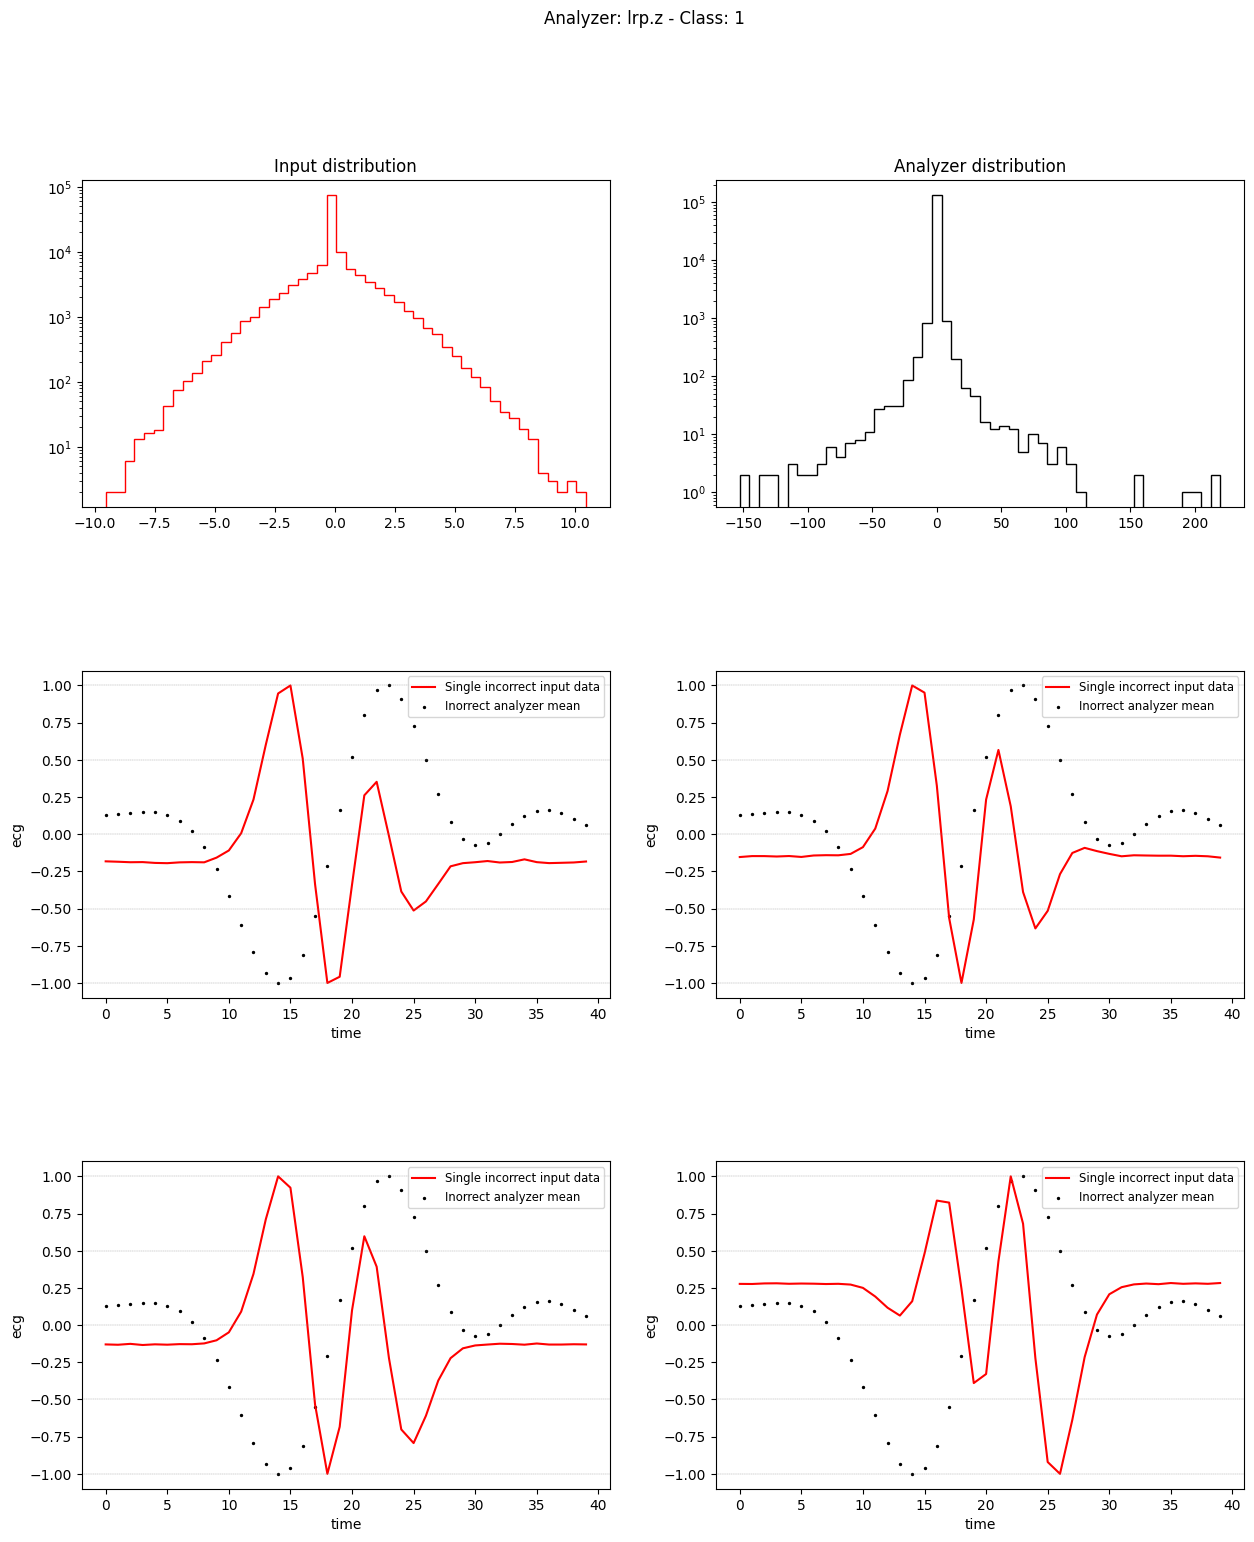

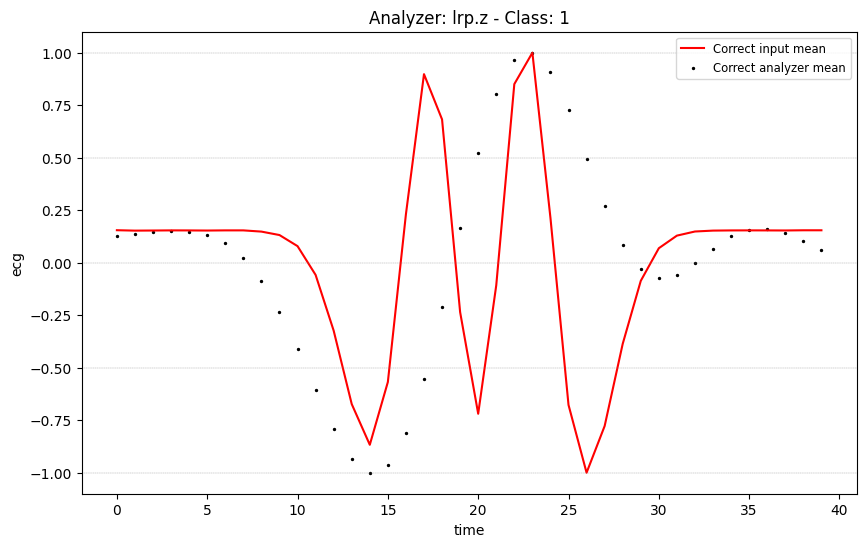

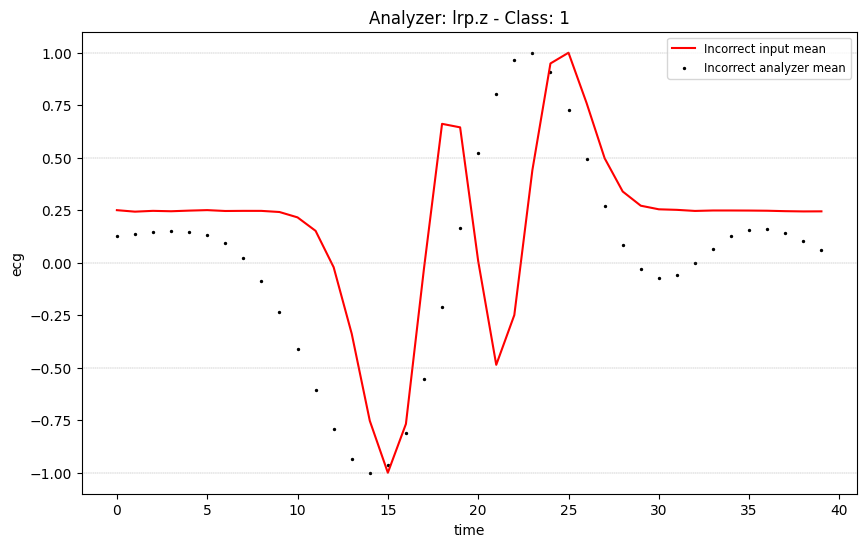

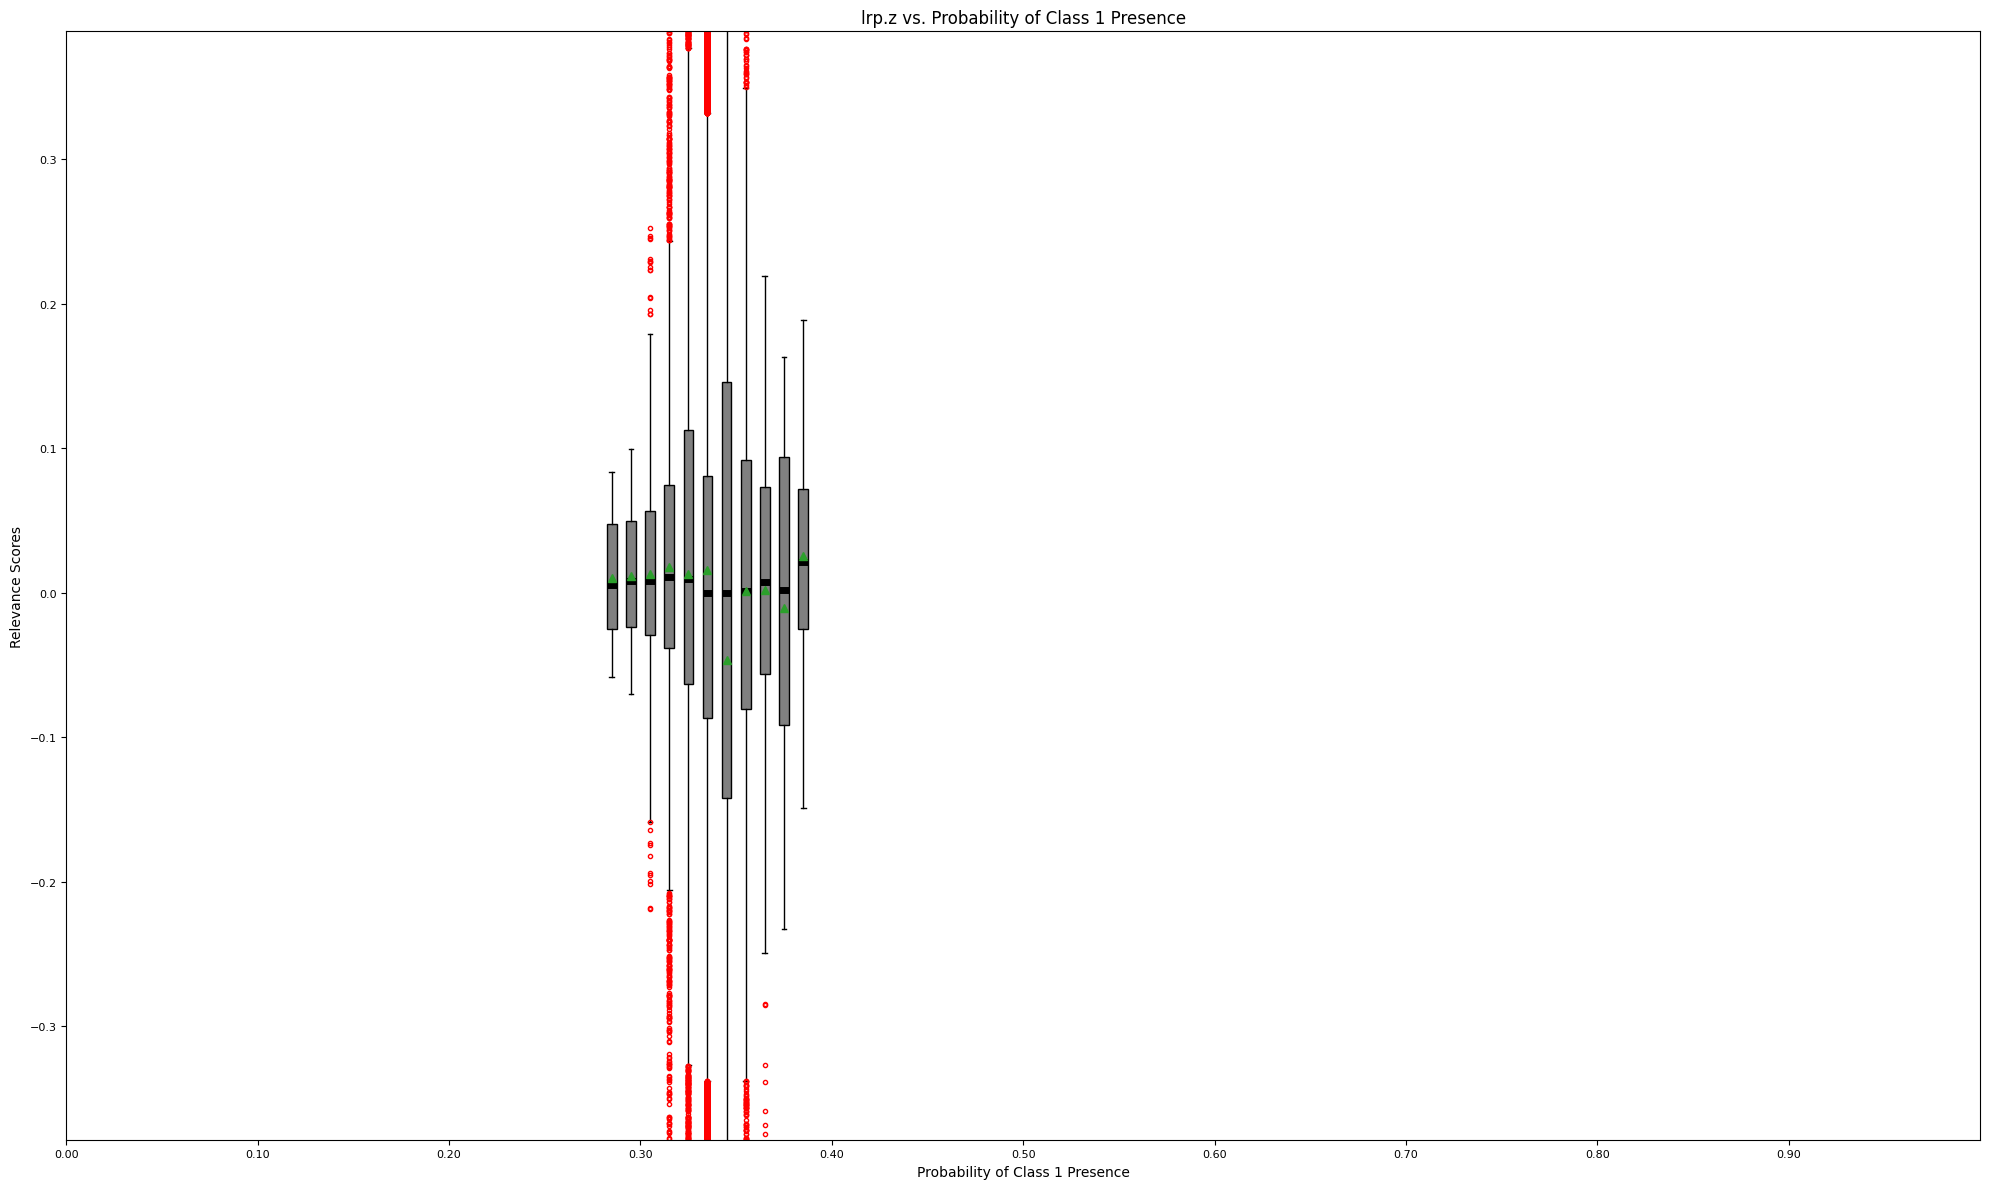

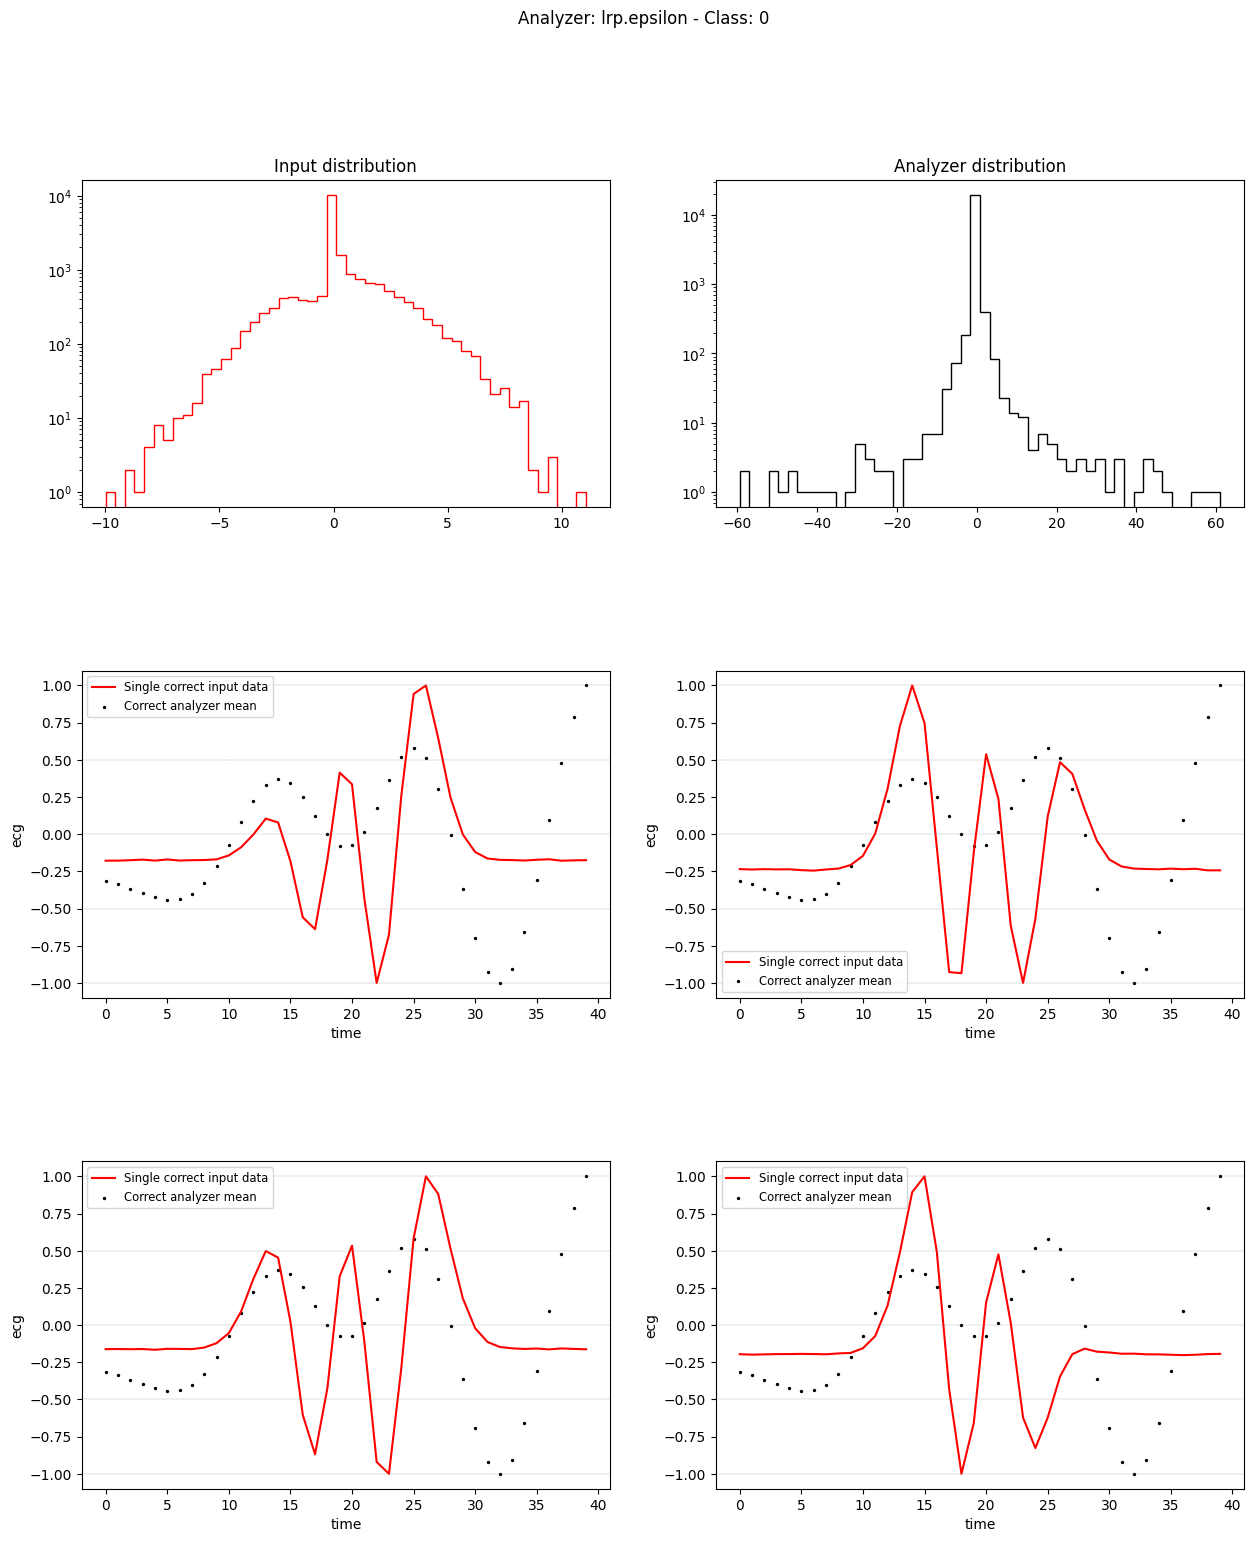

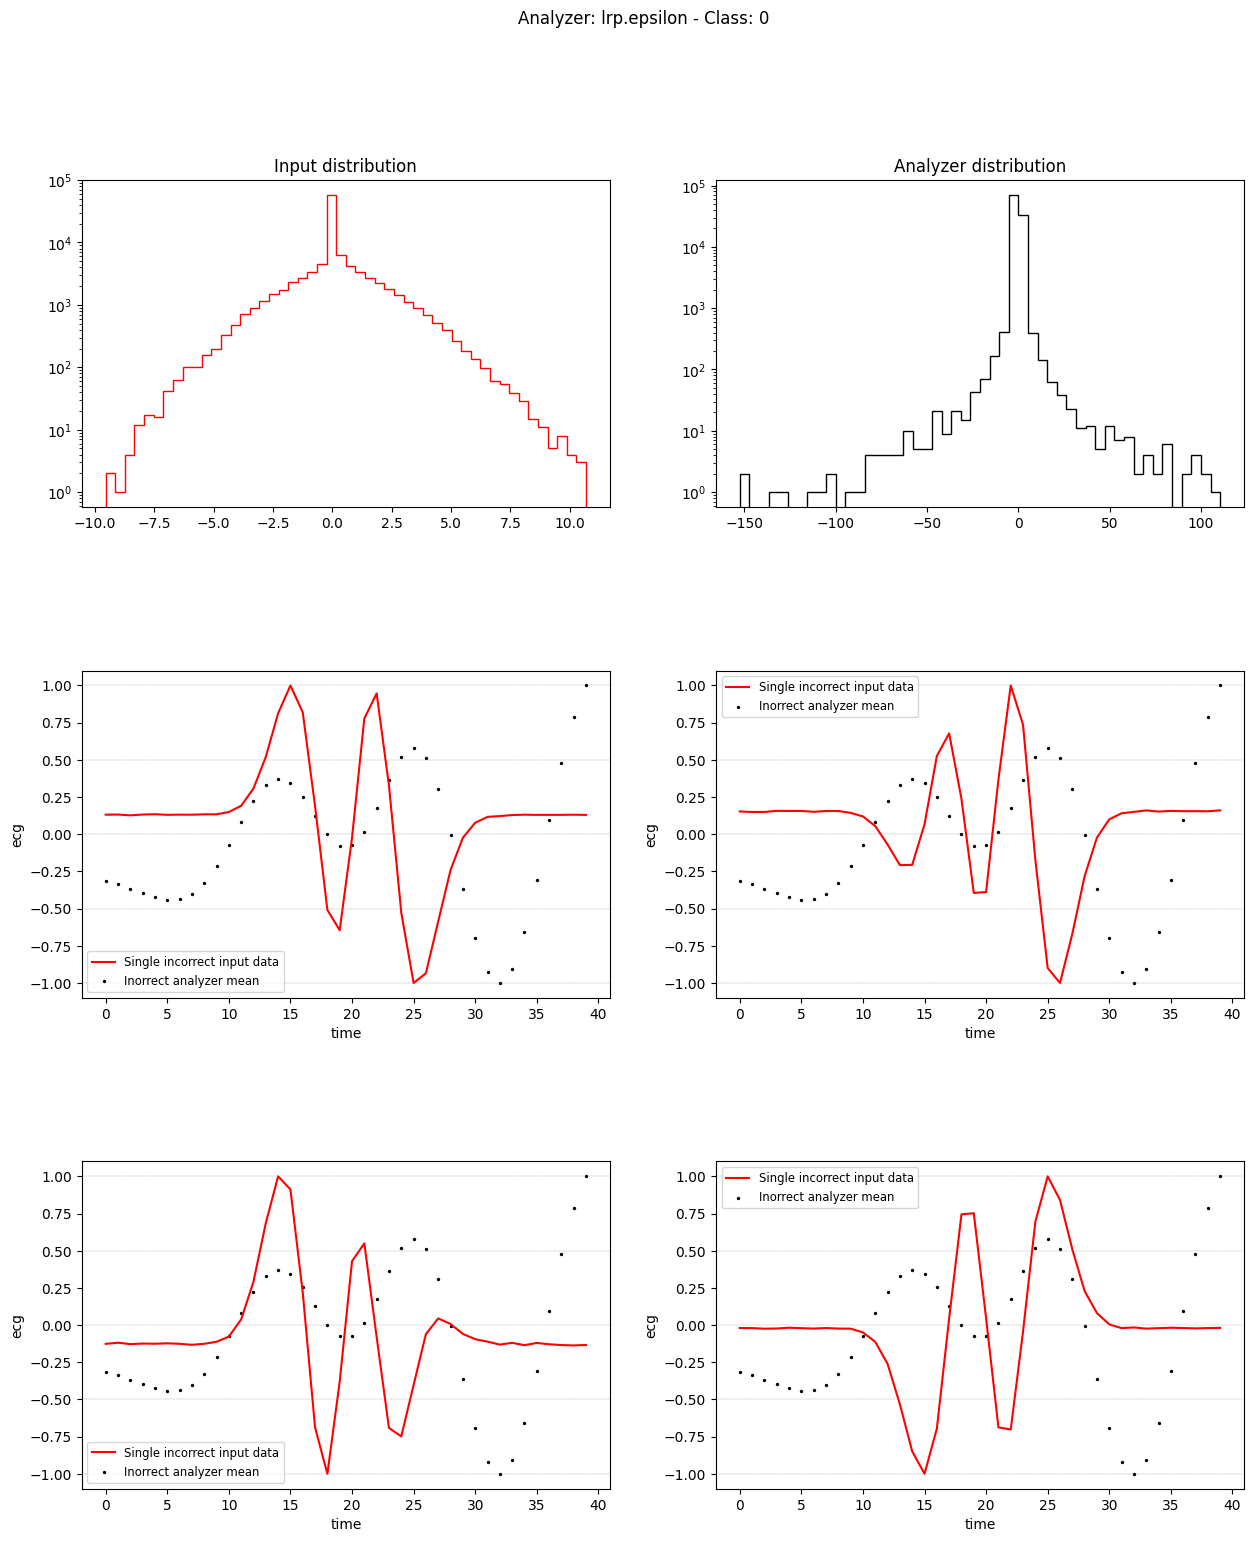

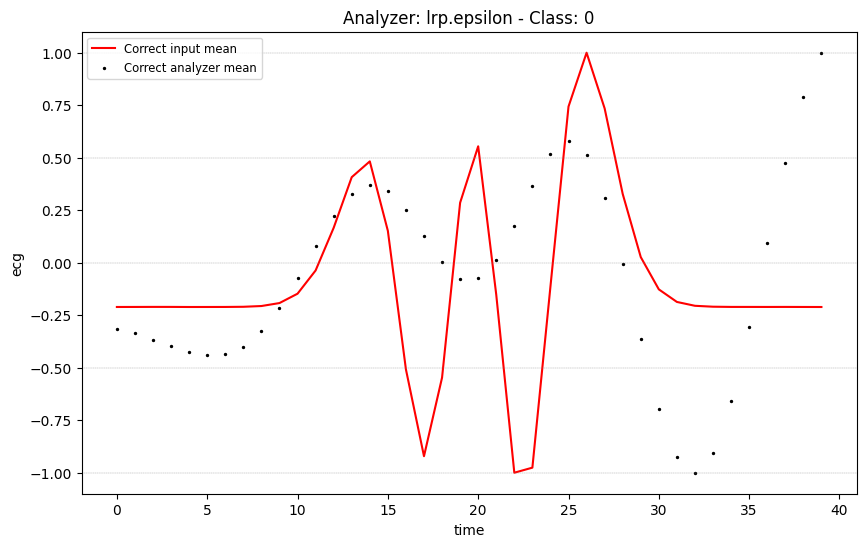

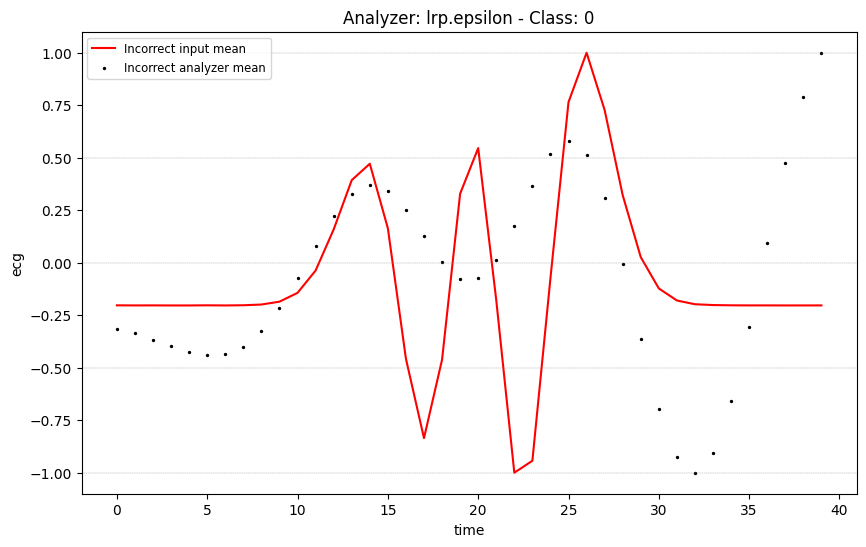

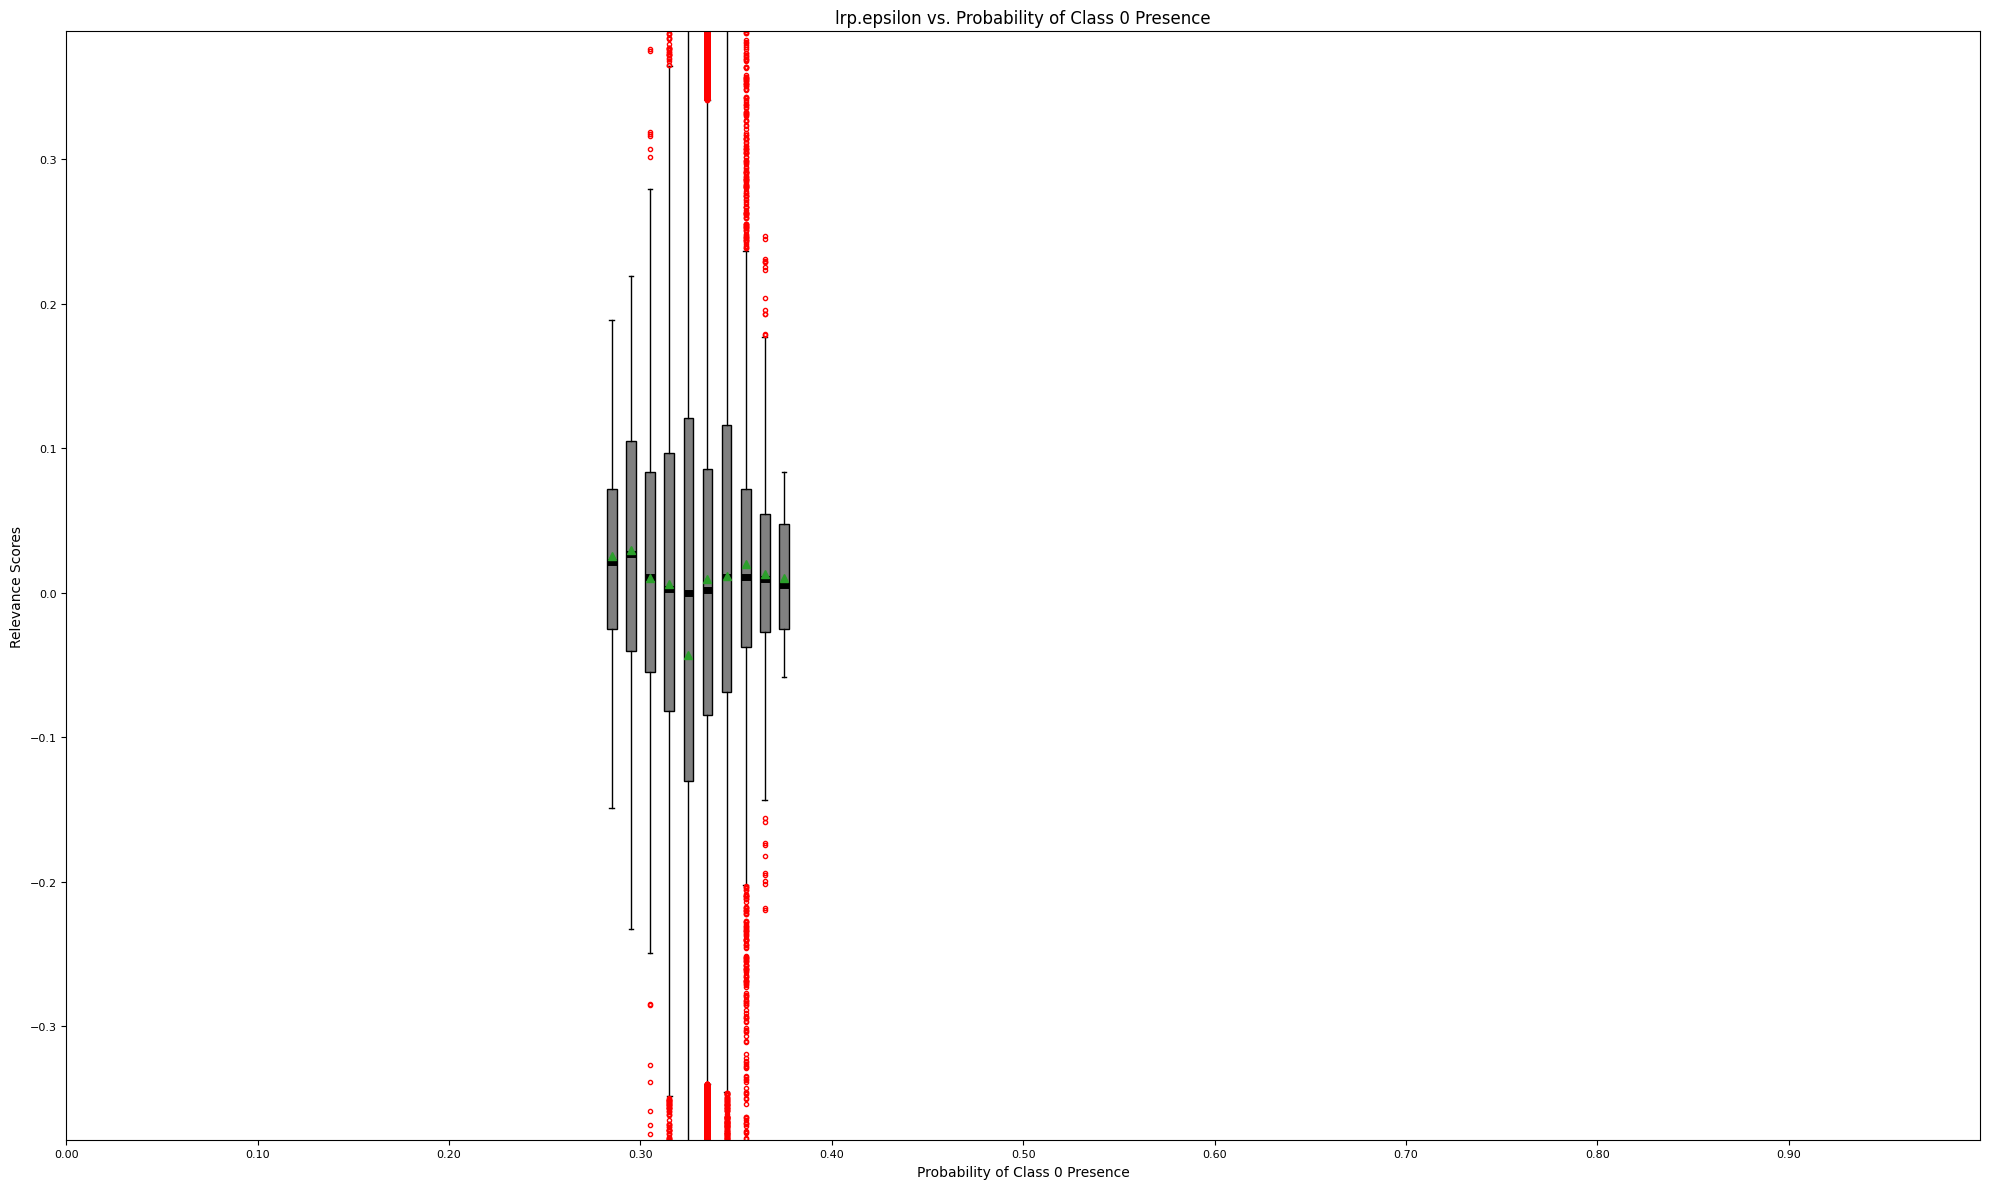

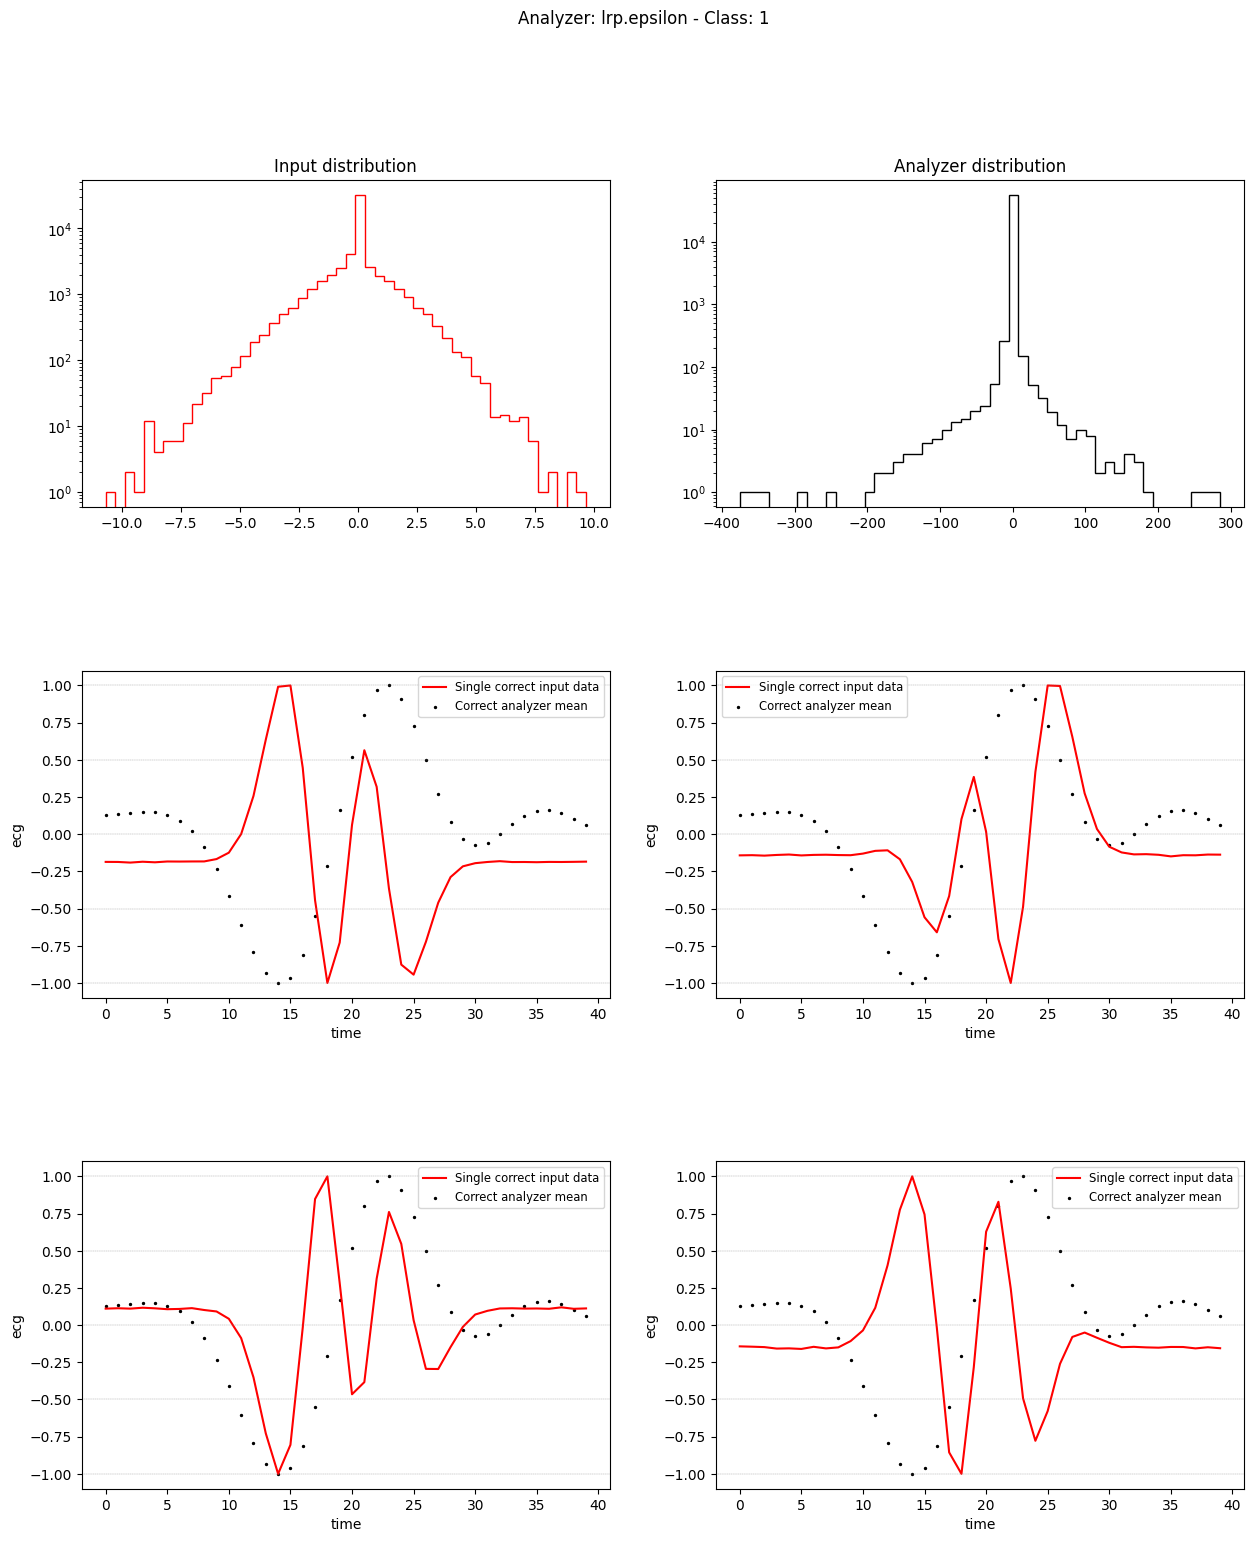

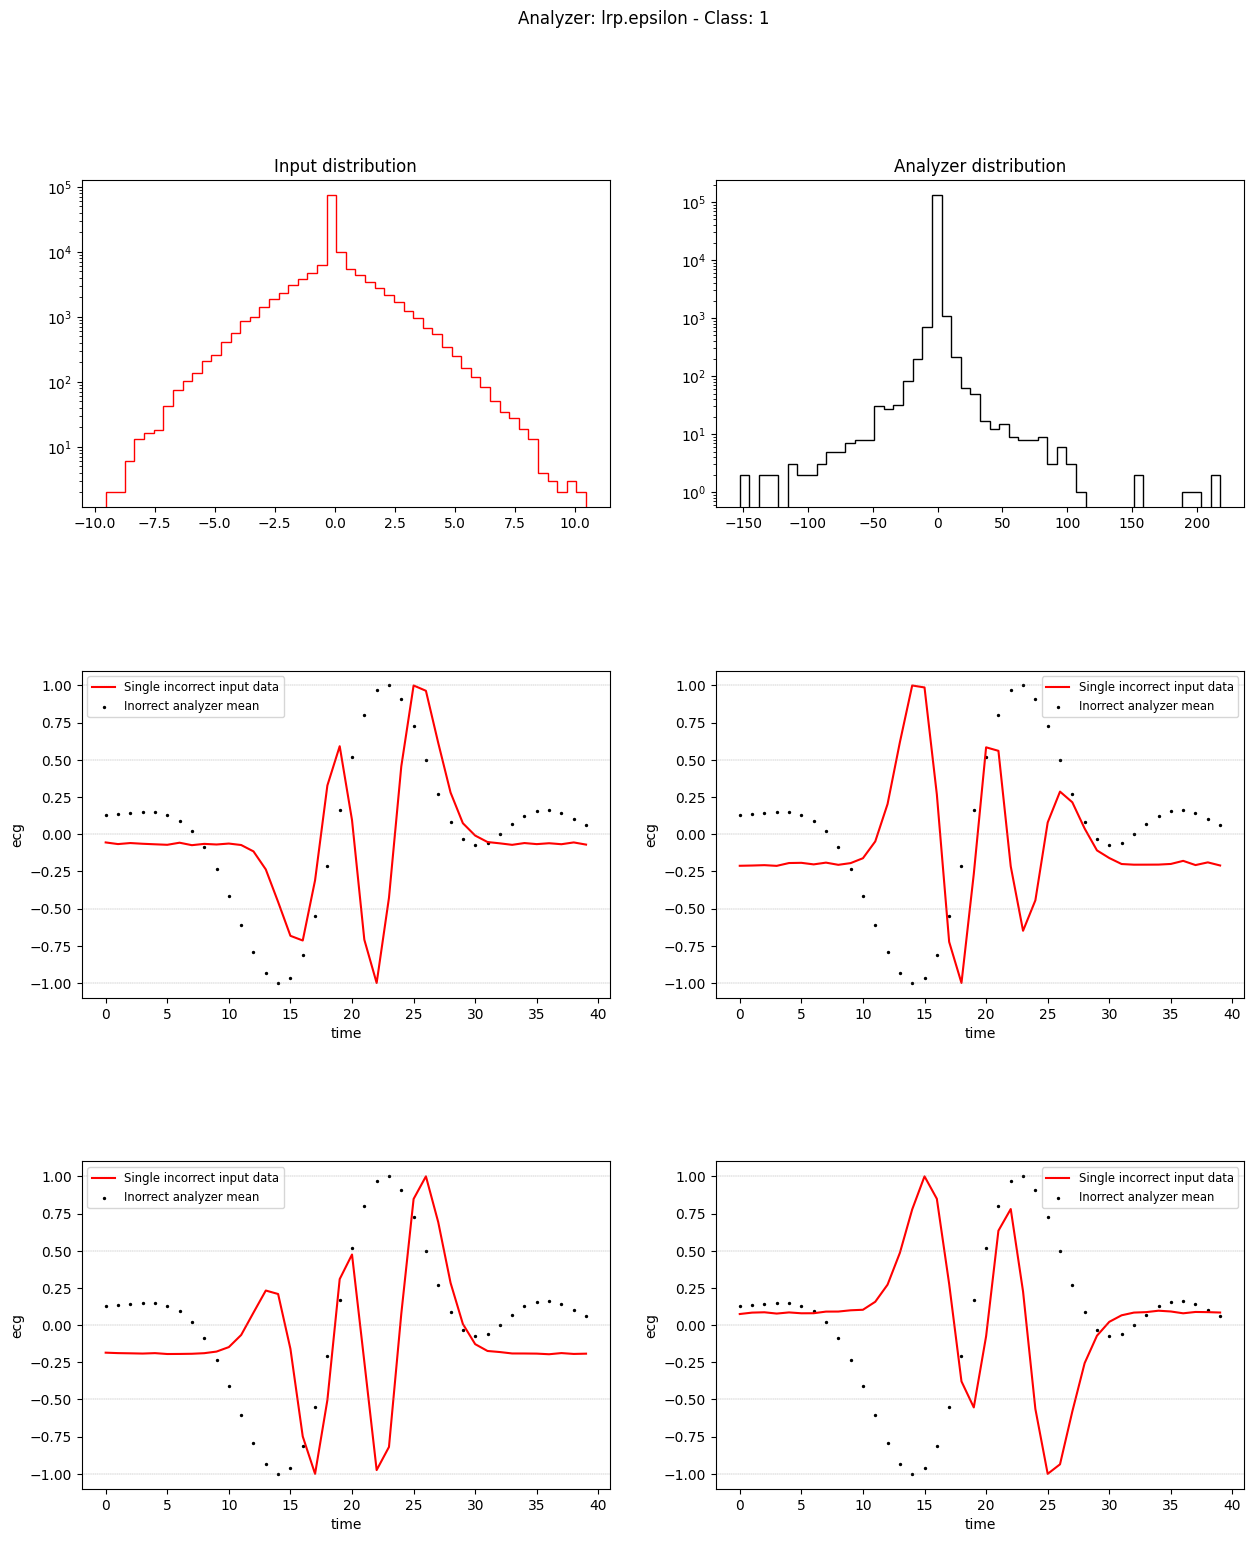

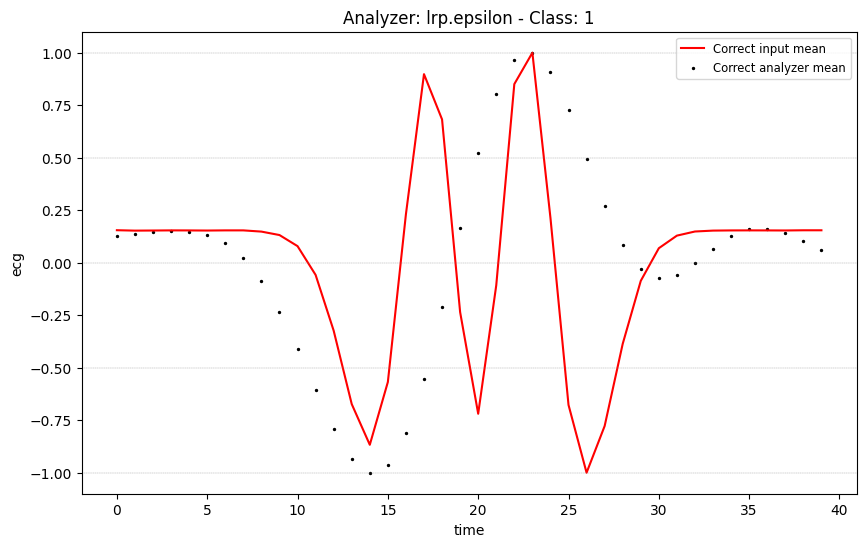

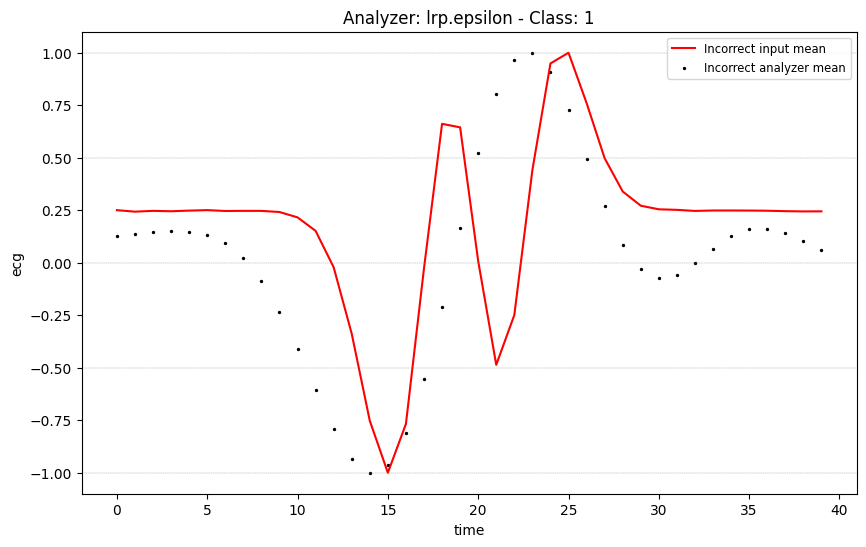

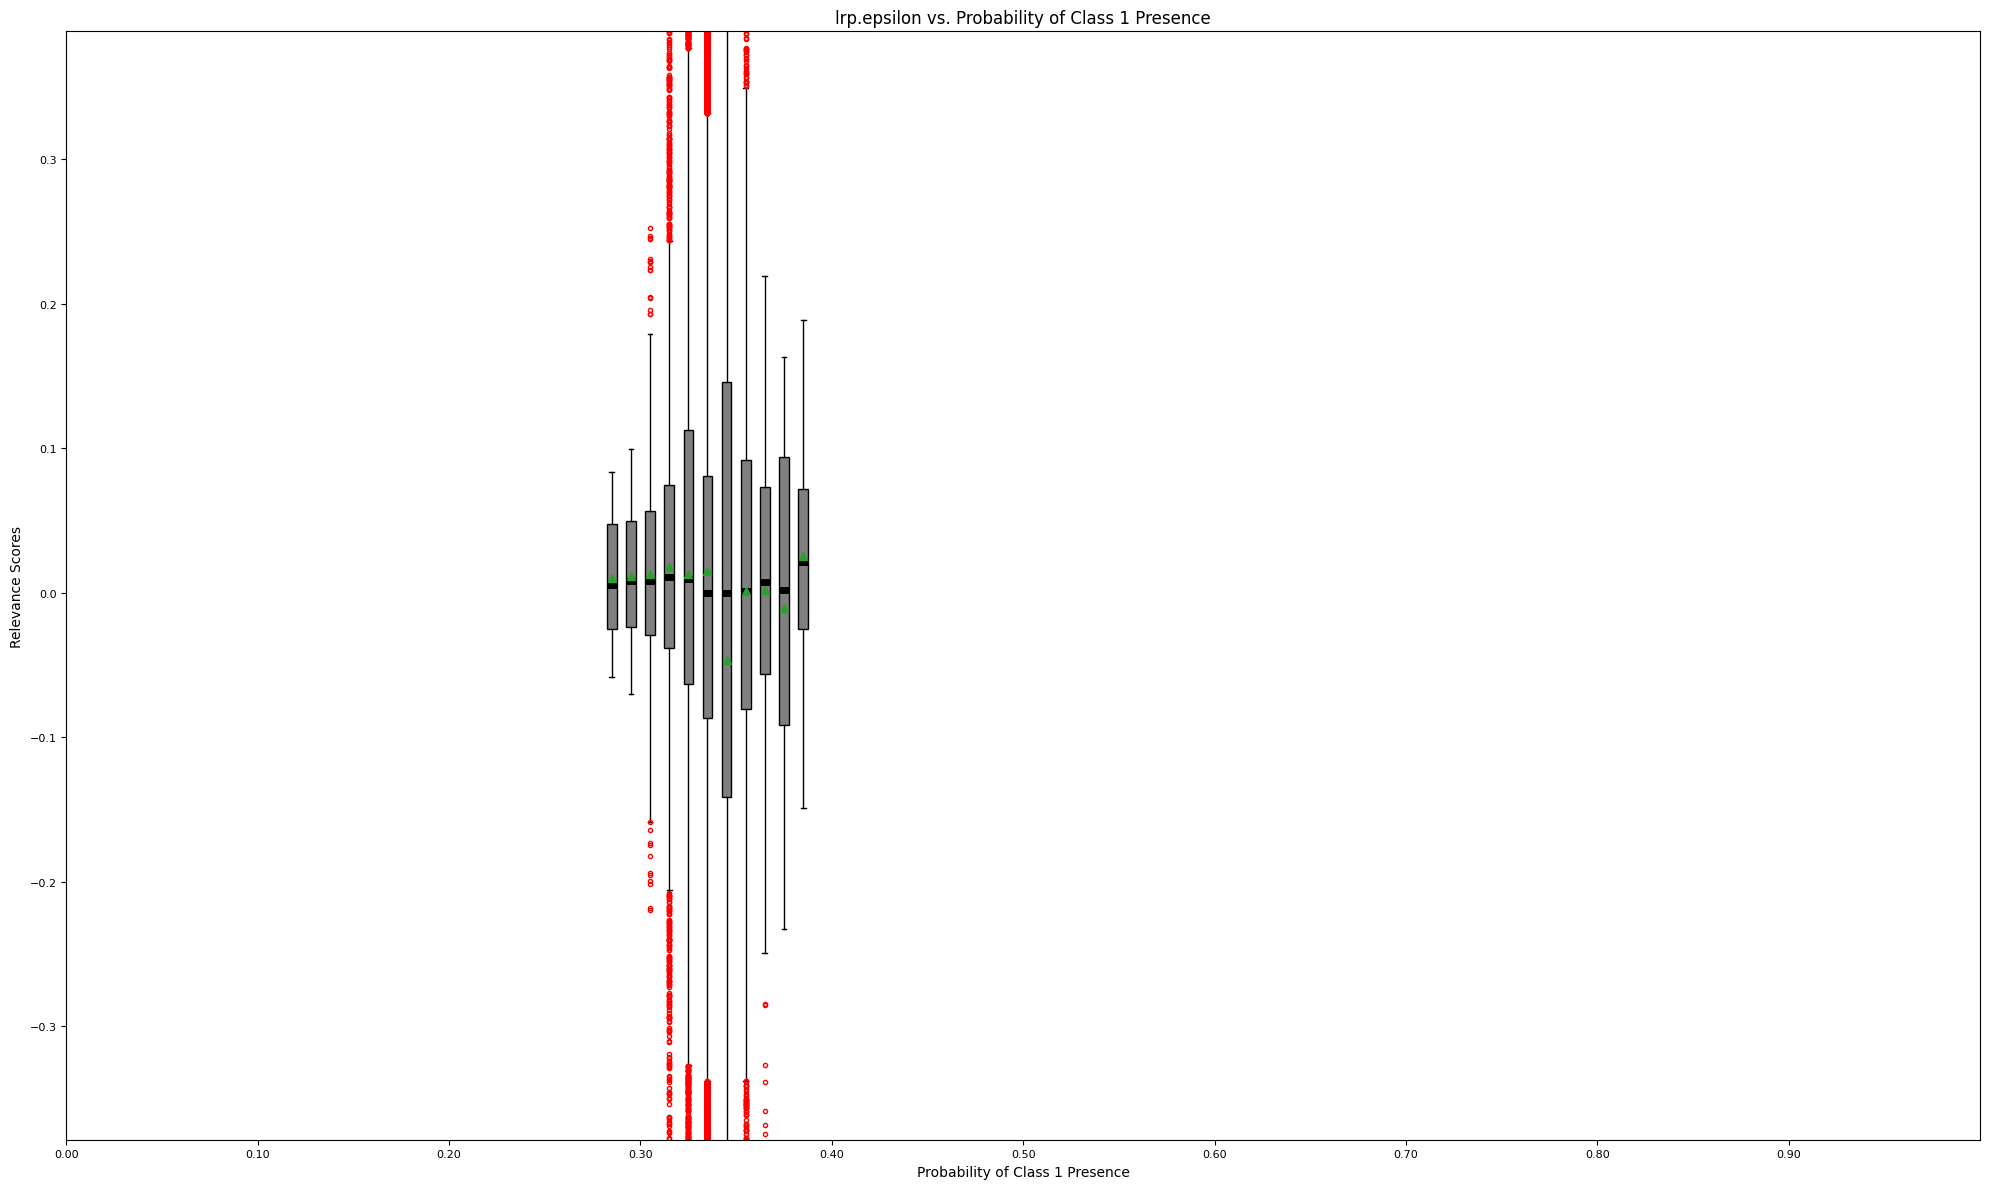

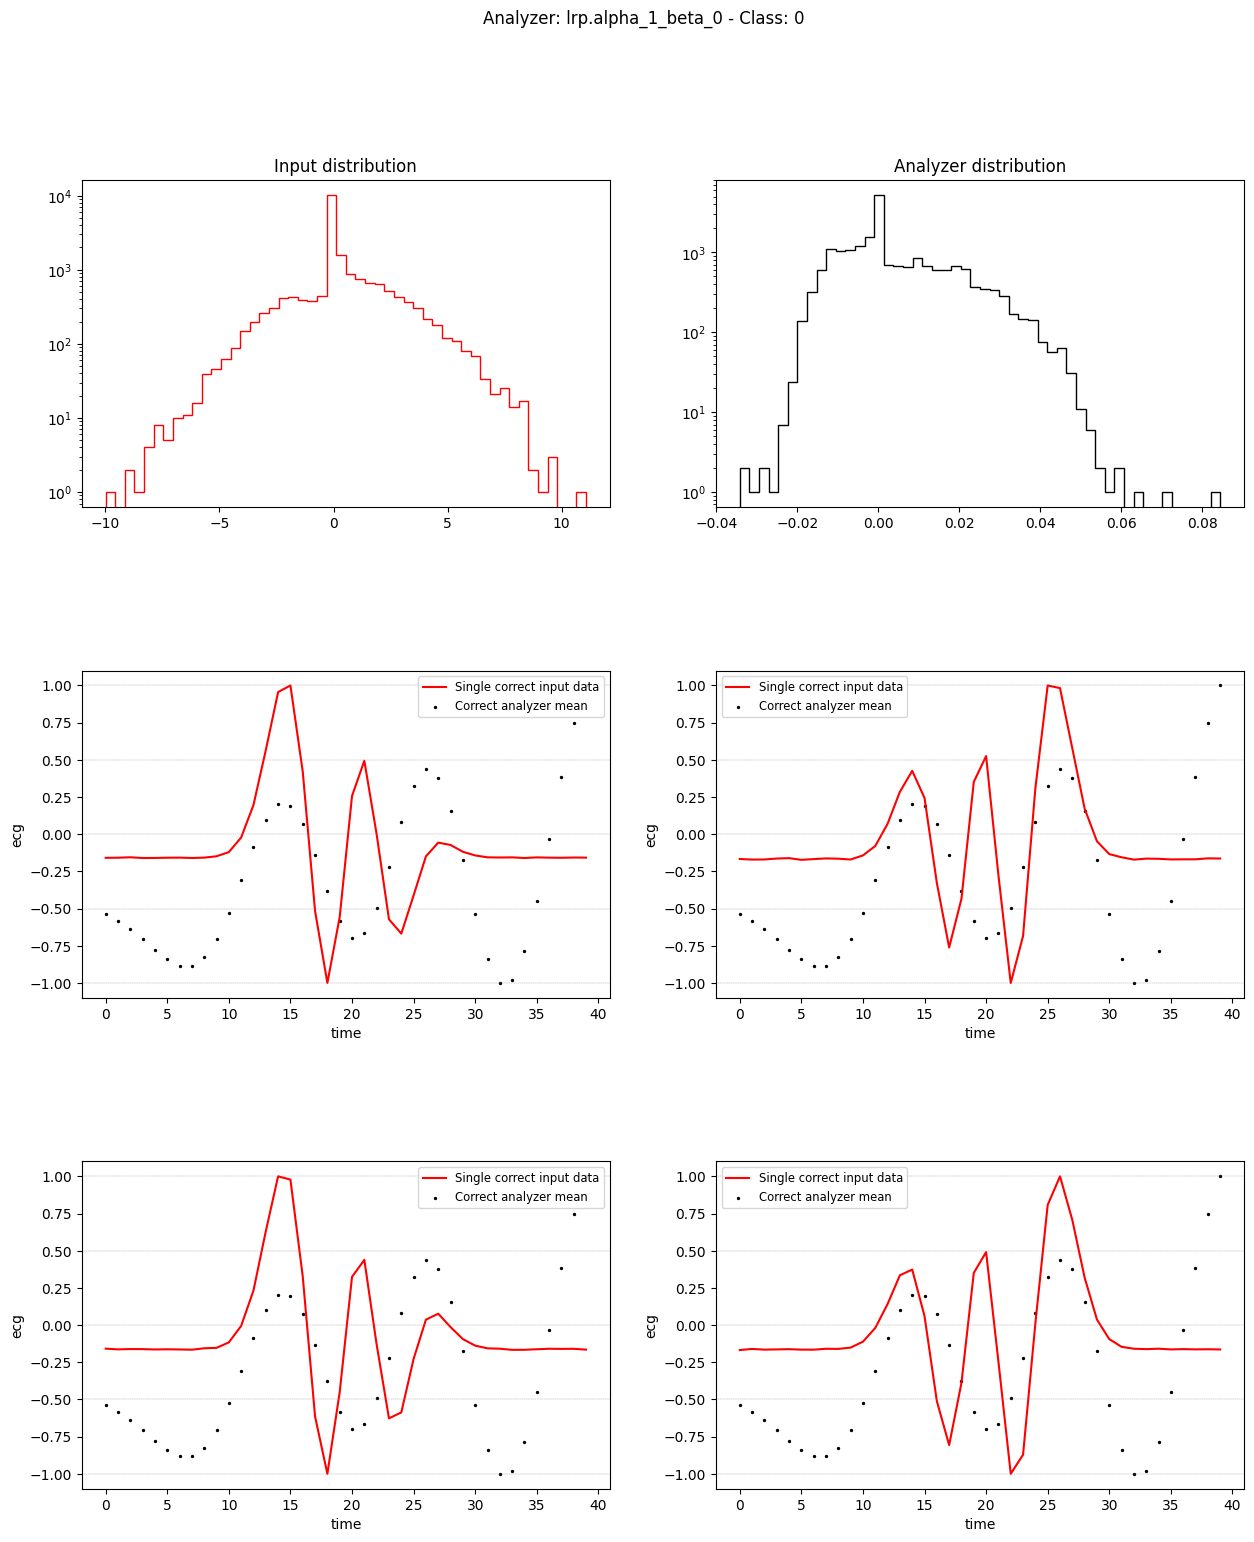

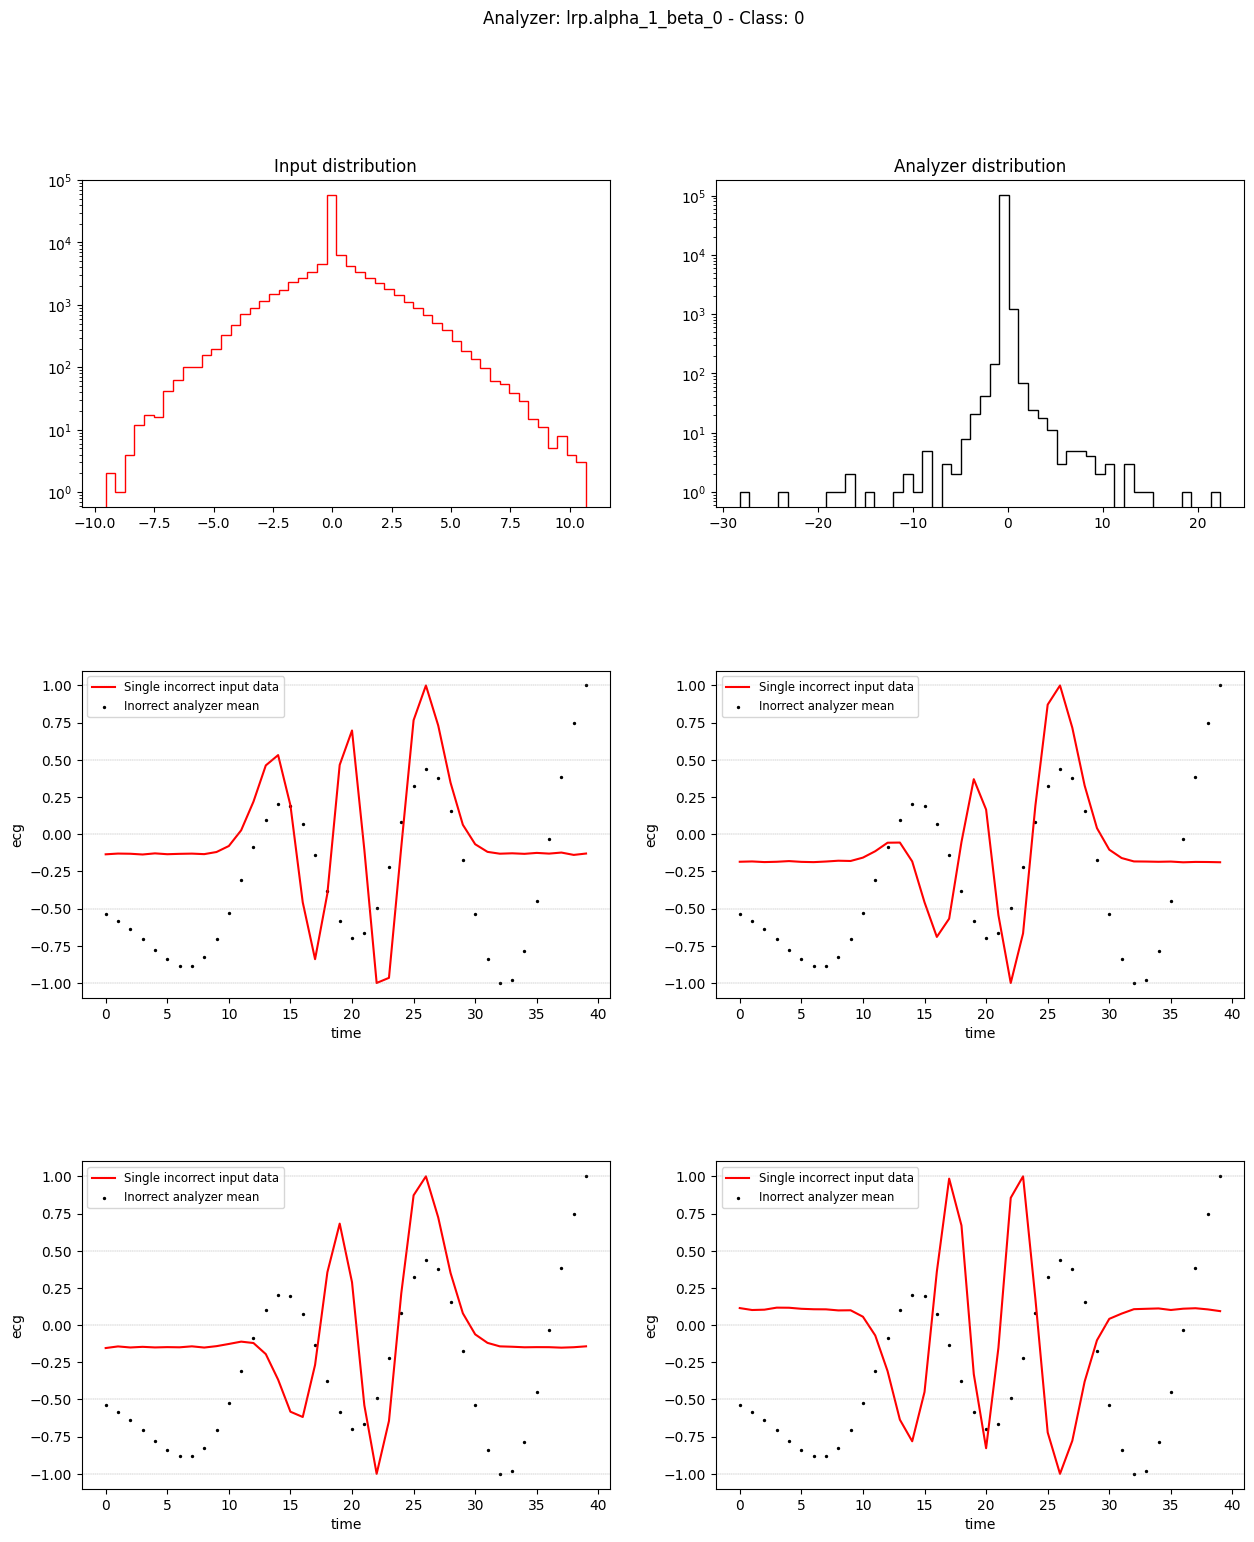

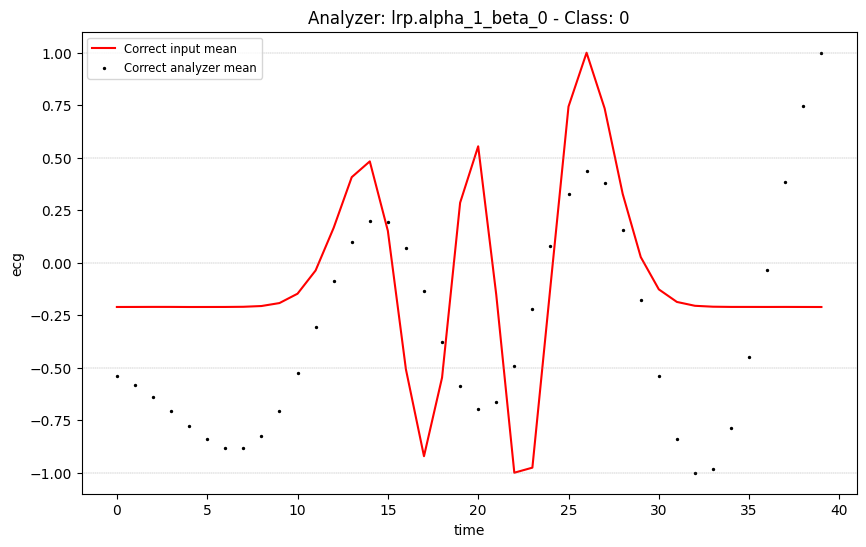

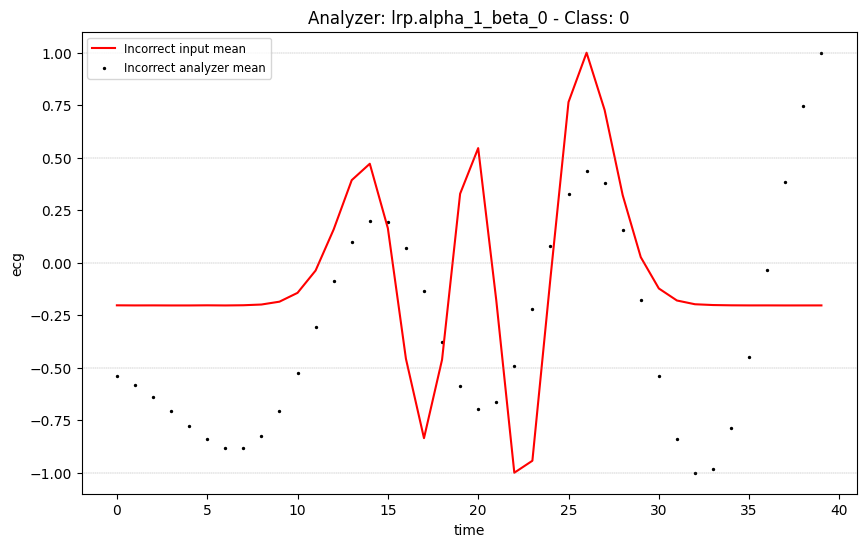

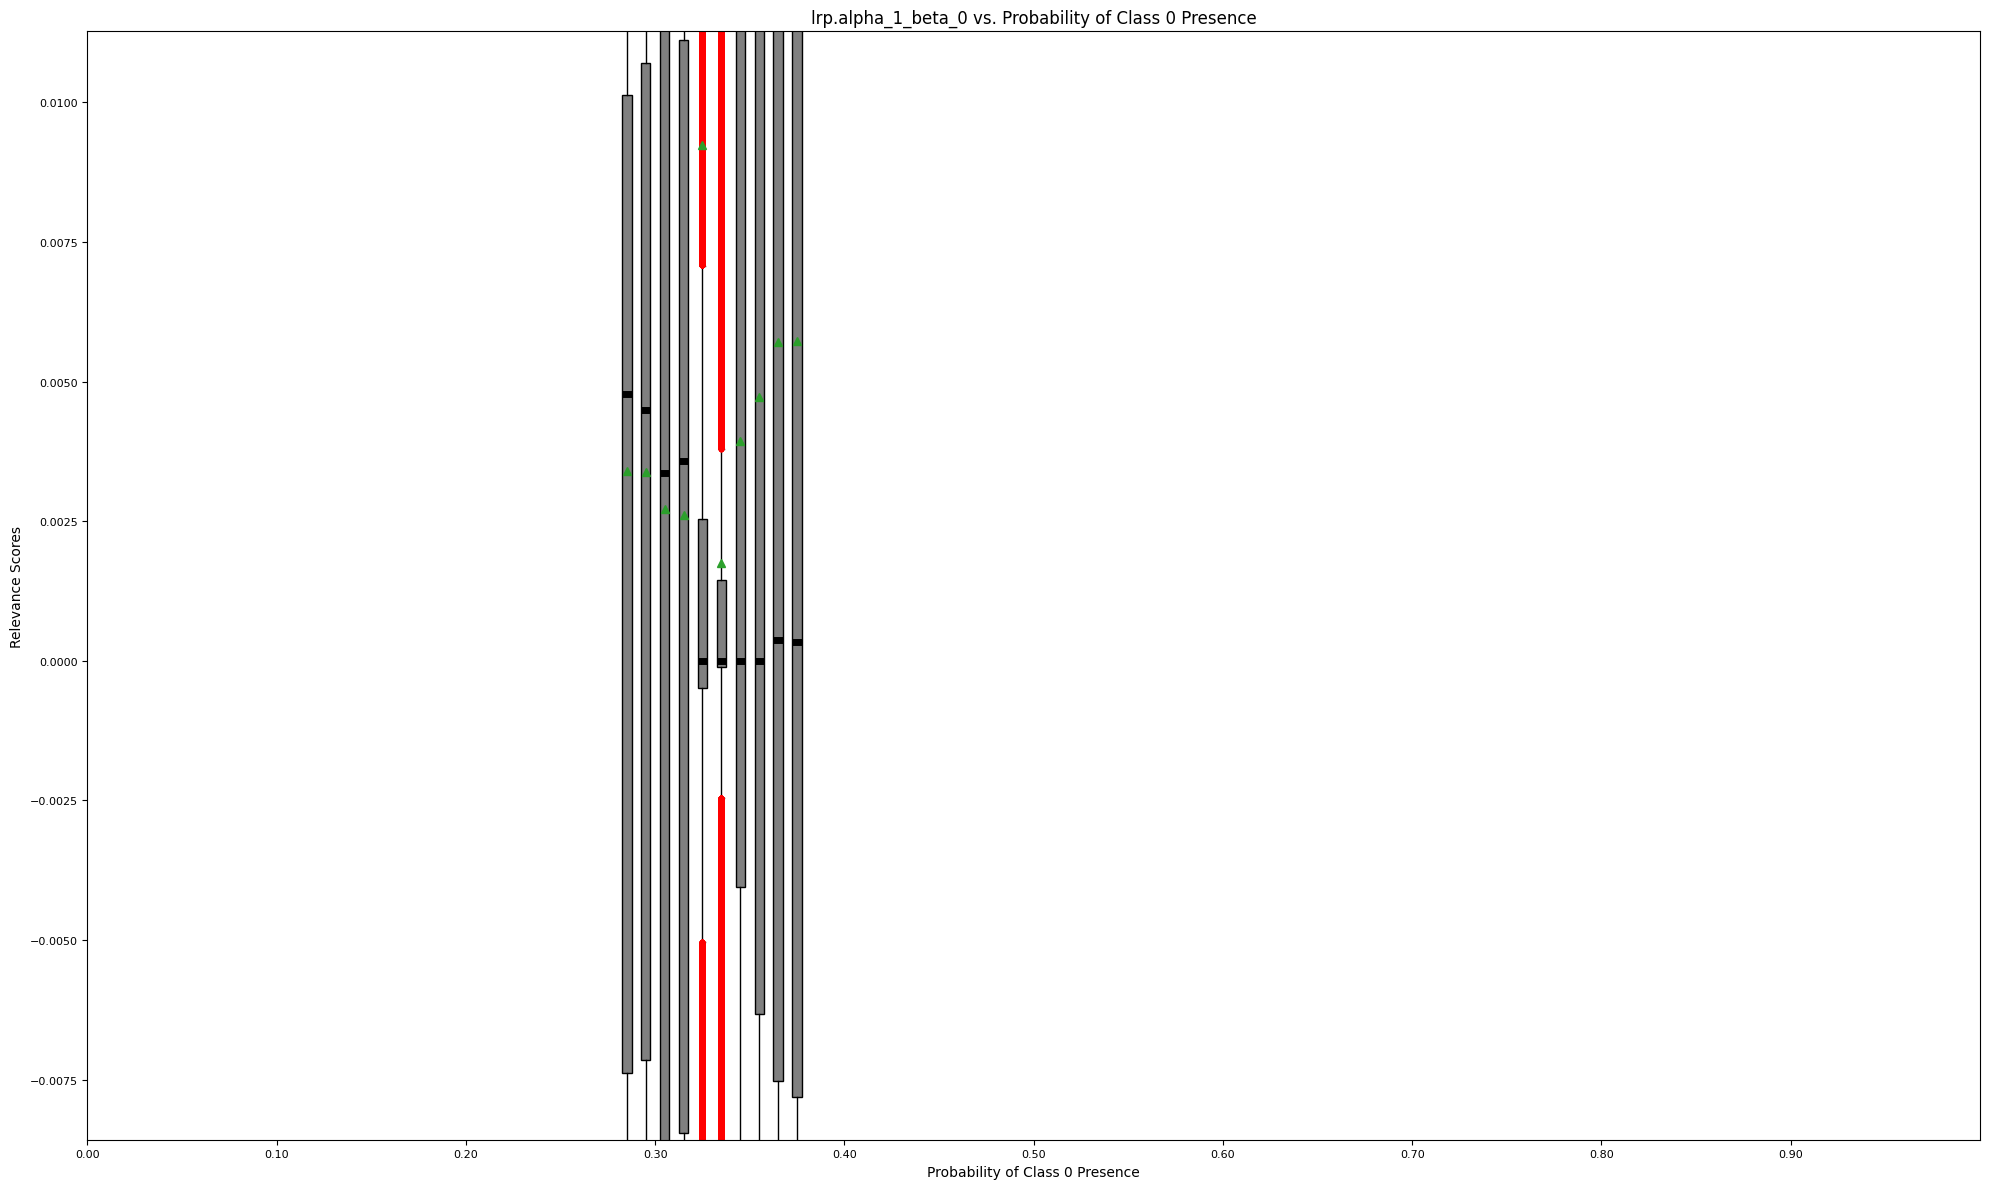

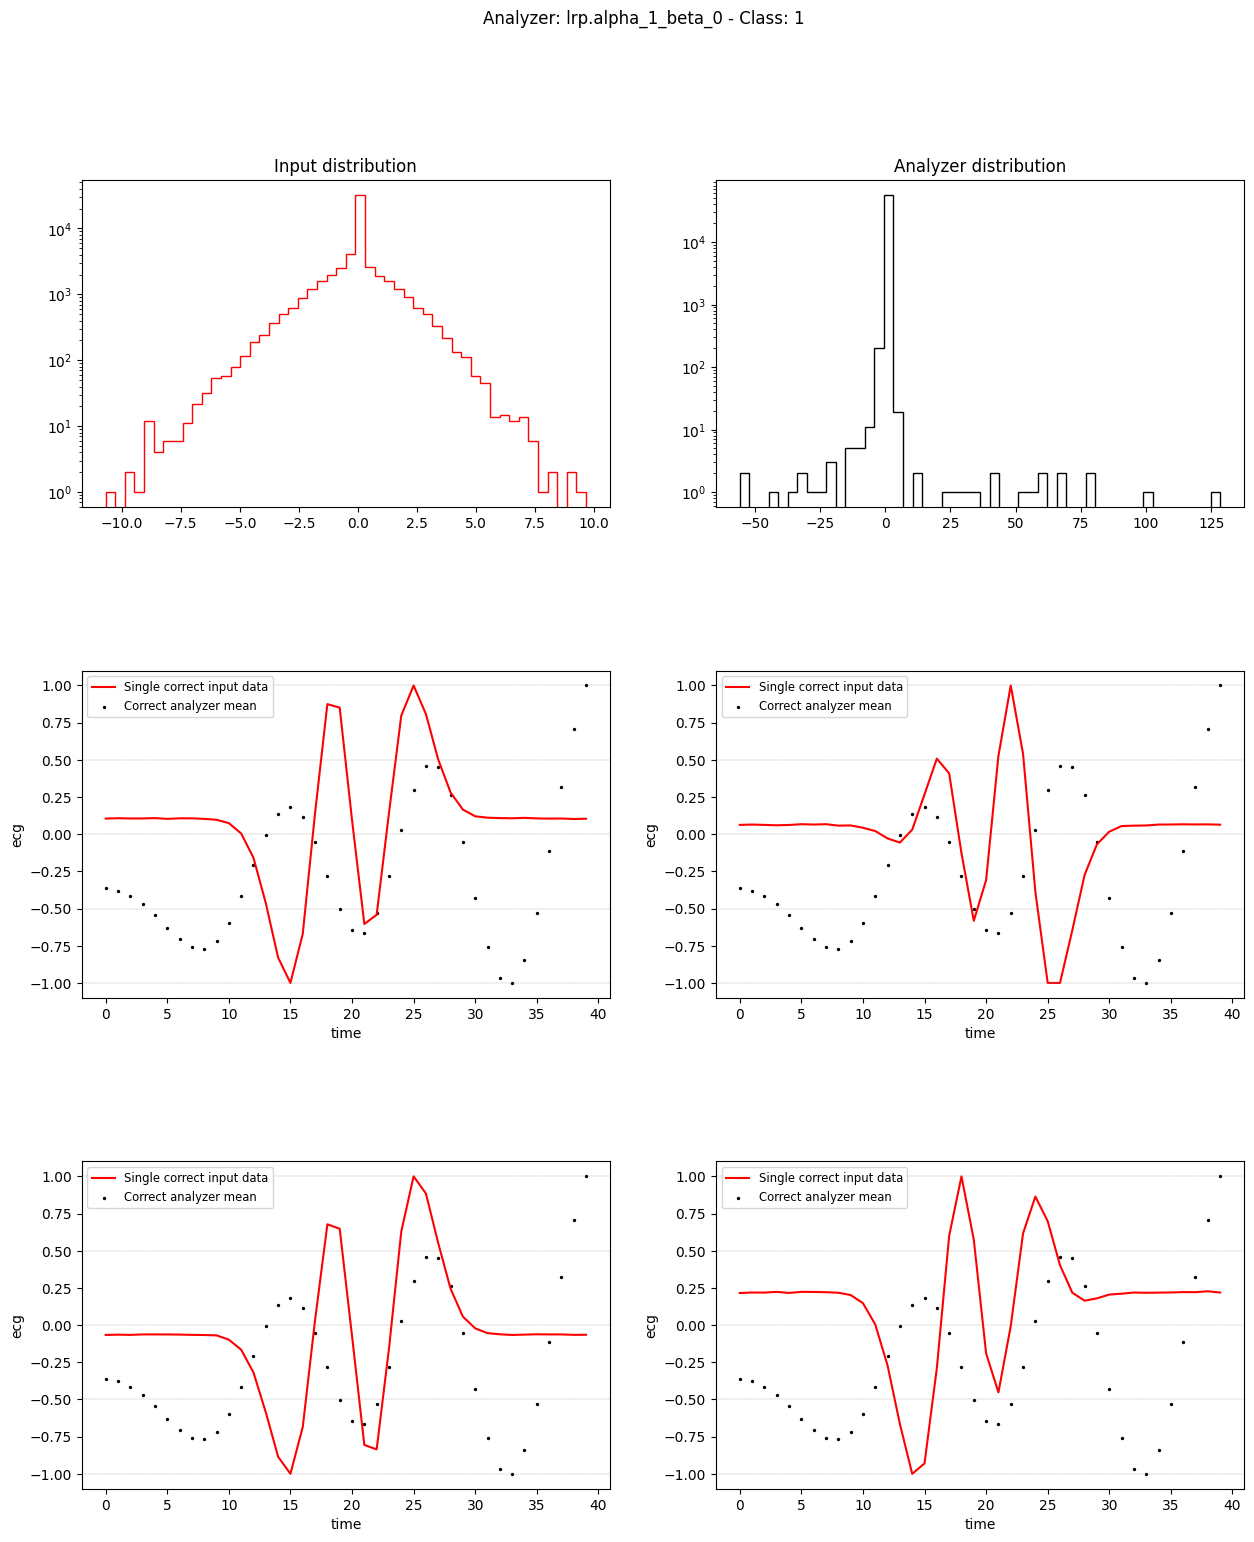

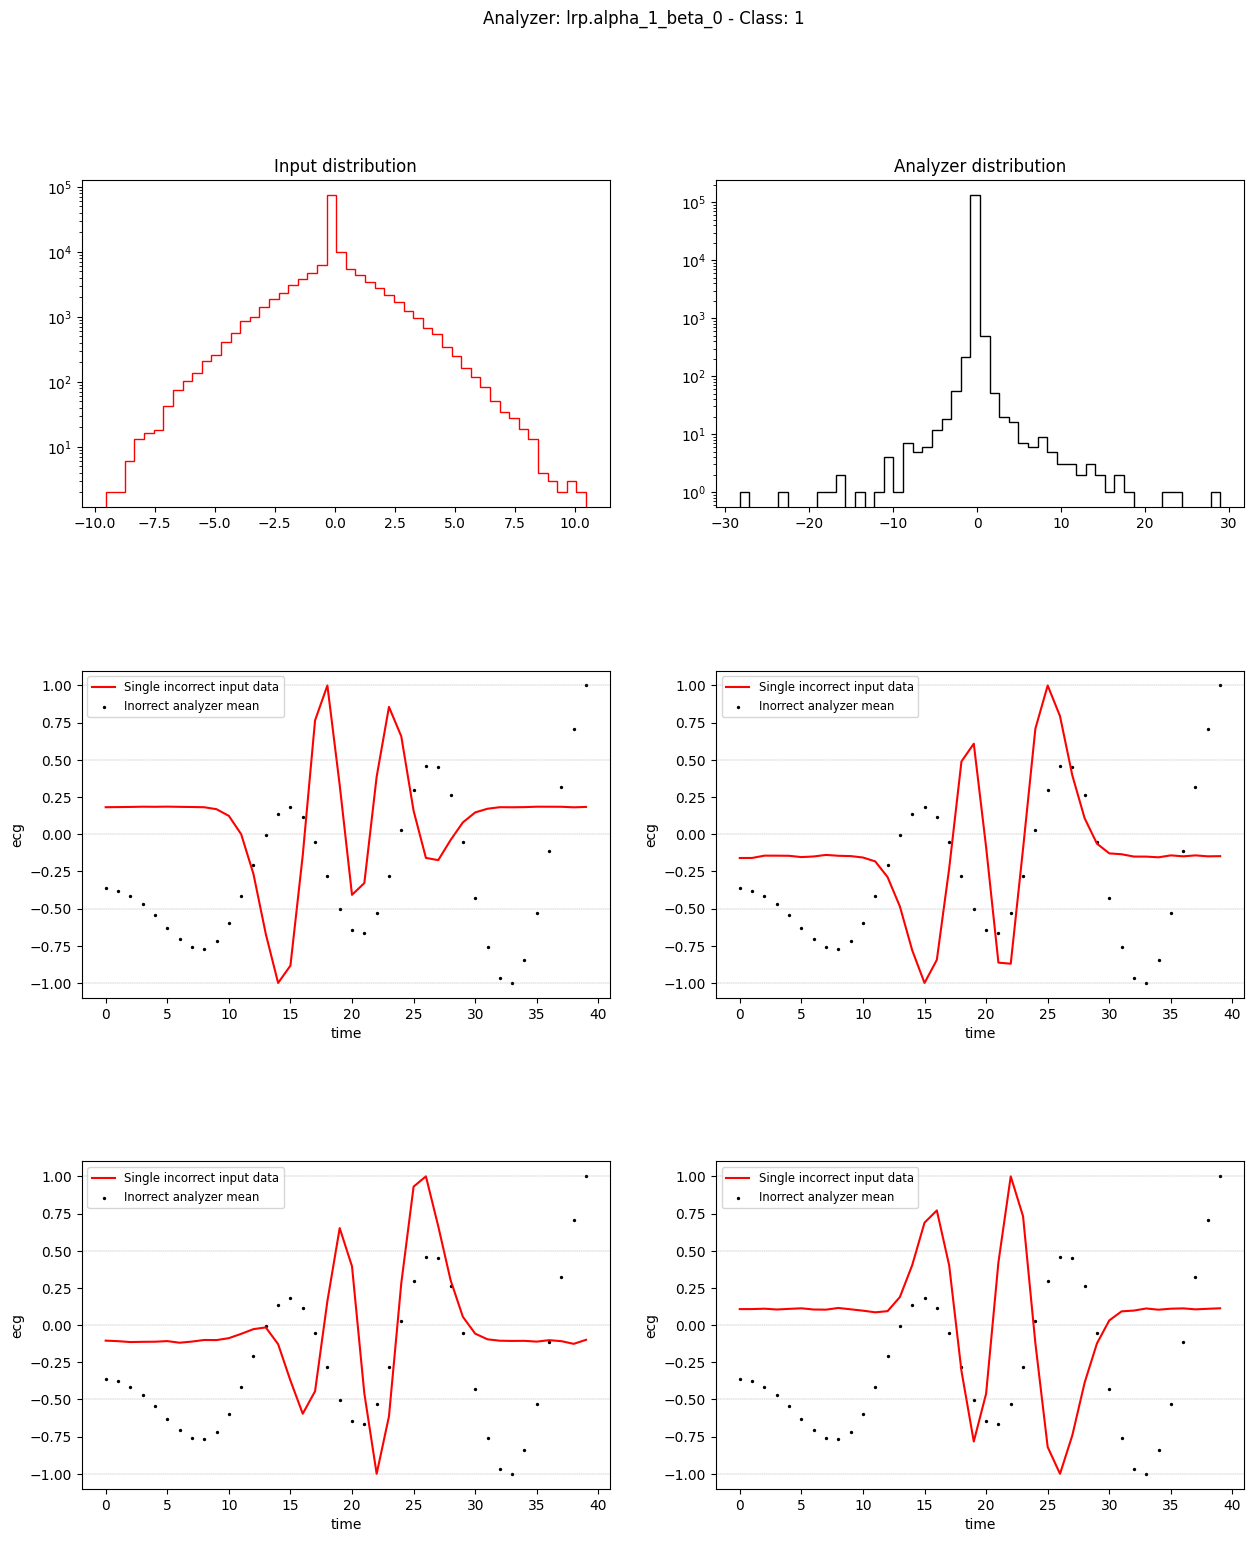

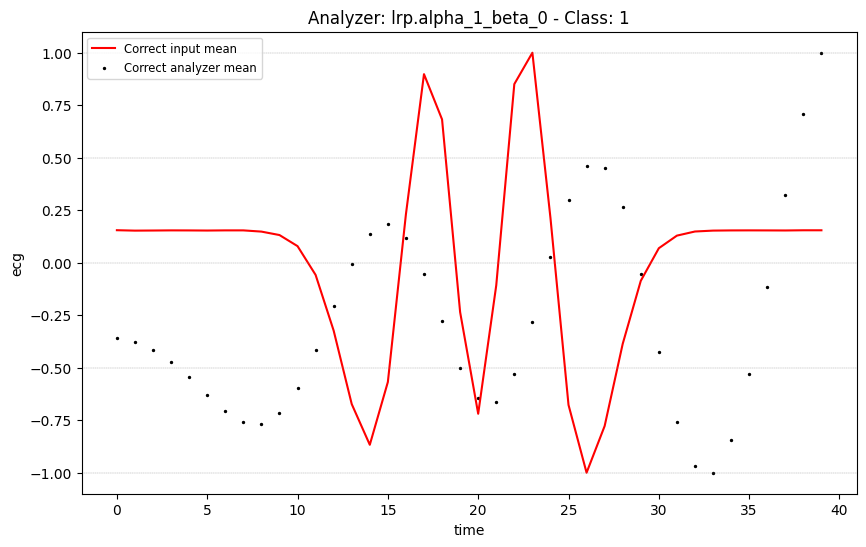

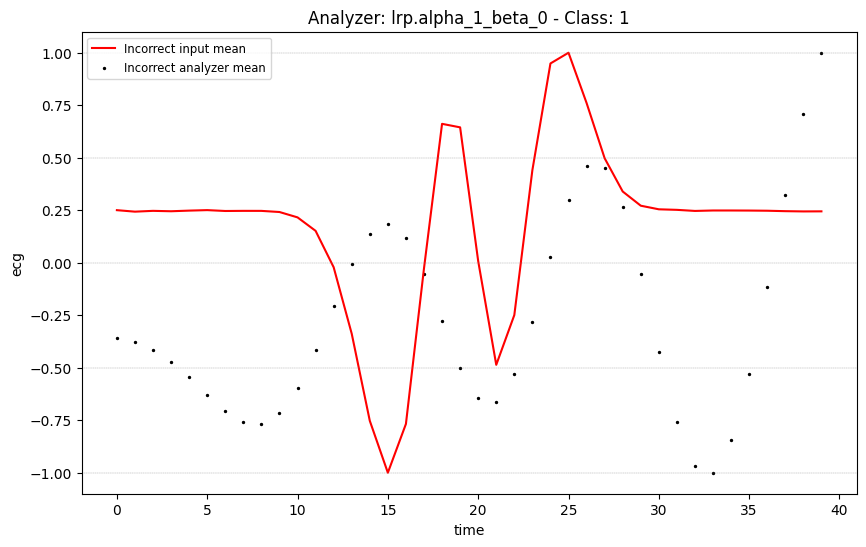

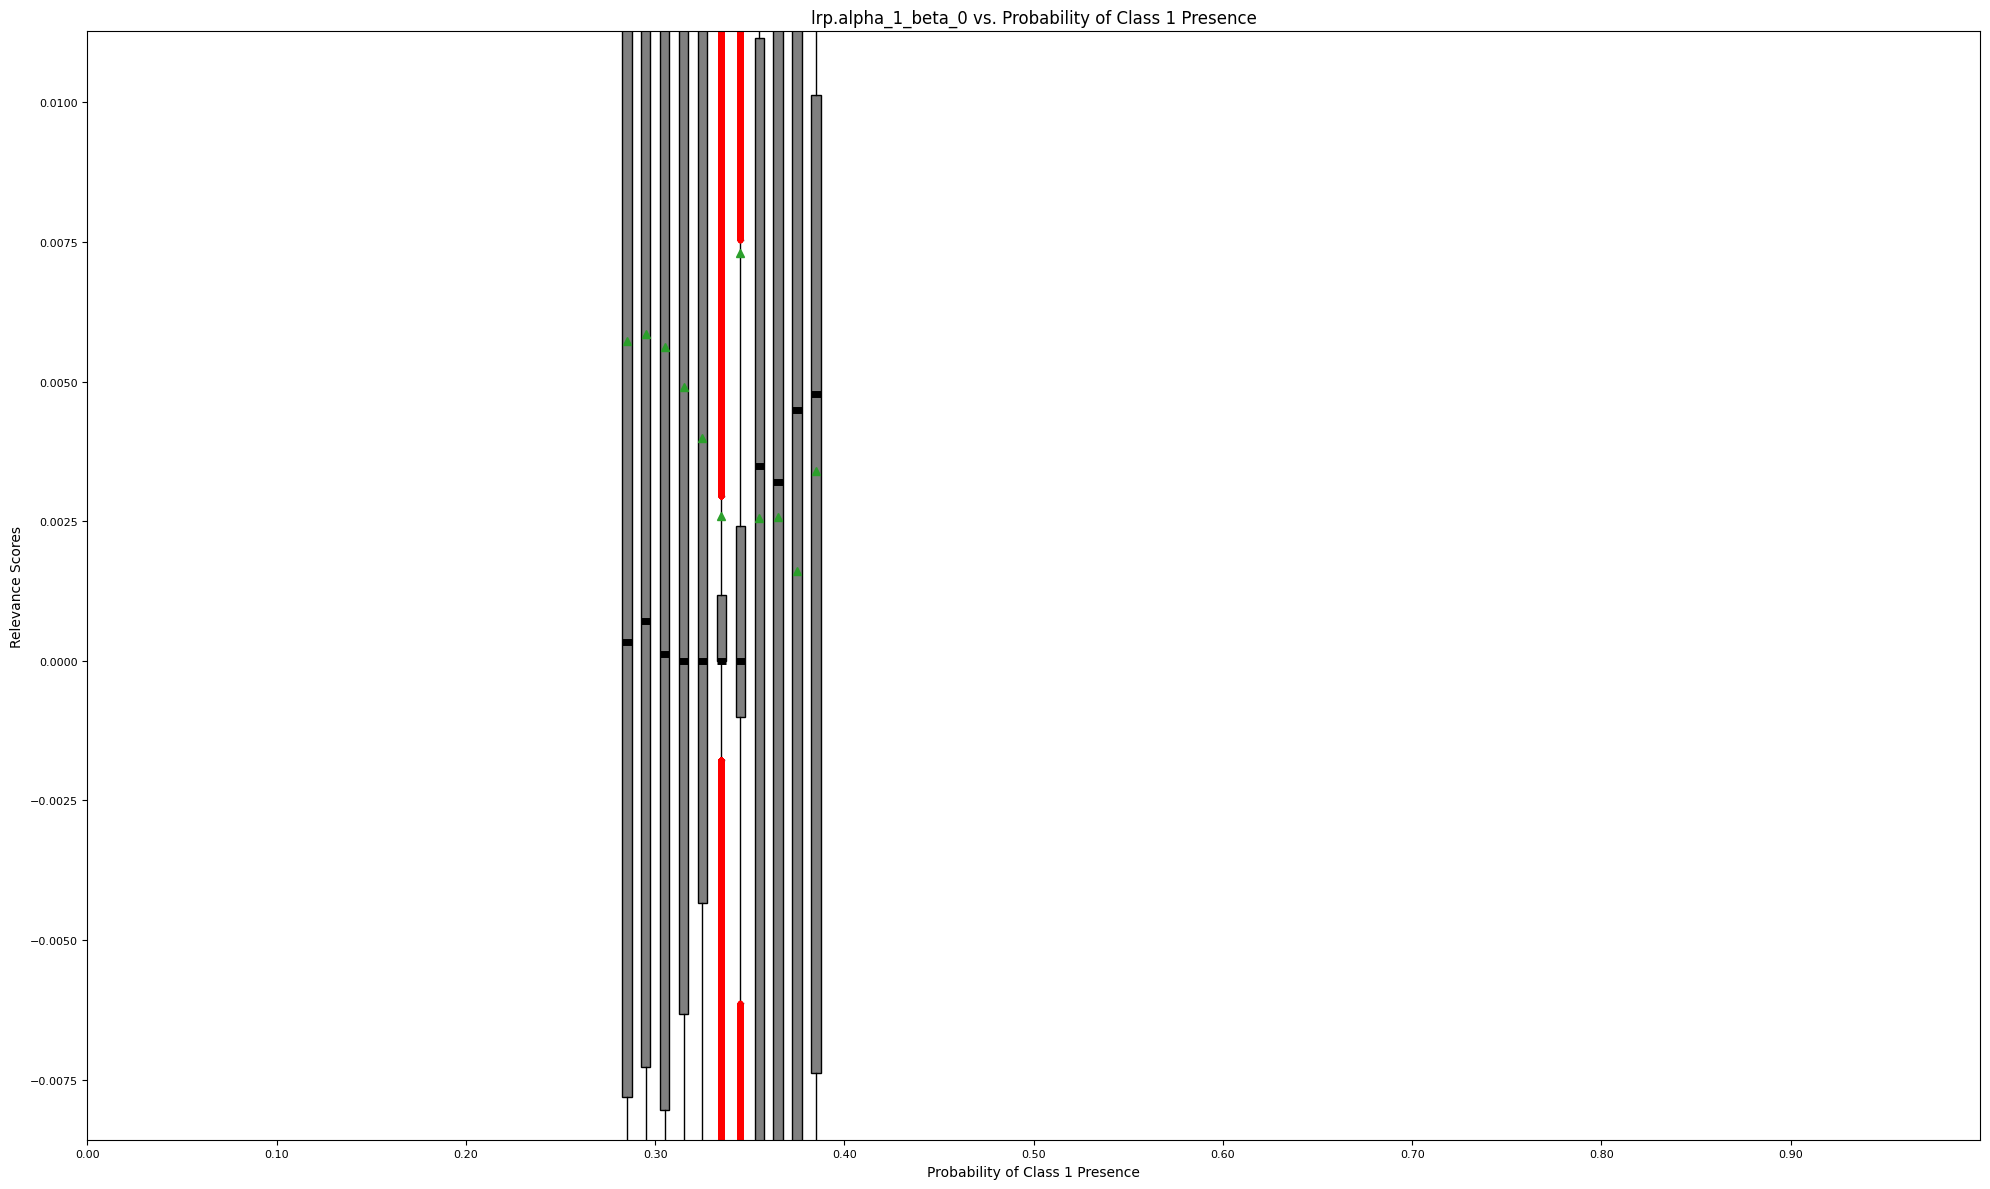

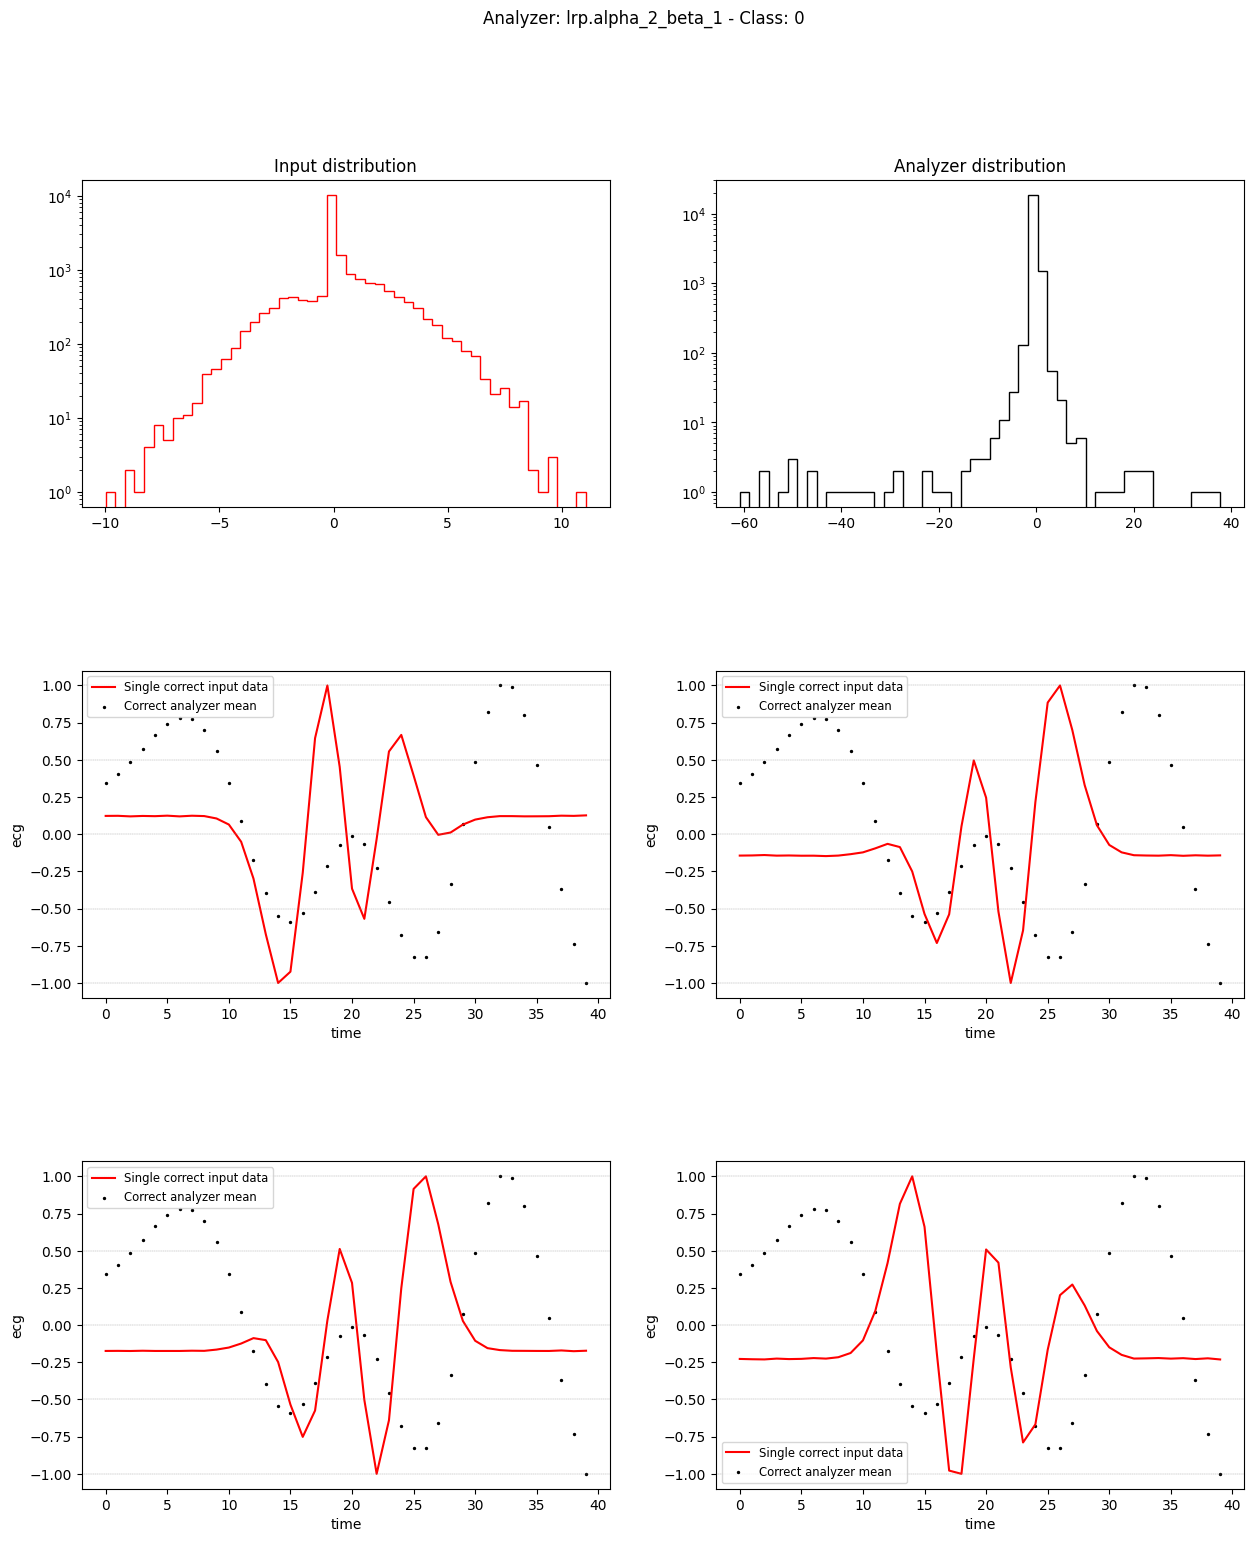

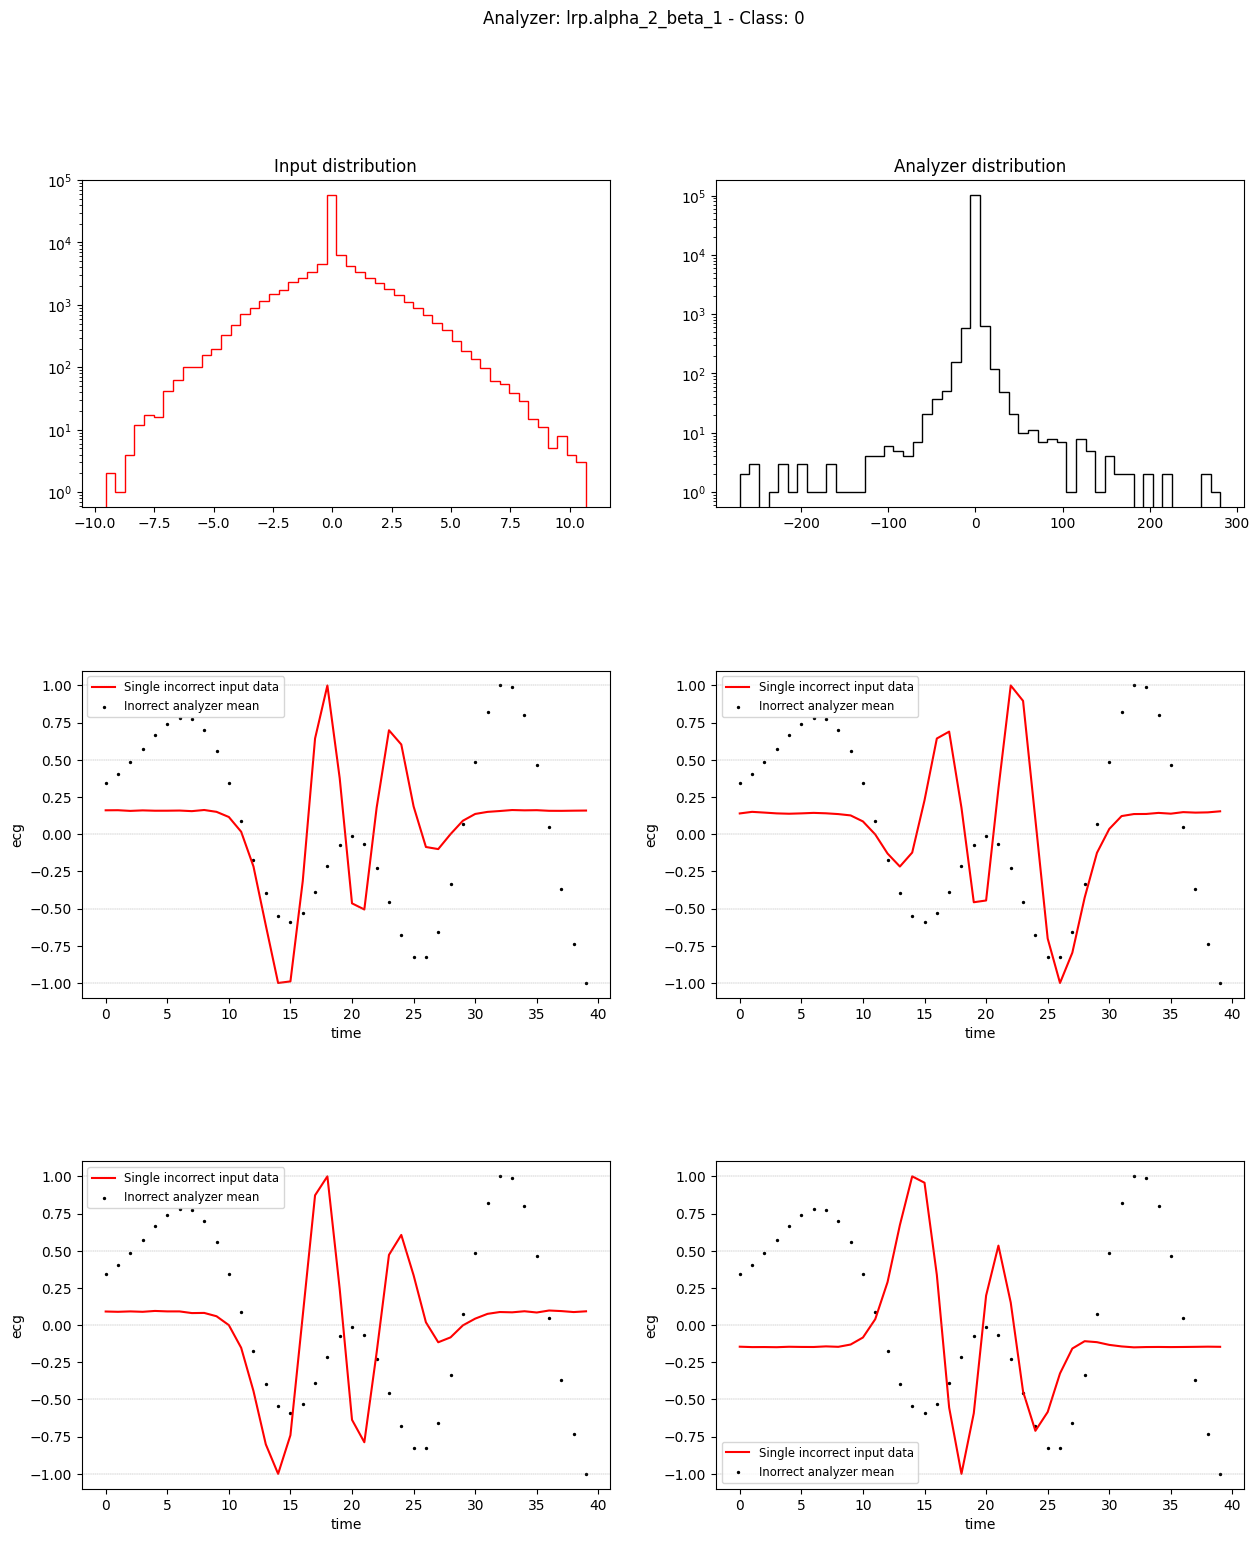

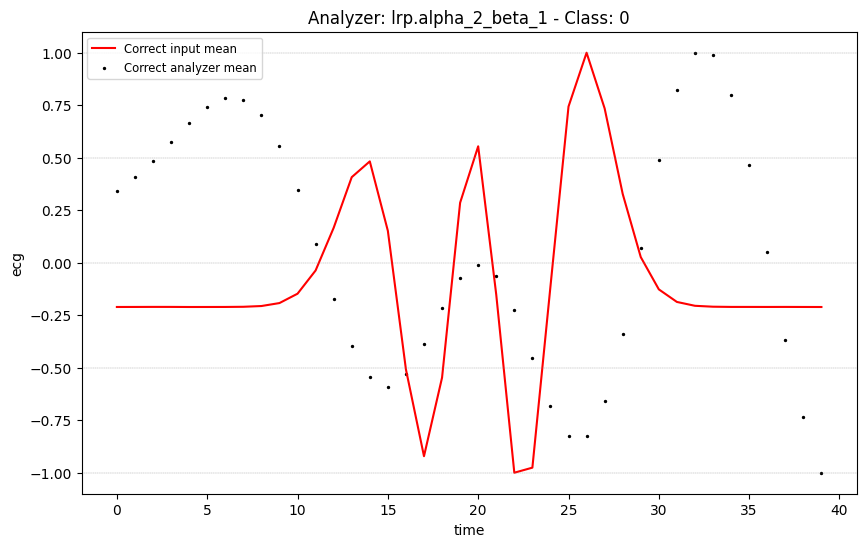

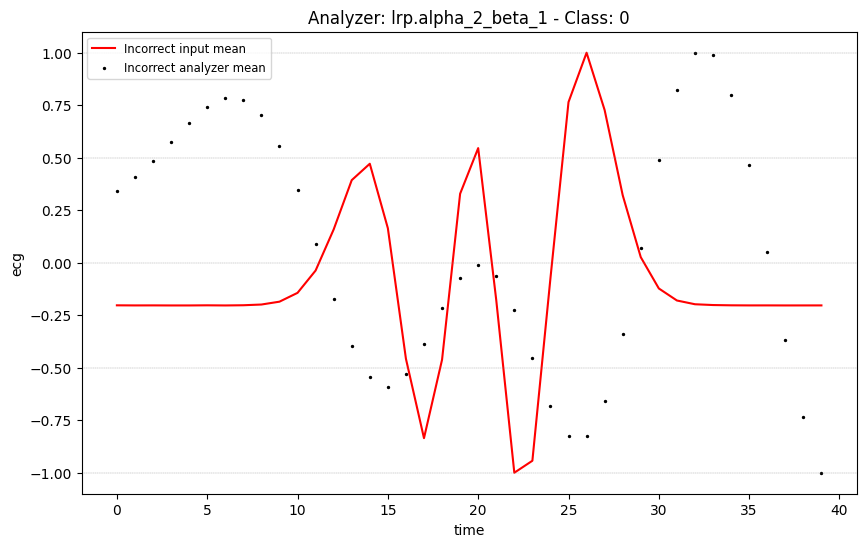

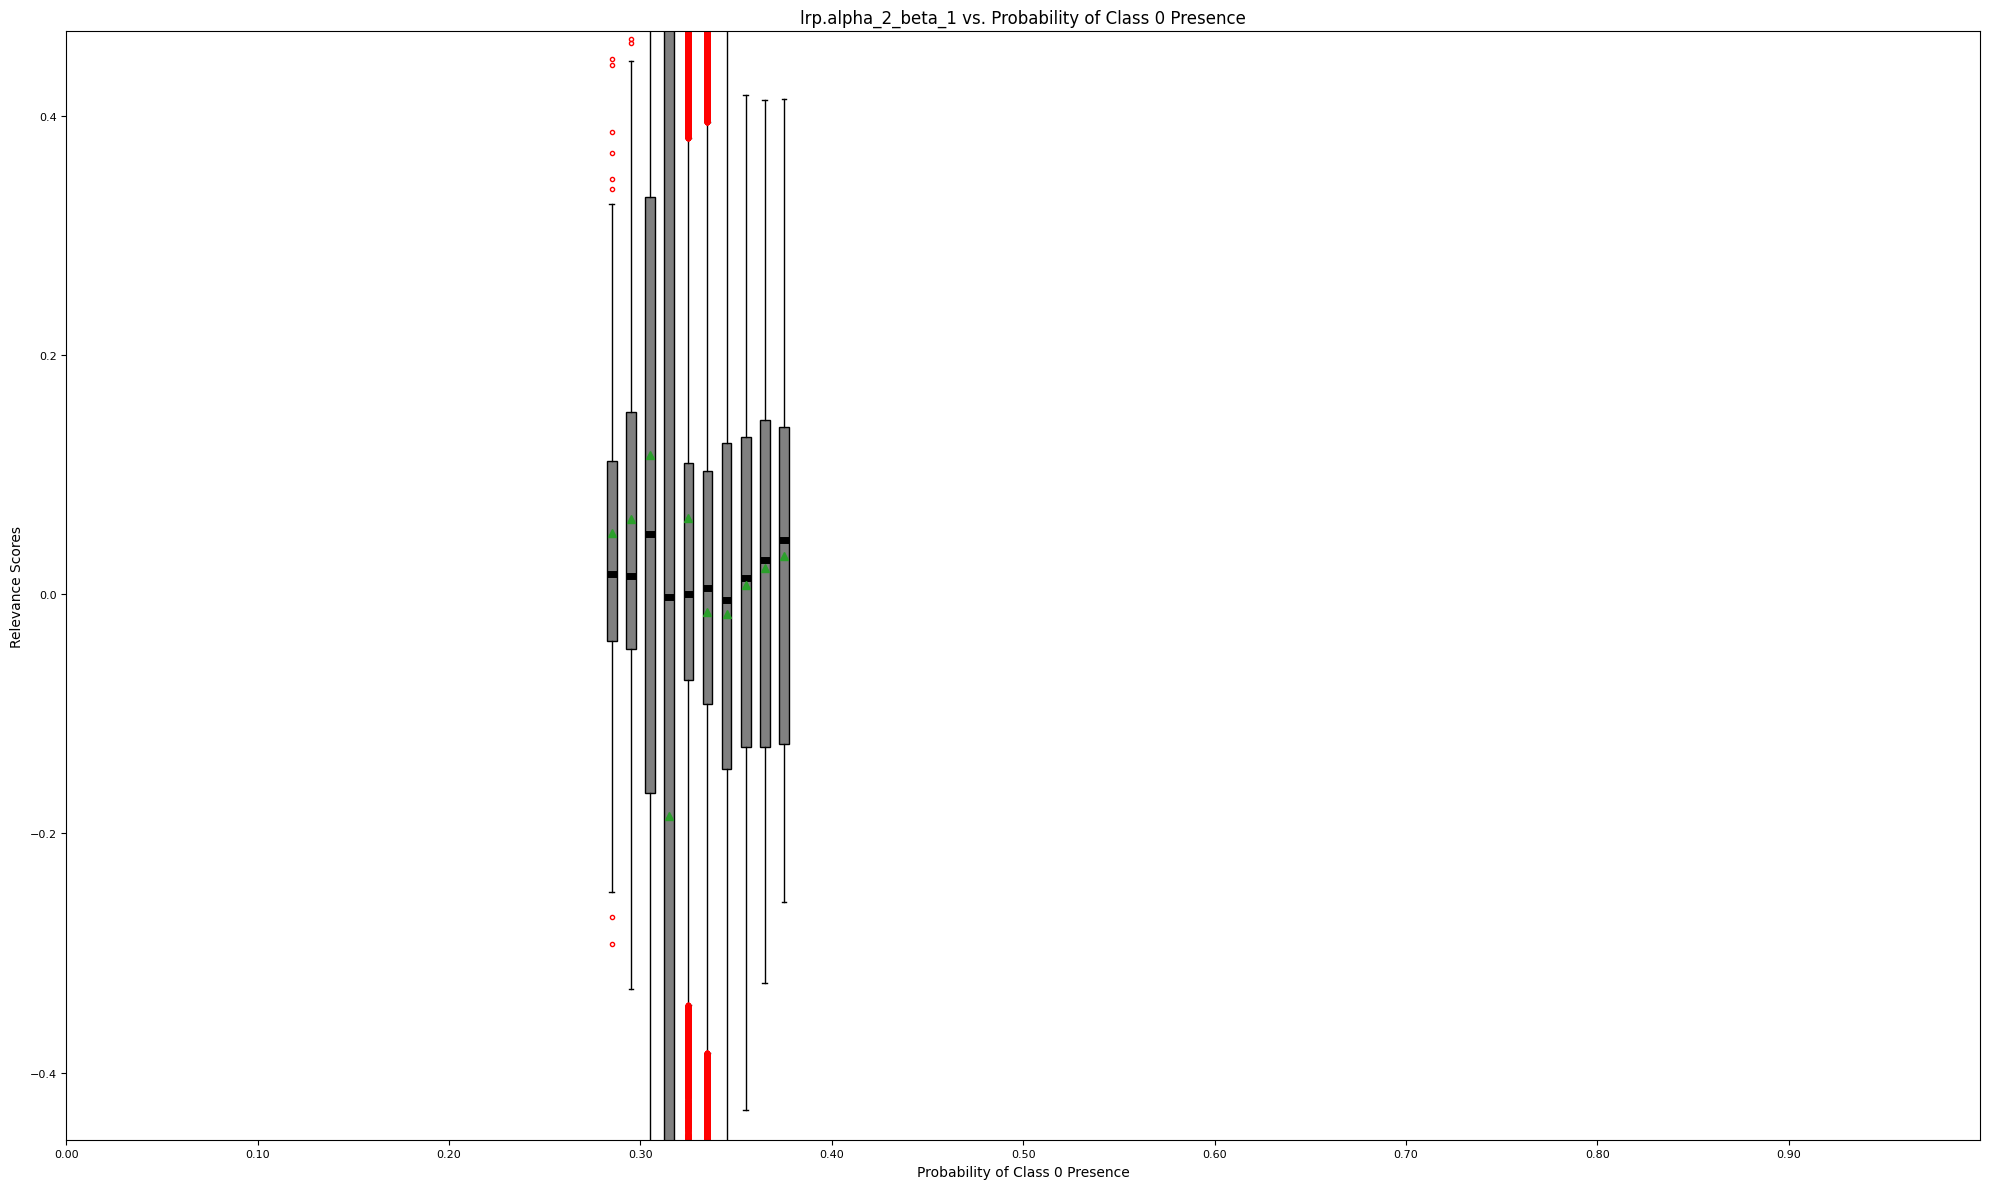

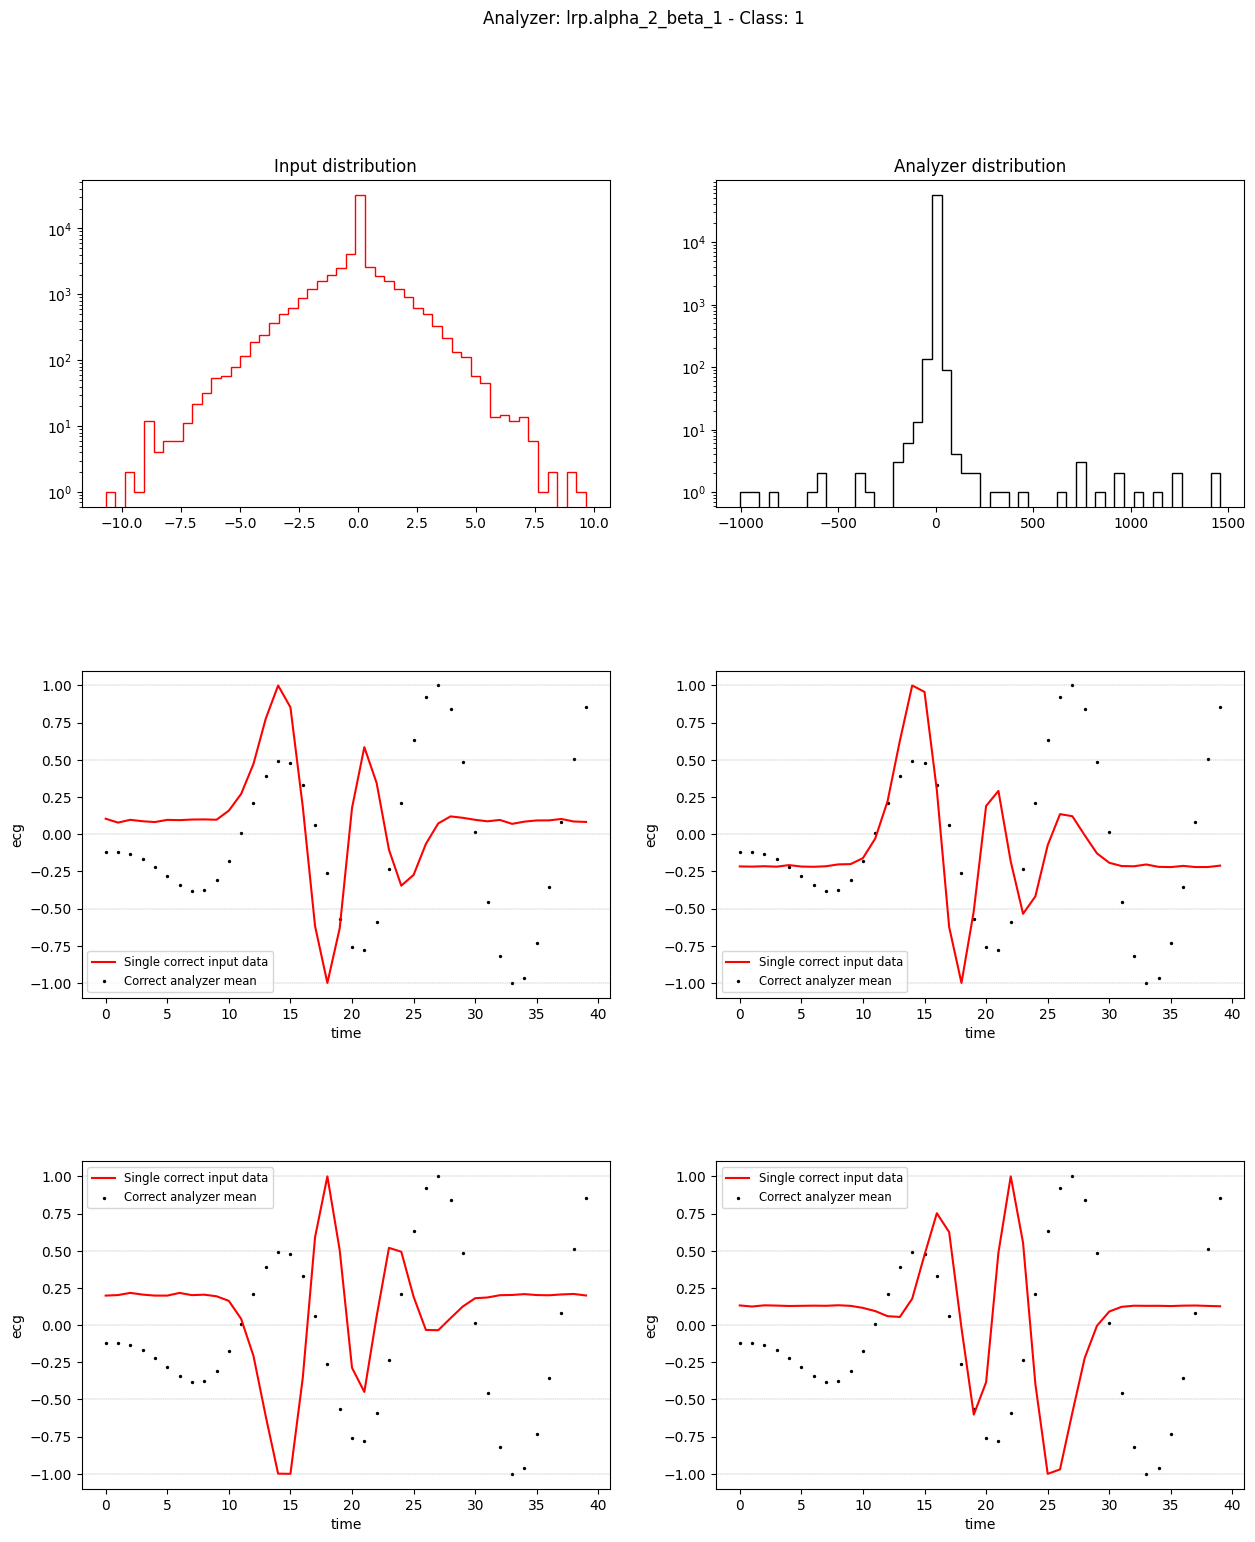

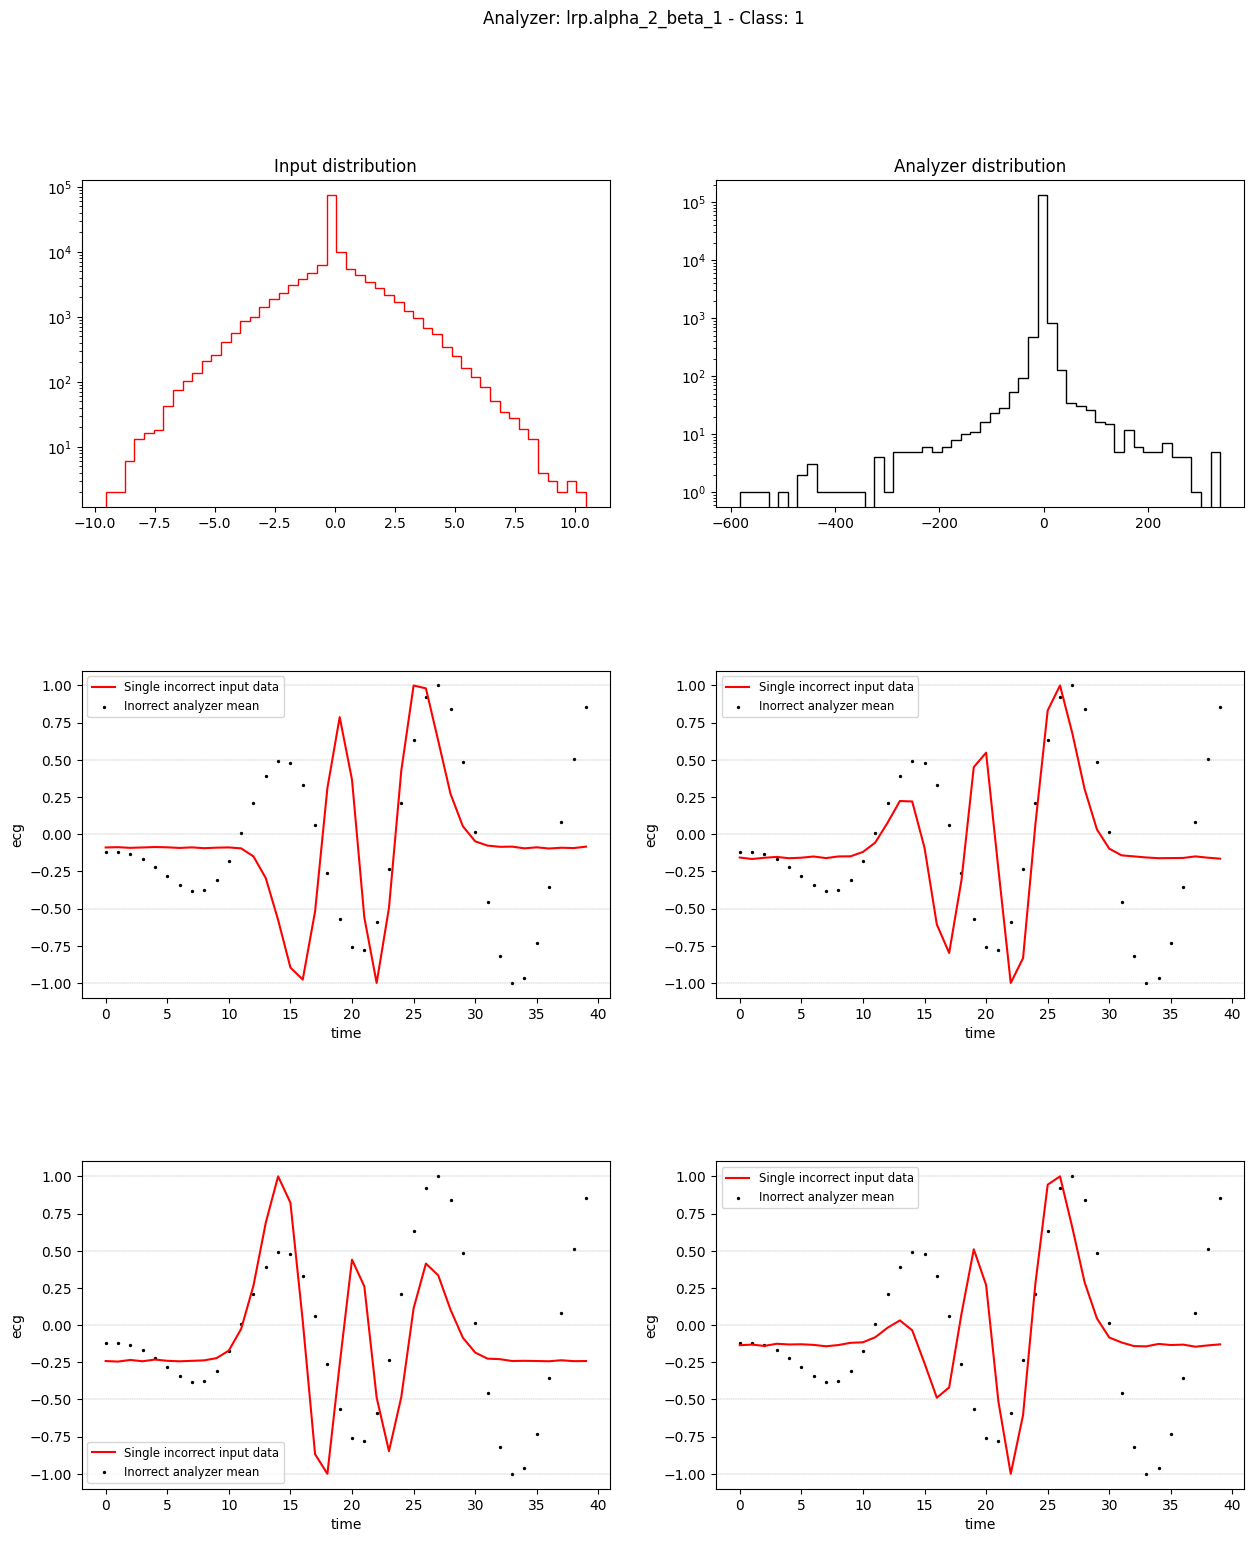

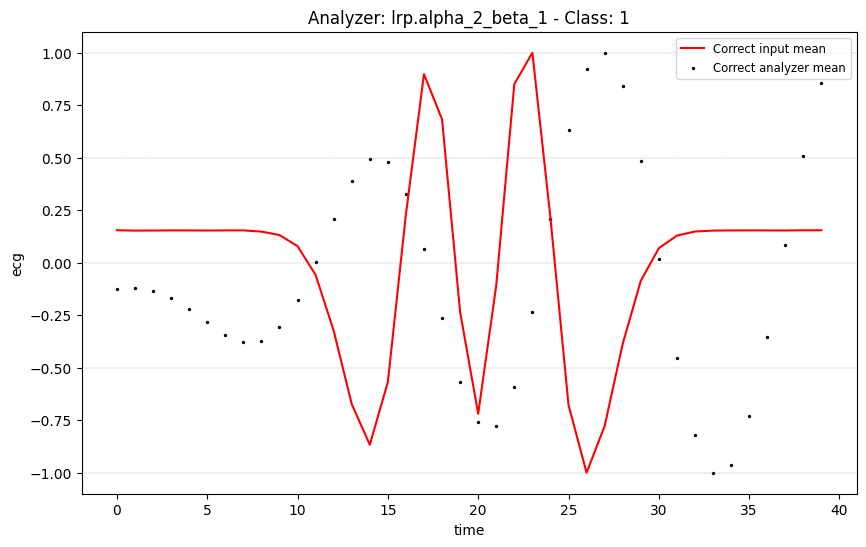

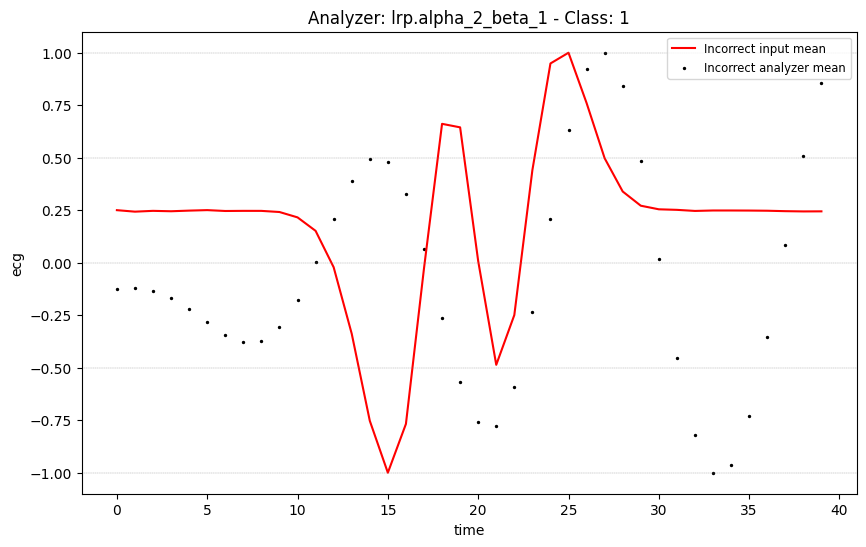

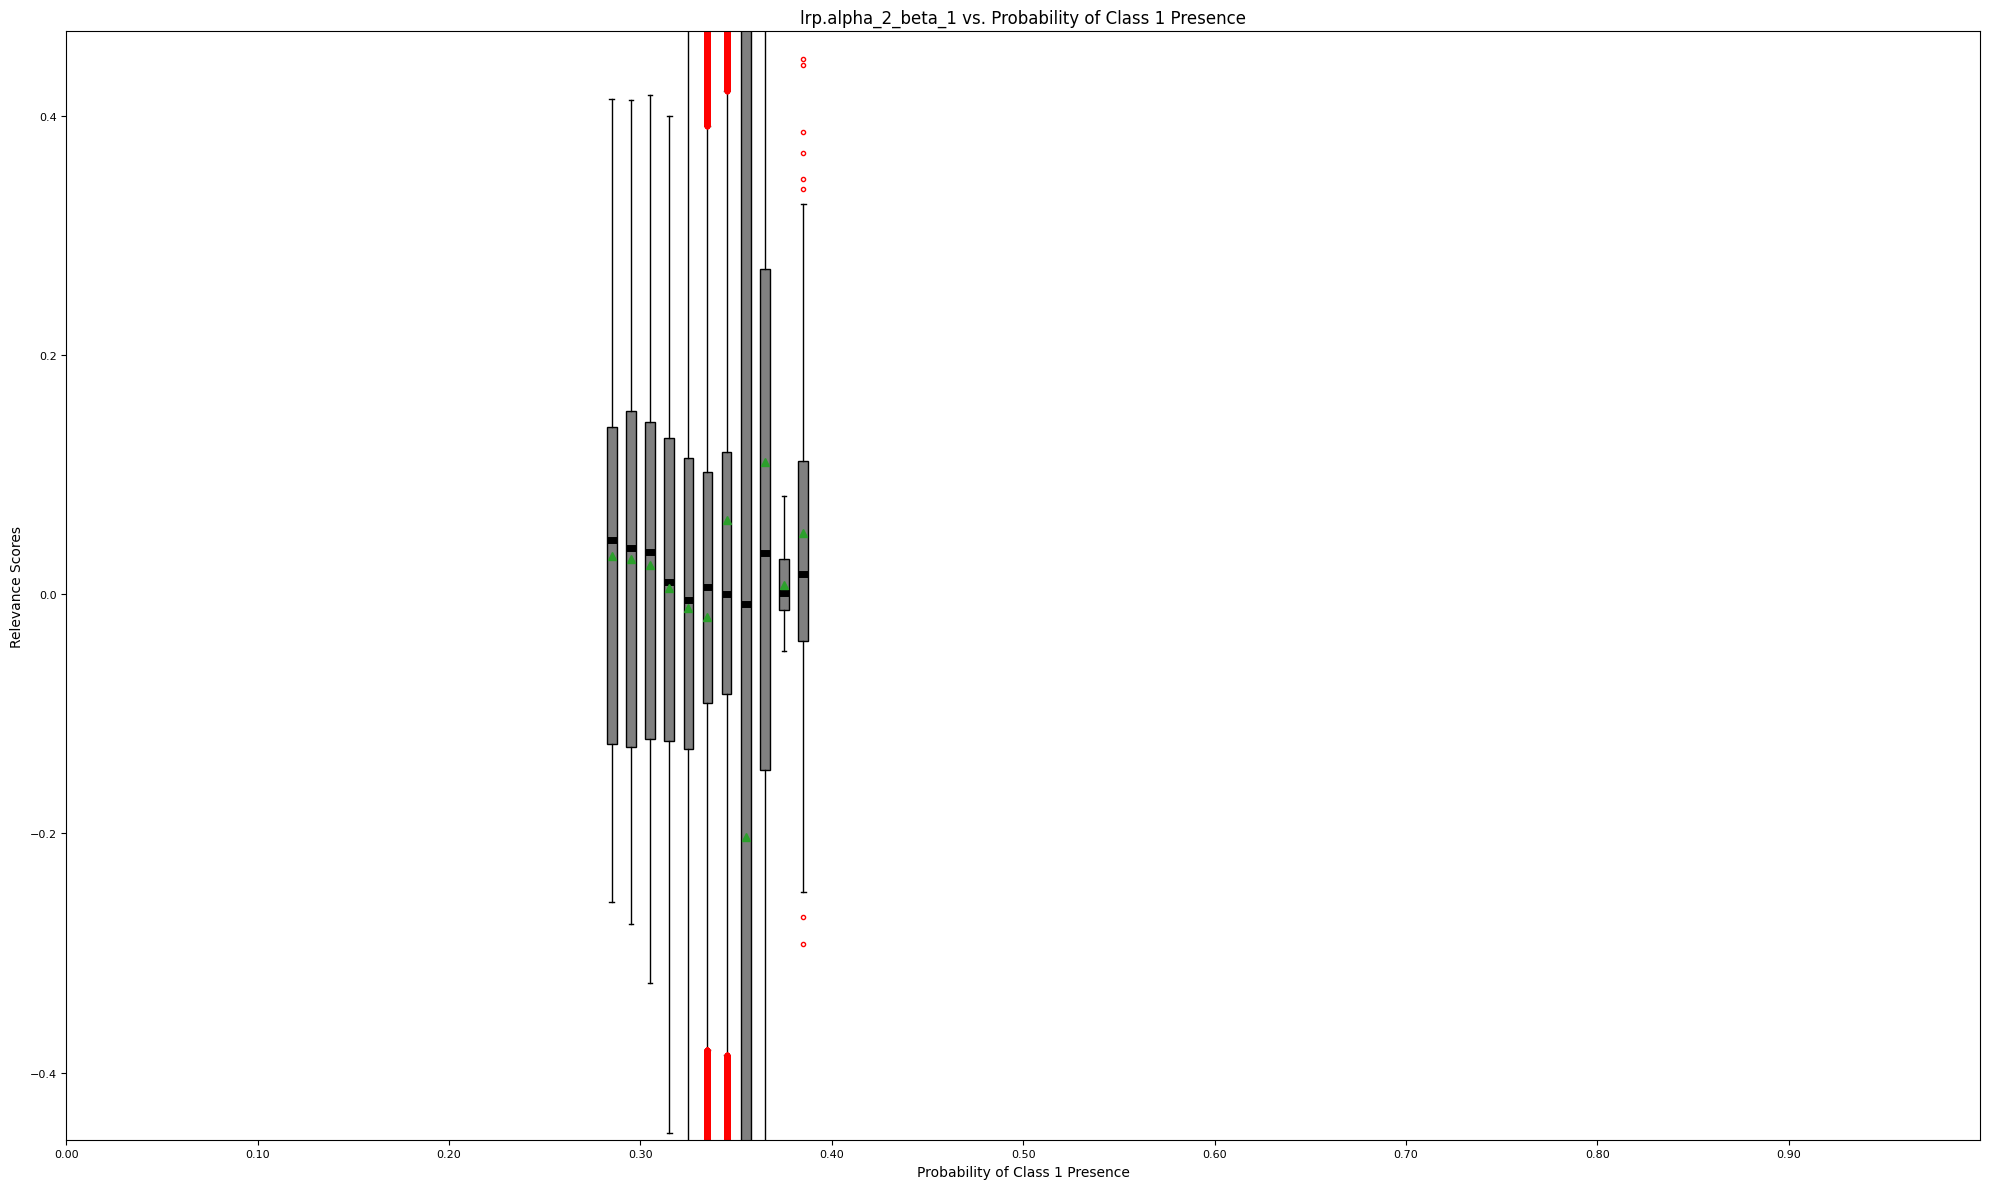

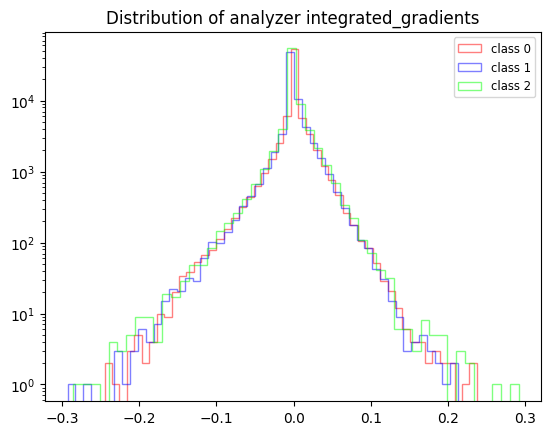

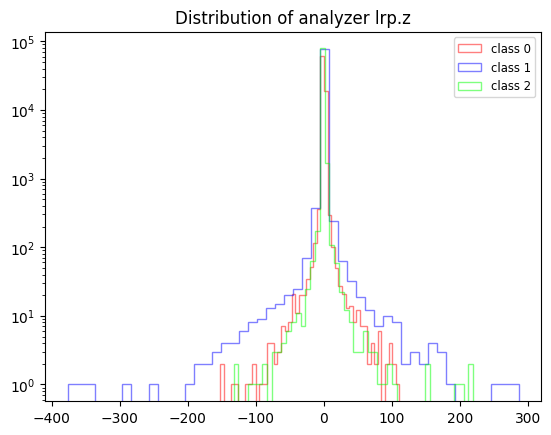

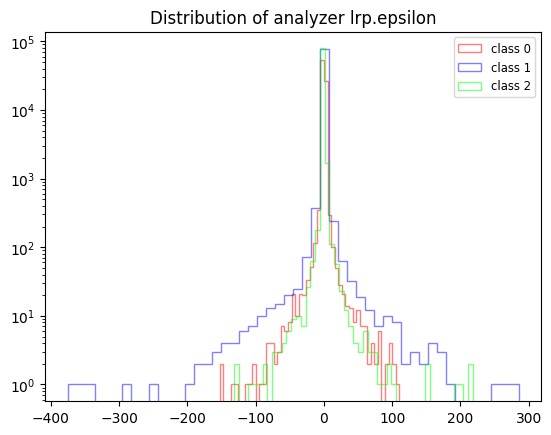

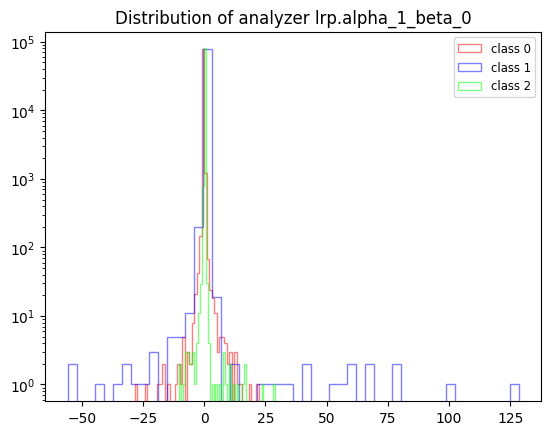

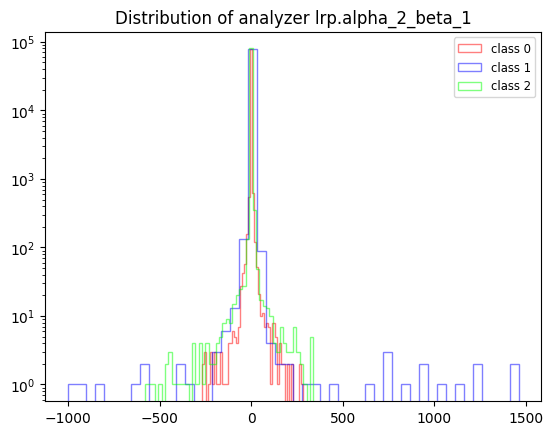

In [14]:

def normalize(data, min_val, max_val):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (max_val - min_val) + min_val

def get_predicted_classes(preds):
    return np.argmax(preds, axis=1)

def get_truth_classes(labels):
    return np.argmax(labels, axis=1)

def get_truth_class_indices(class_num, labels): # GOOD NOW
    # gives the indices of a certain class based on the ground truth label
    return np.where(get_truth_classes(labels) == class_num)[0]

def get_pred_class_indices(class_num, preds):
    return np.where(get_predicted_classes(preds) == class_num)[0]

def get_correct_prediction_indices(preds, labels): ##GOOD
    predicted_labels = np.argmax(preds, axis=1)
    return np.where(predicted_labels == np.argmax(labels, axis=1))[0]

def get_incorrect_prediction_indices(preds, labels): ##GOOD
    predicted_labels = np.argmax(preds, axis=1)
    return np.where(predicted_labels != np.argmax(labels, axis=1))[0]


def get_correct_prediction_indices_for_class(preds, labels, class_num): ##GOOD 
    correct_pred_indices = get_correct_prediction_indices(preds, labels)
    class_indices = get_truth_class_indices(class_num, labels)
    return np.intersect1d(correct_pred_indices, class_indices)

def get_incorrect_prediction_indices_for_class(preds, labels, class_num): #GOOD NOW
    false_pos_indices = get_false_positive_indices(preds, labels, class_num)
    false_neg_indices = get_false_negative_indices(preds, labels, class_num)
    return np.union1d(false_pos_indices, false_neg_indices)


def upsample(data, factor):
# Determine the number of new points to be inserted between each original point
    new_points = factor - 1

    # Initialize an empty list to store the new interpolated data
    interpolated_data = []

    for i in range(len(data) - 1):
        interpolated_data.append(data[i])  # Include the original point

        # Calculate the values to be interpolated between the current and next point
        for n in range(1, new_points + 1):
            interpolated_value = data[i] + (data[i + 1] - data[i]) * n / factor
            interpolated_data.append(interpolated_value)

    interpolated_data.append(data[-1])  # Include the last original point

    return interpolated_data

def set_dynamic_ylim(data, k=1.5):
    """
    Set the y-axis limits dynamically based on the interquartile range (IQR) of the data.
    
    Parameters:
    - data: The array of data points to consider.
    - k: The factor to multiply the IQR by to define the fence for outliers. Default is 1.5.
    """
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - (k * iqr)
    upper_fence = q3 + (k * iqr)

    # Exclude data points that are outside the fences
    filtered_data = data[(data >= lower_fence) & (data <= upper_fence)]

    # Set some buffer around the min and max of the filtered data
    buffer = iqr * 0.1
    return np.min(filtered_data) - buffer, np.max(filtered_data) + buffer

def plot_binned_over_classes_distribution(input, labels, analyzer, analyzer_title):
    """
    Avarage relevance scores over class

    Creates a histogram for the analyzer given as parameter.
    The plot visualize all the classes' analyzer outcomes' distribution
    Classes seperated by the gorund truth labels
    """
    analyzer_output = analyzer.analyze(input)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = [(1, 0, 0, 0.5),(0, 0, 1, 0.5),(0, 1, 0, 0.5)]
    for class_num in [0,1,2]:
        class_indices = get_truth_class_indices(class_num, labels)
        class_values = input[class_indices]
        analyzer_class = analyzer_output[class_indices]
        if class_values.shape[0] == 0:
            continue
        ax.hist(analyzer_class.flatten(), bins=50, color=colors[class_num], histtype='step', linewidth=1, label=f"class {class_num}")
    ax.set_title(f"Distribution of analyzer {analyzer_title}")
    ax.set_yscale("log")
    ax.legend(fontsize = 'small')
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/hist_plot_distribution/{analyzer_title}.png")
    plt.show()

def plot_grouped_boxplot(predictions, class_num, analyzer, input, analyzer_title):
    analyzer_output = analyzer.analyze(input)
    class_probabilities = predictions[:, class_num]
    bin_edges = np.arange(0, 1.01, 0.01)
    columns = []

    for start, end in zip(bin_edges[:-1], bin_edges[1:]):
        indices = np.where((class_probabilities >= start) & (class_probabilities < end))
        rel_bin = analyzer_output[indices].flatten()
        #print(f"start: {start}, end: {end}, len: {len(rel_bin)}")
        columns.append(rel_bin)

    # Plotting
    plt.figure(figsize=(20, 12))
    flierprops = dict(marker='o', markersize=3, linestyle='none', markeredgecolor='red')
    for i, rel_bin in enumerate(columns):
        bin_mid_point = (bin_edges[i] + bin_edges[i+1]) / 2
        if rel_bin.size > 0:
            plt.boxplot(rel_bin, positions=[bin_mid_point], widths=0.005, flierprops=flierprops, patch_artist=True, boxprops = dict(facecolor = "gray"), showmeans=True, meanprops = dict(color = "red", linewidth = 5), medianprops = dict(color = "black", linewidth = 5))
            #plt.boxplot(rel_bin, positions=[bin_mid_point], widths=0.005, flierprops=flierprops, showmeans=True, meanprops = dict(color = "green", linewidth = 5))

    plt.title(f"{analyzer_title} vs. Probability of Class {class_num} Presence")
    plt.xlabel(f"Probability of Class {class_num} Presence")
    plt.ylabel("Relevance Scores")
    plt.xlim(bin_edges[0], bin_edges[-1])
    ylim_lower, ylim_upper = set_dynamic_ylim(analyzer_output)
    plt.ylim(ylim_lower, ylim_upper)
    tick_step = 0.1  # Define the step for the x-ticks
    positions = np.arange(bin_edges[0], bin_edges[-1], tick_step)
    plt.xticks(positions, [f"{pos:.2f}" for pos in positions], fontsize=8)
    #plt.xticks(np.arange(0, 1, 0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/box_plot_distribution/{analyzer_title}_class_{class_num}.png")
    plt.show()



def plot_avg_analyzer_vs_random_beat(input, labels, analyzer, class_num, num_to_analyze, title, predictions):
    analyzer_output = analyzer.analyze(input)
    #class indices based on the labels
    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, class_num)
    incorrect_indices_for_class = get_incorrect_prediction_indices_for_class(predictions, labels, class_num)

    #class values compared to the predictions
    correct_input_for_class = input[correct_indices_for_class]
    incorrect_input_for_class = input[incorrect_indices_for_class]

    #analyzer values for class based on the predictions
    correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
    incorrect_analyzer_for_class = analyzer_output[incorrect_indices_for_class]
    
    if correct_input_for_class.shape[0] == 0:
        print(f"There is no class {class_num}.")
        return

    correct_analyzer_class_mean = np.mean(correct_analyzer_for_class, axis=0, keepdims=True)
    incorrect_analyzer_class_mean = np.mean(incorrect_analyzer_for_class, axis=0, keepdims=True)

    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    incorrect_input_class_mean = np.mean(incorrect_input_for_class, axis=0, keepdims=True)



    random_correct_indices_to_plot = random.sample(range(correct_input_for_class.shape[0]), num_to_analyze)
    random_incorrect_indices_to_plot = random.sample(range(incorrect_input_for_class.shape[0]), num_to_analyze)

    #########################################################################################
    num_rows = (num_to_analyze + 1) // 2
    fig, axs = plt.subplots(num_rows+1, 2, figsize=(15, 8 * num_rows+1))
    plt.subplots_adjust(hspace=0.5)

    axs[0,0].hist(correct_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1)
    axs[0,0].set_title("Input distribution")
    axs[0,0].set_yscale("log")


    axs[0,1].hist(correct_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1)
    axs[0,1].set_title("Analyzer distribution")
    axs[0,1].set_yscale("log")
    
    for i, index in enumerate(random_correct_indices_to_plot):
        row, col = divmod(i, 2)
        ax = axs[row+1, col]
    
        ax.plot(normalize(correct_input_for_class[index,:], -1, 1), color="r", linewidth = 1.5, label="Single correct input data")
        #ax.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
        ax.scatter(range(correct_analyzer_for_class.shape[1]), normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", label="Correct analyzer mean", s=2)
        
        for h_line in np.arange(-1,1.25,0.5):
            ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        
        ax.set_yticks(np.arange(-1, 1.25, 0.25))
        ax.legend(fontsize = 'small')
        ax.set_ylabel("ecg")
        ax.set_xlabel("time")
    fig.suptitle(f"Analyzer: {title} - Class: {class_num}")
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_single_beat/correct/{title}_class_{class_num}.png")
    plt.show()

    #########################################################################################
    num_rows = (num_to_analyze) // 2
    fig, axs = plt.subplots(num_rows+1, 2, figsize=(15, 8 * num_rows+1))
    plt.subplots_adjust(hspace=0.5)

    axs[0,0].hist(incorrect_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1)
    axs[0,0].set_title("Input distribution")
    axs[0,0].set_yscale("log")


    axs[0,1].hist(incorrect_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1)
    axs[0,1].set_title("Analyzer distribution")
    axs[0,1].set_yscale("log")
    
    for i, index in enumerate(random_incorrect_indices_to_plot):
        row, col = divmod(i, 2)
        ax = axs[row+1, col]
        ax.plot(normalize(incorrect_input_for_class[index,:], -1, 1), color="r", linewidth = 1.5, label="Single incorrect input data")
        #ax.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
        ax.scatter(range(incorrect_analyzer_for_class.shape[1]), normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", label="Inorrect analyzer mean", s=2)
        
        for h_line in np.arange(-1,1.25,0.5):
            ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        
        ax.set_yticks(np.arange(-1, 1.25, 0.25))
        ax.legend(fontsize = 'small')
        ax.set_ylabel("ecg")
        ax.set_xlabel("time")
    fig.suptitle(f"Analyzer: {title} - Class: {class_num}")
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_single_beat/incorrect/false_neg/{title}_class_{class_num}.png")
    plt.show()


def plot_avarage_relevance_scores_over_class_and_beats(input, labels, analyzer, class_num, title, predictions):
    analyzer_output = analyzer.analyze(input)

    #class indices based on the labels
    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, class_num)
    incorrect_indices_for_class = get_incorrect_prediction_indices_for_class(predictions, labels, class_num)

    #class values compared to the predictions
    correct_input_for_class = input[correct_indices_for_class]
    incorrect_input_for_class = input[incorrect_indices_for_class]

    #analyzer values for class based on the predictions
    correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
    incorrect_analyzer_for_class = analyzer_output[incorrect_indices_for_class]
    
    if correct_input_for_class.shape[0] == 0:
        print(f"There is no class {class_num}.")
        return

    correct_analyzer_class_mean = np.mean(correct_analyzer_for_class, axis=0, keepdims=True)
    incorrect_analyzer_class_mean = np.mean(incorrect_analyzer_for_class, axis=0, keepdims=True)

    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    incorrect_input_class_mean = np.mean(incorrect_input_for_class, axis=0, keepdims=True)

    upsamled_correct_analyzer_for_class = upsample(correct_analyzer_class_mean[0,:], 5)
    upsamled_incorrect_analyzer_for_class = upsample(incorrect_analyzer_class_mean[0,:], 5)

    #########################################################################################

    plt.figure(figsize=(10,6))
    plt.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="r", label="Correct input mean")
    #plt.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
    plt.scatter(range(len(correct_analyzer_for_class[0,:])), normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", label="Correct analyzer mean", s=2)
    

    for h_line in np.arange(-1,1.25,0.5):
        plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
    
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.legend(fontsize = 'small')
    plt.ylabel("ecg")
    plt.xlabel("time")
    plt.title(f"Analyzer: {title} - Class: {class_num}")
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_avg_beat/correct/{title}_class_{class_num}.png")
    plt.show()


    #########################################################################################
    plt.figure(figsize=(10,6))
    plt.plot(normalize(incorrect_input_class_mean[0,:], -1, 1), color="r", label="Incorrect input mean")
    #plt.plot(normalize(incorrect_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
    plt.scatter(range(len(incorrect_analyzer_for_class[0,:])), normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", label="Incorrect analyzer mean", s=2)
    for h_line in np.arange(-1,1.25,0.5):
        plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.legend(fontsize = 'small')
    plt.ylabel("ecg")
    plt.xlabel("time")
    plt.title(f"Analyzer: {title} - Class: {class_num}")
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/avg_analyzer_avg_beat/incorrect/false_pos/{title}_class_{class_num}.png")
    plt.show()


for key,value in analyzers.items():
    for class_num in [0,1]:
        plot_avg_analyzer_vs_random_beat(test_x, test_y, value, class_num, 4, key, predictions)
        plot_avarage_relevance_scores_over_class_and_beats(test_x, test_y, value, class_num, key, predictions)
        plot_grouped_boxplot(predictions, class_num, value, test_x, key)
for key,value in analyzers.items():
    plot_binned_over_classes_distribution(test_x, test_y, value, key)
    

